In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

1.8.0
True


In [3]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break
            
    env.close()

In [5]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [6]:
# Code based on: https://github.com/sfujim/TD3/blob/master/OurDDPG.py

class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x)) 
        
        return x
    
class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
        self.l4 = nn.Linear(s_size + a_size, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        
        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))
        x2 = self.l6(F.relu(self.l5(F.relu(self.l4(xu)))))
        
        return x1, x2

In [7]:
class Buffer(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))
        
        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):
        
        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)
        
        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)
        
        return (s, a_cpu, n_s, r, done)

In [8]:
# Code based on: https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/TwinDelayed.py

class DDPG(object): 
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, buffer, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        
        for it in range(iterations):

            # Sample replay buffer
            s, a_cpu, n_s, r, done = buffer.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)
            
            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            target_Q1, target_Q2 = self.critic_target(n_s, n_a)
            target_Q = torch.min(target_Q1, target_Q2)
            
            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    

In [9]:
# https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/BipedalWalker_1795ep_300-5sc_9h44m.ipynb

def Train(episodes, save_every=10):
    
    time_start = time.time() 
    
    T_start = 1e4
    T_total = 0
    steps = 0
    
    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []    
    
    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0] 
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)          
    buffer = Buffer(s_size, a_size)   
            
    for i in trange(1, episodes + 1):
        
        timestep = 0
        timestep_max = env._max_episode_steps
        
        R = 0
        s = env.reset()
        
        while True:
            if T_total < T_start:
                a = env.action_space.sample()
                
            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)
            
            timestep += 1
            T_total += 1
            steps += 1
            
            R += r
            done_ = done
            
            if timestep == timestep_max:
                done_ = 0 
 
            buffer.add(s, a, n_s, r, done_)
            s = n_s

            if done:                                       
                break                                     

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)
        
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(buffer, timestep)
        
        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break 

    return scores, Avg_Scores

In [10]:
scores, Avg_Scores = Train(episodes = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Ep. 1, Timestep 87,  Ep.Timesteps 87, Score: -116.75, Avg.Score: -116.75, Time: 00:00:03 


  0%|          | 1/2000 [00:01<45:00,  1.35s/it]

Ep. 2, Timestep 156,  Ep.Timesteps 69, Score: -102.92, Avg.Score: -109.84, Time: 00:00:04 


  0%|          | 2/2000 [00:02<33:47,  1.02s/it]

Ep. 3, Timestep 204,  Ep.Timesteps 48, Score: -113.19, Avg.Score: -110.95, Time: 00:00:05 


  0%|          | 3/2000 [00:02<25:49,  1.29it/s]

Ep. 4, Timestep 278,  Ep.Timesteps 74, Score: -102.89, Avg.Score: -108.94, Time: 00:00:05 


  0%|          | 4/2000 [00:03<25:34,  1.30it/s]

Ep. 5, Timestep 1878,  Ep.Timesteps 1600, Score: -82.39, Avg.Score: -103.63, Time: 00:00:09 


  0%|          | 5/2000 [00:18<3:17:51,  5.95s/it]

Ep. 6, Timestep 3478,  Ep.Timesteps 1600, Score: -80.42, Avg.Score: -99.76, Time: 00:00:24 


  0%|          | 6/2000 [00:33<5:00:51,  9.05s/it]

Ep. 7, Timestep 3525,  Ep.Timesteps 47, Score: -110.52, Avg.Score: -101.30, Time: 00:00:36 


  0%|          | 7/2000 [00:34<3:27:14,  6.24s/it]

Ep. 8, Timestep 3621,  Ep.Timesteps 96, Score: -118.43, Avg.Score: -103.44, Time: 00:00:37 


  0%|          | 8/2000 [00:34<2:30:41,  4.54s/it]

Ep. 9, Timestep 3728,  Ep.Timesteps 107, Score: -99.65, Avg.Score: -103.02, Time: 00:00:37 


  0%|          | 9/2000 [00:35<1:54:14,  3.44s/it]

Ep. 10, Timestep 3775,  Ep.Timesteps 47, Score: -109.75, Avg.Score: -103.69, Time: 00:00:38 


  0%|          | 10/2000 [00:36<1:24:22,  2.54s/it]

Ep. 11, Timestep 5375,  Ep.Timesteps 1600, Score: -76.77, Avg.Score: -101.24, Time: 00:00:43 


  1%|          | 11/2000 [00:51<3:35:21,  6.50s/it]

Ep. 12, Timestep 6975,  Ep.Timesteps 1600, Score: -88.65, Avg.Score: -100.19, Time: 00:00:58 


  1%|          | 12/2000 [01:07<5:05:50,  9.23s/it]

Ep. 13, Timestep 7094,  Ep.Timesteps 119, Score: -123.67, Avg.Score: -102.00, Time: 00:01:10 


  1%|          | 13/2000 [01:08<3:45:22,  6.81s/it]

Ep. 14, Timestep 8694,  Ep.Timesteps 1600, Score: -80.63, Avg.Score: -100.47, Time: 00:01:15 


  1%|          | 14/2000 [01:24<5:13:28,  9.47s/it]

Ep. 15, Timestep 8766,  Ep.Timesteps 72, Score: -111.46, Avg.Score: -101.21, Time: 00:01:27 


  1%|          | 15/2000 [01:25<3:46:09,  6.84s/it]

Ep. 16, Timestep 10119,  Ep.Timesteps 1353, Score: -195.96, Avg.Score: -107.13, Time: 00:01:31 


  1%|          | 16/2000 [01:38<4:48:19,  8.72s/it]

Ep. 17, Timestep 10166,  Ep.Timesteps 47, Score: -101.74, Avg.Score: -106.81, Time: 00:01:41 


  1%|          | 17/2000 [01:38<3:26:41,  6.25s/it]

Ep. 18, Timestep 10227,  Ep.Timesteps 61, Score: -109.08, Avg.Score: -106.94, Time: 00:01:41 


  1%|          | 18/2000 [01:39<2:31:24,  4.58s/it]

Ep. 19, Timestep 10279,  Ep.Timesteps 52, Score: -101.78, Avg.Score: -106.67, Time: 00:01:42 


  1%|          | 19/2000 [01:39<1:51:43,  3.38s/it]

Ep. 20, Timestep 10320,  Ep.Timesteps 41, Score: -104.74, Avg.Score: -106.57, Time: 00:01:42 


  1%|          | 20/2000 [01:40<1:22:53,  2.51s/it]

Ep. 21, Timestep 10368,  Ep.Timesteps 48, Score: -101.40, Avg.Score: -106.32, Time: 00:01:43 


  1%|          | 21/2000 [01:40<1:03:24,  1.92s/it]

Ep. 22, Timestep 10418,  Ep.Timesteps 50, Score: -109.45, Avg.Score: -106.46, Time: 00:01:43 


  1%|          | 22/2000 [01:41<49:47,  1.51s/it]  

Ep. 23, Timestep 10465,  Ep.Timesteps 47, Score: -107.06, Avg.Score: -106.49, Time: 00:01:44 


  1%|          | 23/2000 [01:42<40:10,  1.22s/it]

Ep. 24, Timestep 10509,  Ep.Timesteps 44, Score: -108.09, Avg.Score: -106.56, Time: 00:01:45 


  1%|          | 24/2000 [01:42<33:07,  1.01s/it]

Ep. 25, Timestep 10556,  Ep.Timesteps 47, Score: -107.63, Avg.Score: -106.60, Time: 00:01:45 


  1%|▏         | 25/2000 [01:43<28:26,  1.16it/s]

Ep. 26, Timestep 10603,  Ep.Timesteps 47, Score: -104.82, Avg.Score: -106.53, Time: 00:01:46 


  1%|▏         | 26/2000 [01:43<25:03,  1.31it/s]

Ep. 27, Timestep 10670,  Ep.Timesteps 67, Score: -112.70, Avg.Score: -106.76, Time: 00:01:46 


  1%|▏         | 27/2000 [01:44<24:24,  1.35it/s]

Ep. 28, Timestep 10720,  Ep.Timesteps 50, Score: -111.54, Avg.Score: -106.93, Time: 00:01:47 


  1%|▏         | 28/2000 [01:44<22:06,  1.49it/s]

Ep. 29, Timestep 10779,  Ep.Timesteps 59, Score: -114.49, Avg.Score: -107.19, Time: 00:01:47 


  1%|▏         | 29/2000 [01:45<21:27,  1.53it/s]

Ep. 30, Timestep 10848,  Ep.Timesteps 69, Score: -109.89, Avg.Score: -107.28, Time: 00:01:48 


  2%|▏         | 30/2000 [01:46<21:55,  1.50it/s]

Ep. 31, Timestep 10911,  Ep.Timesteps 63, Score: -114.57, Avg.Score: -107.52, Time: 00:01:49 


  2%|▏         | 31/2000 [01:46<21:34,  1.52it/s]

Ep. 32, Timestep 10954,  Ep.Timesteps 43, Score: -105.60, Avg.Score: -107.46, Time: 00:01:49 


  2%|▏         | 32/2000 [01:47<19:24,  1.69it/s]

Ep. 33, Timestep 11033,  Ep.Timesteps 79, Score: -109.20, Avg.Score: -107.51, Time: 00:01:50 


  2%|▏         | 33/2000 [01:47<20:37,  1.59it/s]

Ep. 34, Timestep 11090,  Ep.Timesteps 57, Score: -109.55, Avg.Score: -107.57, Time: 00:01:50 


  2%|▏         | 34/2000 [01:48<20:38,  1.59it/s]

Ep. 35, Timestep 11147,  Ep.Timesteps 57, Score: -110.93, Avg.Score: -107.67, Time: 00:01:51 


  2%|▏         | 35/2000 [01:49<20:12,  1.62it/s]

Ep. 36, Timestep 11207,  Ep.Timesteps 60, Score: -109.76, Avg.Score: -107.72, Time: 00:01:52 


  2%|▏         | 36/2000 [01:49<20:04,  1.63it/s]

Ep. 37, Timestep 11265,  Ep.Timesteps 58, Score: -110.16, Avg.Score: -107.79, Time: 00:01:52 


  2%|▏         | 37/2000 [01:50<19:50,  1.65it/s]

Ep. 38, Timestep 11325,  Ep.Timesteps 60, Score: -111.59, Avg.Score: -107.89, Time: 00:01:53 


  2%|▏         | 38/2000 [01:50<19:51,  1.65it/s]

Ep. 39, Timestep 11376,  Ep.Timesteps 51, Score: -106.40, Avg.Score: -107.85, Time: 00:01:53 


  2%|▏         | 39/2000 [01:51<19:35,  1.67it/s]

Ep. 40, Timestep 11445,  Ep.Timesteps 69, Score: -108.57, Avg.Score: -107.87, Time: 00:01:54 


  2%|▏         | 40/2000 [01:52<21:21,  1.53it/s]

Ep. 41, Timestep 11504,  Ep.Timesteps 59, Score: -105.49, Avg.Score: -107.81, Time: 00:01:55 


  2%|▏         | 41/2000 [01:52<21:16,  1.54it/s]

Ep. 42, Timestep 11545,  Ep.Timesteps 41, Score: -105.01, Avg.Score: -107.74, Time: 00:01:55 


  2%|▏         | 42/2000 [01:53<19:17,  1.69it/s]

Ep. 43, Timestep 11586,  Ep.Timesteps 41, Score: -104.64, Avg.Score: -107.67, Time: 00:01:56 


  2%|▏         | 43/2000 [01:53<17:51,  1.83it/s]

Ep. 44, Timestep 11626,  Ep.Timesteps 40, Score: -103.41, Avg.Score: -107.58, Time: 00:01:56 


  2%|▏         | 44/2000 [01:54<16:59,  1.92it/s]

Ep. 45, Timestep 11713,  Ep.Timesteps 87, Score: -102.73, Avg.Score: -107.47, Time: 00:01:57 


  2%|▏         | 45/2000 [01:55<21:20,  1.53it/s]

Ep. 46, Timestep 11773,  Ep.Timesteps 60, Score: -106.99, Avg.Score: -107.46, Time: 00:01:58 


  2%|▏         | 46/2000 [01:55<21:32,  1.51it/s]

Ep. 47, Timestep 11833,  Ep.Timesteps 60, Score: -106.40, Avg.Score: -107.43, Time: 00:01:58 


  2%|▏         | 47/2000 [01:56<21:42,  1.50it/s]

Ep. 48, Timestep 11911,  Ep.Timesteps 78, Score: -102.67, Avg.Score: -107.34, Time: 00:01:59 


  2%|▏         | 48/2000 [01:57<23:23,  1.39it/s]

Ep. 49, Timestep 11994,  Ep.Timesteps 83, Score: -101.99, Avg.Score: -107.23, Time: 00:02:00 


  2%|▏         | 49/2000 [01:58<25:11,  1.29it/s]

Ep. 50, Timestep 12081,  Ep.Timesteps 87, Score: -101.96, Avg.Score: -107.12, Time: 00:02:01 


  2%|▎         | 50/2000 [01:59<26:02,  1.25it/s]

Ep. 51, Timestep 12171,  Ep.Timesteps 90, Score: -100.41, Avg.Score: -106.99, Time: 00:02:02 


  3%|▎         | 51/2000 [02:00<27:06,  1.20it/s]

Ep. 52, Timestep 12262,  Ep.Timesteps 91, Score: -101.21, Avg.Score: -106.88, Time: 00:02:03 


  3%|▎         | 52/2000 [02:01<27:51,  1.17it/s]

Ep. 53, Timestep 12321,  Ep.Timesteps 59, Score: -106.43, Avg.Score: -106.87, Time: 00:02:04 


  3%|▎         | 53/2000 [02:01<25:18,  1.28it/s]

Ep. 54, Timestep 12392,  Ep.Timesteps 71, Score: -102.82, Avg.Score: -106.80, Time: 00:02:04 


  3%|▎         | 54/2000 [02:02<24:43,  1.31it/s]

Ep. 55, Timestep 13992,  Ep.Timesteps 1600, Score: -134.24, Avg.Score: -107.29, Time: 00:02:09 


  3%|▎         | 55/2000 [02:18<2:50:21,  5.26s/it]

Ep. 56, Timestep 15592,  Ep.Timesteps 1600, Score: -148.33, Avg.Score: -108.03, Time: 00:02:25 


  3%|▎         | 56/2000 [02:34<4:34:36,  8.48s/it]

Ep. 57, Timestep 17192,  Ep.Timesteps 1600, Score: -138.69, Avg.Score: -108.56, Time: 00:02:41 


  3%|▎         | 57/2000 [02:50<5:47:18, 10.73s/it]

Ep. 58, Timestep 17331,  Ep.Timesteps 139, Score: -115.12, Avg.Score: -108.68, Time: 00:02:53 


  3%|▎         | 58/2000 [02:51<4:17:32,  7.96s/it]

Ep. 59, Timestep 17439,  Ep.Timesteps 108, Score: -110.66, Avg.Score: -108.71, Time: 00:02:54 


  3%|▎         | 59/2000 [02:52<3:10:10,  5.88s/it]

Ep. 60, Timestep 17562,  Ep.Timesteps 123, Score: -106.45, Avg.Score: -108.67, Time: 00:02:55 


  3%|▎         | 60/2000 [02:53<2:24:43,  4.48s/it]

Ep. 61, Timestep 17661,  Ep.Timesteps 99, Score: -129.89, Avg.Score: -109.02, Time: 00:02:56 


  3%|▎         | 61/2000 [02:54<1:50:34,  3.42s/it]

Ep. 62, Timestep 18259,  Ep.Timesteps 598, Score: -127.49, Avg.Score: -109.32, Time: 00:02:59 


  3%|▎         | 62/2000 [03:00<2:14:52,  4.18s/it]

Ep. 63, Timestep 18424,  Ep.Timesteps 165, Score: -122.58, Avg.Score: -109.53, Time: 00:03:03 


  3%|▎         | 63/2000 [03:02<1:50:01,  3.41s/it]

Ep. 64, Timestep 19330,  Ep.Timesteps 906, Score: -148.44, Avg.Score: -110.14, Time: 00:03:07 


  3%|▎         | 64/2000 [03:11<2:47:45,  5.20s/it]

Ep. 65, Timestep 19540,  Ep.Timesteps 210, Score: -123.34, Avg.Score: -110.34, Time: 00:03:15 


  3%|▎         | 65/2000 [03:13<2:17:07,  4.25s/it]

Ep. 66, Timestep 19866,  Ep.Timesteps 326, Score: -149.62, Avg.Score: -110.94, Time: 00:03:17 


  3%|▎         | 66/2000 [03:16<2:06:09,  3.91s/it]

Ep. 67, Timestep 20119,  Ep.Timesteps 253, Score: -125.70, Avg.Score: -111.16, Time: 00:03:20 


  3%|▎         | 67/2000 [03:19<1:54:09,  3.54s/it]

Ep. 68, Timestep 20320,  Ep.Timesteps 201, Score: -121.39, Avg.Score: -111.31, Time: 00:03:23 


  3%|▎         | 68/2000 [03:21<1:41:11,  3.14s/it]

Ep. 69, Timestep 21920,  Ep.Timesteps 1600, Score: -93.88, Avg.Score: -111.05, Time: 00:03:28 


  3%|▎         | 69/2000 [03:37<3:45:58,  7.02s/it]

Ep. 70, Timestep 22053,  Ep.Timesteps 133, Score: -106.60, Avg.Score: -110.99, Time: 00:03:41 


  4%|▎         | 70/2000 [03:39<2:52:10,  5.35s/it]

Ep. 71, Timestep 22254,  Ep.Timesteps 201, Score: -133.83, Avg.Score: -111.31, Time: 00:03:42 


  4%|▎         | 71/2000 [03:41<2:20:28,  4.37s/it]

Ep. 72, Timestep 23854,  Ep.Timesteps 1600, Score: -145.29, Avg.Score: -111.78, Time: 00:03:47 


  4%|▎         | 72/2000 [03:57<4:10:43,  7.80s/it]

Ep. 73, Timestep 23953,  Ep.Timesteps 99, Score: -108.16, Avg.Score: -111.73, Time: 00:04:00 


  4%|▎         | 73/2000 [03:58<3:04:40,  5.75s/it]

Ep. 74, Timestep 25553,  Ep.Timesteps 1600, Score: -102.73, Avg.Score: -111.61, Time: 00:04:05 


  4%|▎         | 74/2000 [04:14<4:42:52,  8.81s/it]

Ep. 75, Timestep 27153,  Ep.Timesteps 1600, Score: -136.31, Avg.Score: -111.94, Time: 00:04:21 


  4%|▍         | 75/2000 [04:30<5:53:52, 11.03s/it]

Ep. 76, Timestep 28753,  Ep.Timesteps 1600, Score: -91.78, Avg.Score: -111.68, Time: 00:04:37 


  4%|▍         | 76/2000 [04:46<6:44:25, 12.61s/it]

Ep. 77, Timestep 30278,  Ep.Timesteps 1525, Score: -242.37, Avg.Score: -113.37, Time: 00:04:53 


  4%|▍         | 77/2000 [05:02<7:12:21, 13.49s/it]

Ep. 78, Timestep 31878,  Ep.Timesteps 1600, Score: -138.63, Avg.Score: -113.70, Time: 00:05:09 


  4%|▍         | 78/2000 [05:18<7:38:09, 14.30s/it]

Ep. 79, Timestep 32946,  Ep.Timesteps 1068, Score: -33.88, Avg.Score: -112.69, Time: 00:05:23 


  4%|▍         | 79/2000 [05:28<7:01:01, 13.15s/it]

Ep. 80, Timestep 33879,  Ep.Timesteps 933, Score: -205.39, Avg.Score: -113.85, Time: 00:05:34 


  4%|▍         | 80/2000 [05:38<6:28:18, 12.13s/it]

Ep. 81, Timestep 35479,  Ep.Timesteps 1600, Score: -53.11, Avg.Score: -113.10, Time: 00:05:45 


  4%|▍         | 81/2000 [05:54<7:04:19, 13.27s/it]

Ep. 82, Timestep 37079,  Ep.Timesteps 1600, Score: -100.74, Avg.Score: -112.95, Time: 00:06:01 


  4%|▍         | 82/2000 [06:10<7:31:27, 14.12s/it]

Ep. 83, Timestep 37132,  Ep.Timesteps 53, Score: -123.26, Avg.Score: -113.07, Time: 00:06:13 


  4%|▍         | 83/2000 [06:11<5:21:11, 10.05s/it]

Ep. 84, Timestep 38732,  Ep.Timesteps 1600, Score: -160.24, Avg.Score: -113.63, Time: 00:06:18 


  4%|▍         | 84/2000 [06:27<6:22:46, 11.99s/it]

Ep. 85, Timestep 40332,  Ep.Timesteps 1600, Score: -167.67, Avg.Score: -114.27, Time: 00:06:35 


  4%|▍         | 85/2000 [06:44<7:09:39, 13.46s/it]

Ep. 86, Timestep 40388,  Ep.Timesteps 56, Score: -110.47, Avg.Score: -114.22, Time: 00:06:47 


  4%|▍         | 86/2000 [06:45<5:05:56,  9.59s/it]

Ep. 87, Timestep 40458,  Ep.Timesteps 70, Score: -111.80, Avg.Score: -114.20, Time: 00:06:48 


  4%|▍         | 87/2000 [06:45<3:40:59,  6.93s/it]

Ep. 88, Timestep 40537,  Ep.Timesteps 79, Score: -108.76, Avg.Score: -114.13, Time: 00:06:48 


  4%|▍         | 88/2000 [06:46<2:42:05,  5.09s/it]

Ep. 89, Timestep 40670,  Ep.Timesteps 133, Score: -109.70, Avg.Score: -114.08, Time: 00:06:49 


  4%|▍         | 89/2000 [06:47<2:05:57,  3.95s/it]

Ep. 90, Timestep 42270,  Ep.Timesteps 1600, Score: -155.98, Avg.Score: -114.55, Time: 00:06:55 


  4%|▍         | 90/2000 [07:04<4:04:45,  7.69s/it]

Ep. 91, Timestep 43870,  Ep.Timesteps 1600, Score: -165.38, Avg.Score: -115.11, Time: 00:07:12 


  5%|▍         | 91/2000 [07:20<5:28:47, 10.33s/it]

Ep. 92, Timestep 43932,  Ep.Timesteps 62, Score: -118.72, Avg.Score: -115.15, Time: 00:07:23 


  5%|▍         | 92/2000 [07:21<3:56:45,  7.45s/it]

Ep. 93, Timestep 44115,  Ep.Timesteps 183, Score: -140.09, Avg.Score: -115.42, Time: 00:07:24 


  5%|▍         | 93/2000 [07:23<3:04:46,  5.81s/it]

Ep. 94, Timestep 45715,  Ep.Timesteps 1600, Score: -114.96, Avg.Score: -115.41, Time: 00:07:30 


  5%|▍         | 94/2000 [07:39<4:44:09,  8.95s/it]

Ep. 95, Timestep 47315,  Ep.Timesteps 1600, Score: -129.52, Avg.Score: -115.56, Time: 00:07:46 


  5%|▍         | 95/2000 [07:56<5:53:55, 11.15s/it]

Ep. 96, Timestep 48915,  Ep.Timesteps 1600, Score: 56.62, Avg.Score: -113.77, Time: 00:08:02 


  5%|▍         | 96/2000 [08:11<6:36:42, 12.50s/it]

Ep. 97, Timestep 50515,  Ep.Timesteps 1600, Score: -45.22, Avg.Score: -113.06, Time: 00:08:18 


  5%|▍         | 97/2000 [08:27<7:07:14, 13.47s/it]

Ep. 98, Timestep 52115,  Ep.Timesteps 1600, Score: -164.21, Avg.Score: -113.58, Time: 00:08:34 


  5%|▍         | 98/2000 [08:43<7:30:28, 14.21s/it]

Ep. 99, Timestep 53715,  Ep.Timesteps 1600, Score: -21.13, Avg.Score: -112.65, Time: 00:08:50 


  5%|▍         | 99/2000 [08:59<7:48:12, 14.78s/it]

Ep. 100, Timestep 55315,  Ep.Timesteps 1600, Score: -154.66, Avg.Score: -113.07, Time: 00:09:06 


  5%|▌         | 100/2000 [09:15<8:01:40, 15.21s/it]

Ep. 101, Timestep 55417,  Ep.Timesteps 102, Score: -115.29, Avg.Score: -113.05, Time: 00:09:18 


  5%|▌         | 101/2000 [09:16<5:47:24, 10.98s/it]

Ep. 102, Timestep 57017,  Ep.Timesteps 1600, Score: -61.10, Avg.Score: -112.63, Time: 00:09:24 


  5%|▌         | 102/2000 [09:33<6:37:08, 12.55s/it]

Ep. 103, Timestep 57154,  Ep.Timesteps 137, Score: -138.02, Avg.Score: -112.88, Time: 00:09:36 


  5%|▌         | 103/2000 [09:34<4:52:17,  9.24s/it]

Ep. 104, Timestep 57273,  Ep.Timesteps 119, Score: -134.38, Avg.Score: -113.20, Time: 00:09:37 


  5%|▌         | 104/2000 [09:35<3:36:55,  6.86s/it]

Ep. 105, Timestep 57421,  Ep.Timesteps 148, Score: -145.75, Avg.Score: -113.83, Time: 00:09:39 


  5%|▌         | 105/2000 [09:37<2:45:30,  5.24s/it]

Ep. 106, Timestep 59021,  Ep.Timesteps 1600, Score: -127.08, Avg.Score: -114.30, Time: 00:09:44 


  5%|▌         | 106/2000 [09:53<4:26:22,  8.44s/it]

Ep. 107, Timestep 60621,  Ep.Timesteps 1600, Score: -68.38, Avg.Score: -113.88, Time: 00:09:59 


  5%|▌         | 107/2000 [10:08<5:35:12, 10.62s/it]

Ep. 108, Timestep 62221,  Ep.Timesteps 1600, Score: -25.23, Avg.Score: -112.94, Time: 00:10:15 


  5%|▌         | 108/2000 [10:24<6:21:42, 12.10s/it]

Ep. 109, Timestep 62513,  Ep.Timesteps 292, Score: -92.93, Avg.Score: -112.88, Time: 00:10:27 


  5%|▌         | 109/2000 [10:27<4:52:08,  9.27s/it]

Ep. 110, Timestep 63495,  Ep.Timesteps 982, Score: -55.40, Avg.Score: -112.33, Time: 00:10:33 


  6%|▌         | 110/2000 [10:37<5:04:12,  9.66s/it]

Ep. 111, Timestep 65095,  Ep.Timesteps 1600, Score: -130.45, Avg.Score: -112.87, Time: 00:10:44 


  6%|▌         | 111/2000 [10:53<6:03:32, 11.55s/it]

Ep. 112, Timestep 66695,  Ep.Timesteps 1600, Score: 83.20, Avg.Score: -111.15, Time: 00:11:00 


  6%|▌         | 112/2000 [11:09<6:44:10, 12.84s/it]

Ep. 113, Timestep 68295,  Ep.Timesteps 1600, Score: 161.57, Avg.Score: -108.30, Time: 00:11:16 


  6%|▌         | 113/2000 [11:25<7:12:59, 13.77s/it]

Ep. 114, Timestep 69752,  Ep.Timesteps 1457, Score: 233.39, Avg.Score: -105.16, Time: 00:11:32 


  6%|▌         | 114/2000 [11:40<7:20:51, 14.03s/it]

Ep. 115, Timestep 71352,  Ep.Timesteps 1600, Score: 199.93, Avg.Score: -102.05, Time: 00:11:47 


  6%|▌         | 115/2000 [11:56<7:39:35, 14.63s/it]

Ep. 116, Timestep 72952,  Ep.Timesteps 1600, Score: -131.16, Avg.Score: -101.40, Time: 00:12:03 


  6%|▌         | 116/2000 [12:12<7:54:07, 15.10s/it]

Ep. 117, Timestep 74552,  Ep.Timesteps 1600, Score: -143.68, Avg.Score: -101.82, Time: 00:12:19 


  6%|▌         | 117/2000 [12:28<8:06:24, 15.50s/it]

Ep. 118, Timestep 76152,  Ep.Timesteps 1600, Score: -103.24, Avg.Score: -101.76, Time: 00:12:36 


  6%|▌         | 118/2000 [12:45<8:15:40, 15.80s/it]

Ep. 119, Timestep 76535,  Ep.Timesteps 383, Score: -101.60, Avg.Score: -101.76, Time: 00:12:49 


  6%|▌         | 119/2000 [12:49<6:25:16, 12.29s/it]

Ep. 120, Timestep 78135,  Ep.Timesteps 1600, Score: -144.91, Avg.Score: -102.16, Time: 00:12:55 


  6%|▌         | 120/2000 [13:05<6:57:03, 13.31s/it]

Ep. 121, Timestep 79735,  Ep.Timesteps 1600, Score: 28.55, Avg.Score: -100.86, Time: 00:13:11 


  6%|▌         | 121/2000 [13:20<7:18:40, 14.01s/it]

Ep. 122, Timestep 81335,  Ep.Timesteps 1600, Score: -130.95, Avg.Score: -101.07, Time: 00:13:27 


  6%|▌         | 122/2000 [13:36<7:34:20, 14.52s/it]

Ep. 123, Timestep 82935,  Ep.Timesteps 1600, Score: -68.36, Avg.Score: -100.69, Time: 00:13:43 


  6%|▌         | 123/2000 [13:52<7:46:58, 14.93s/it]

Ep. 124, Timestep 84535,  Ep.Timesteps 1600, Score: -45.53, Avg.Score: -100.06, Time: 00:13:59 


  6%|▌         | 124/2000 [14:08<7:56:21, 15.24s/it]

Ep. 125, Timestep 84863,  Ep.Timesteps 328, Score: -77.89, Avg.Score: -99.76, Time: 00:14:11 


  6%|▋         | 125/2000 [14:11<6:03:22, 11.63s/it]

Ep. 126, Timestep 86463,  Ep.Timesteps 1600, Score: 189.10, Avg.Score: -96.83, Time: 00:14:19 


  6%|▋         | 126/2000 [14:28<6:49:35, 13.11s/it]

Ep. 127, Timestep 86539,  Ep.Timesteps 76, Score: -120.69, Avg.Score: -96.91, Time: 00:14:31 


  6%|▋         | 127/2000 [14:28<4:53:34,  9.40s/it]

Ep. 128, Timestep 88139,  Ep.Timesteps 1600, Score: 91.90, Avg.Score: -94.87, Time: 00:14:36 


  6%|▋         | 128/2000 [14:45<6:02:34, 11.62s/it]

Ep. 129, Timestep 89739,  Ep.Timesteps 1600, Score: -15.86, Avg.Score: -93.88, Time: 00:14:53 


  6%|▋         | 129/2000 [15:02<6:50:18, 13.16s/it]

Ep. 130, Timestep 91339,  Ep.Timesteps 1600, Score: 61.33, Avg.Score: -92.17, Time: 00:15:10 


  6%|▋         | 130/2000 [15:19<7:23:10, 14.22s/it]

Ep. 131, Timestep 92939,  Ep.Timesteps 1600, Score: 78.65, Avg.Score: -90.24, Time: 00:15:26 


  7%|▋         | 131/2000 [15:35<7:44:18, 14.91s/it]

Ep. 132, Timestep 93163,  Ep.Timesteps 224, Score: -102.74, Avg.Score: -90.21, Time: 00:15:39 


  7%|▋         | 132/2000 [15:38<5:47:40, 11.17s/it]

Ep. 133, Timestep 94763,  Ep.Timesteps 1600, Score: 35.35, Avg.Score: -88.77, Time: 00:15:44 


  7%|▋         | 133/2000 [15:53<6:31:54, 12.59s/it]

Ep. 134, Timestep 96363,  Ep.Timesteps 1600, Score: 75.34, Avg.Score: -86.92, Time: 00:16:01 


  7%|▋         | 134/2000 [16:10<7:05:25, 13.68s/it]

Ep. 135, Timestep 97963,  Ep.Timesteps 1600, Score: 77.50, Avg.Score: -85.03, Time: 00:16:17 


  7%|▋         | 135/2000 [16:26<7:30:36, 14.50s/it]

Ep. 136, Timestep 98510,  Ep.Timesteps 547, Score: -90.16, Avg.Score: -84.84, Time: 00:16:31 


  7%|▋         | 136/2000 [16:32<6:11:24, 11.96s/it]

Ep. 137, Timestep 100110,  Ep.Timesteps 1600, Score: -12.73, Avg.Score: -83.86, Time: 00:16:39 


  7%|▋         | 137/2000 [16:48<6:50:48, 13.23s/it]

Ep. 138, Timestep 101710,  Ep.Timesteps 1600, Score: 193.87, Avg.Score: -80.81, Time: 00:16:55 


  7%|▋         | 138/2000 [17:04<7:15:17, 14.03s/it]

Ep. 139, Timestep 101790,  Ep.Timesteps 80, Score: -120.17, Avg.Score: -80.95, Time: 00:17:07 


  7%|▋         | 139/2000 [17:05<5:11:58, 10.06s/it]

Ep. 140, Timestep 103390,  Ep.Timesteps 1600, Score: 171.06, Avg.Score: -78.15, Time: 00:17:11 


  7%|▋         | 140/2000 [17:21<6:04:06, 11.75s/it]

Ep. 141, Timestep 104990,  Ep.Timesteps 1600, Score: 74.09, Avg.Score: -76.35, Time: 00:17:27 


  7%|▋         | 141/2000 [17:36<6:41:24, 12.96s/it]

Ep. 142, Timestep 106590,  Ep.Timesteps 1600, Score: -2.76, Avg.Score: -75.33, Time: 00:17:43 


  7%|▋         | 142/2000 [17:52<7:05:58, 13.76s/it]

Ep. 143, Timestep 108190,  Ep.Timesteps 1600, Score: 114.52, Avg.Score: -73.14, Time: 00:17:59 


  7%|▋         | 143/2000 [18:08<7:25:23, 14.39s/it]

Ep. 144, Timestep 109790,  Ep.Timesteps 1600, Score: 195.18, Avg.Score: -70.15, Time: 00:18:15 


  7%|▋         | 144/2000 [18:24<7:42:03, 14.94s/it]

Ep. 145, Timestep 111390,  Ep.Timesteps 1600, Score: 112.40, Avg.Score: -68.00, Time: 00:18:31 


  7%|▋         | 145/2000 [18:40<7:51:28, 15.25s/it]

Ep. 146, Timestep 112990,  Ep.Timesteps 1600, Score: 16.54, Avg.Score: -66.77, Time: 00:18:47 


  7%|▋         | 146/2000 [18:56<7:57:49, 15.46s/it]

Ep. 147, Timestep 114590,  Ep.Timesteps 1600, Score: 133.61, Avg.Score: -64.37, Time: 00:19:03 


  7%|▋         | 147/2000 [19:12<8:04:13, 15.68s/it]

Ep. 148, Timestep 116190,  Ep.Timesteps 1600, Score: 224.04, Avg.Score: -61.10, Time: 00:19:19 


  7%|▋         | 148/2000 [19:28<8:04:57, 15.71s/it]

Ep. 149, Timestep 117790,  Ep.Timesteps 1600, Score: 219.72, Avg.Score: -57.88, Time: 00:19:35 


  7%|▋         | 149/2000 [19:44<8:06:38, 15.77s/it]

Ep. 150, Timestep 119390,  Ep.Timesteps 1600, Score: 222.69, Avg.Score: -54.64, Time: 00:19:51 


  8%|▊         | 150/2000 [20:00<8:07:29, 15.81s/it]

Ep. 151, Timestep 120990,  Ep.Timesteps 1600, Score: 200.01, Avg.Score: -51.63, Time: 00:20:06 


  8%|▊         | 151/2000 [20:16<8:07:53, 15.83s/it]

Ep. 152, Timestep 121971,  Ep.Timesteps 981, Score: -90.98, Avg.Score: -51.53, Time: 00:20:21 


  8%|▊         | 152/2000 [20:25<7:08:45, 13.92s/it]

Ep. 153, Timestep 122101,  Ep.Timesteps 130, Score: -117.90, Avg.Score: -51.64, Time: 00:20:28 


  8%|▊         | 153/2000 [20:27<5:12:59, 10.17s/it]

Ep. 154, Timestep 122255,  Ep.Timesteps 154, Score: -120.82, Avg.Score: -51.82, Time: 00:20:30 


  8%|▊         | 154/2000 [20:28<3:54:13,  7.61s/it]

Ep. 155, Timestep 123749,  Ep.Timesteps 1494, Score: 239.18, Avg.Score: -48.09, Time: 00:20:35 


  8%|▊         | 155/2000 [20:44<5:05:35,  9.94s/it]

Ep. 156, Timestep 125349,  Ep.Timesteps 1600, Score: 118.25, Avg.Score: -45.42, Time: 00:20:51 


  8%|▊         | 156/2000 [21:00<6:05:10, 11.88s/it]

Ep. 157, Timestep 126844,  Ep.Timesteps 1495, Score: 234.62, Avg.Score: -41.69, Time: 00:21:07 


  8%|▊         | 157/2000 [21:15<6:32:57, 12.79s/it]

Ep. 158, Timestep 128152,  Ep.Timesteps 1308, Score: 262.47, Avg.Score: -37.92, Time: 00:21:21 


  8%|▊         | 158/2000 [21:28<6:35:24, 12.88s/it]

Ep. 159, Timestep 129507,  Ep.Timesteps 1355, Score: 256.60, Avg.Score: -34.24, Time: 00:21:34 


  8%|▊         | 159/2000 [21:42<6:40:54, 13.07s/it]

Ep. 160, Timestep 130927,  Ep.Timesteps 1420, Score: 245.43, Avg.Score: -30.72, Time: 00:21:49 


  8%|▊         | 160/2000 [21:56<6:54:35, 13.52s/it]

Ep. 161, Timestep 132336,  Ep.Timesteps 1409, Score: 243.42, Avg.Score: -26.99, Time: 00:22:03 


  8%|▊         | 161/2000 [22:11<7:02:44, 13.79s/it]

Ep. 162, Timestep 133729,  Ep.Timesteps 1393, Score: 246.42, Avg.Score: -23.25, Time: 00:22:17 


  8%|▊         | 162/2000 [22:25<7:06:48, 13.93s/it]

Ep. 163, Timestep 135018,  Ep.Timesteps 1289, Score: 255.17, Avg.Score: -19.47, Time: 00:22:31 


  8%|▊         | 163/2000 [22:38<7:04:19, 13.86s/it]

Ep. 164, Timestep 136307,  Ep.Timesteps 1289, Score: 251.38, Avg.Score: -15.48, Time: 00:22:46 


  8%|▊         | 164/2000 [22:54<7:23:06, 14.48s/it]

Ep. 165, Timestep 137673,  Ep.Timesteps 1366, Score: 243.83, Avg.Score: -11.80, Time: 00:23:02 


  8%|▊         | 165/2000 [23:11<7:40:30, 15.06s/it]

Ep. 166, Timestep 138946,  Ep.Timesteps 1273, Score: 253.73, Avg.Score: -7.77, Time: 00:23:19 


  8%|▊         | 166/2000 [23:26<7:45:33, 15.23s/it]

Ep. 167, Timestep 140290,  Ep.Timesteps 1344, Score: 248.25, Avg.Score: -4.03, Time: 00:23:35 


  8%|▊         | 167/2000 [23:43<7:58:20, 15.66s/it]

Ep. 168, Timestep 141615,  Ep.Timesteps 1325, Score: 248.68, Avg.Score: -0.33, Time: 00:23:51 


  8%|▊         | 168/2000 [23:59<8:03:50, 15.85s/it]

Ep. 169, Timestep 142808,  Ep.Timesteps 1193, Score: 269.39, Avg.Score: 3.30, Time: 00:24:06 


  8%|▊         | 169/2000 [24:14<7:48:19, 15.35s/it]

Ep. 170, Timestep 144179,  Ep.Timesteps 1371, Score: 246.51, Avg.Score: 6.83, Time: 00:24:22 


  8%|▊         | 170/2000 [24:31<8:03:14, 15.84s/it]

Ep. 171, Timestep 145481,  Ep.Timesteps 1302, Score: 264.07, Avg.Score: 10.81, Time: 00:24:39 


  9%|▊         | 171/2000 [24:47<8:08:24, 16.02s/it]

Ep. 172, Timestep 146827,  Ep.Timesteps 1346, Score: 257.82, Avg.Score: 14.84, Time: 00:24:55 


  9%|▊         | 172/2000 [25:03<8:09:01, 16.05s/it]

Ep. 173, Timestep 148116,  Ep.Timesteps 1289, Score: 262.54, Avg.Score: 18.55, Time: 00:25:11 


  9%|▊         | 173/2000 [25:19<8:03:16, 15.87s/it]

Ep. 174, Timestep 149338,  Ep.Timesteps 1222, Score: 271.31, Avg.Score: 22.29, Time: 00:25:26 


  9%|▊         | 174/2000 [25:34<7:57:08, 15.68s/it]

Ep. 175, Timestep 150643,  Ep.Timesteps 1305, Score: 258.68, Avg.Score: 26.24, Time: 00:25:42 


  9%|▉         | 175/2000 [25:50<8:00:50, 15.81s/it]

Ep. 176, Timestep 151889,  Ep.Timesteps 1246, Score: 260.42, Avg.Score: 29.76, Time: 00:25:58 


  9%|▉         | 176/2000 [26:06<8:00:03, 15.79s/it]

Ep. 177, Timestep 153224,  Ep.Timesteps 1335, Score: 262.70, Avg.Score: 34.81, Time: 00:26:13 


  9%|▉         | 177/2000 [26:22<8:05:12, 15.97s/it]

Ep. 178, Timestep 154471,  Ep.Timesteps 1247, Score: 266.46, Avg.Score: 38.86, Time: 00:26:29 


  9%|▉         | 178/2000 [26:37<7:54:28, 15.62s/it]

Ep. 179, Timestep 155659,  Ep.Timesteps 1188, Score: 261.78, Avg.Score: 41.82, Time: 00:26:44 


  9%|▉         | 179/2000 [26:52<7:45:46, 15.35s/it]

Ep. 180, Timestep 156889,  Ep.Timesteps 1230, Score: 268.37, Avg.Score: 46.56, Time: 00:27:00 


  9%|▉         | 180/2000 [27:07<7:44:29, 15.31s/it]

Ep. 181, Timestep 158088,  Ep.Timesteps 1199, Score: 267.07, Avg.Score: 49.76, Time: 00:27:14 


  9%|▉         | 181/2000 [27:21<7:38:13, 15.11s/it]

Ep. 182, Timestep 159523,  Ep.Timesteps 1435, Score: 248.80, Avg.Score: 53.26, Time: 00:27:30 


  9%|▉         | 182/2000 [27:39<8:01:31, 15.89s/it]

Ep. 183, Timestep 160714,  Ep.Timesteps 1191, Score: 272.21, Avg.Score: 57.21, Time: 00:27:46 


  9%|▉         | 183/2000 [27:54<7:51:53, 15.58s/it]

Ep. 184, Timestep 162314,  Ep.Timesteps 1600, Score: 233.38, Avg.Score: 61.15, Time: 00:28:02 


  9%|▉         | 184/2000 [28:13<8:20:17, 16.53s/it]

Ep. 185, Timestep 163492,  Ep.Timesteps 1178, Score: 274.19, Avg.Score: 65.57, Time: 00:28:20 


  9%|▉         | 185/2000 [28:27<8:00:24, 15.88s/it]

Ep. 186, Timestep 164719,  Ep.Timesteps 1227, Score: 268.84, Avg.Score: 69.36, Time: 00:28:35 


  9%|▉         | 186/2000 [28:42<7:50:15, 15.55s/it]

Ep. 187, Timestep 165885,  Ep.Timesteps 1166, Score: 274.56, Avg.Score: 73.22, Time: 00:28:50 


  9%|▉         | 187/2000 [28:57<7:43:46, 15.35s/it]

Ep. 188, Timestep 167097,  Ep.Timesteps 1212, Score: 264.34, Avg.Score: 76.95, Time: 00:29:04 


  9%|▉         | 188/2000 [29:11<7:37:09, 15.14s/it]

Ep. 189, Timestep 168249,  Ep.Timesteps 1152, Score: 269.02, Avg.Score: 80.74, Time: 00:29:19 


  9%|▉         | 189/2000 [29:25<7:25:55, 14.77s/it]

Ep. 190, Timestep 169464,  Ep.Timesteps 1215, Score: 271.27, Avg.Score: 85.01, Time: 00:29:33 


 10%|▉         | 190/2000 [29:41<7:30:33, 14.94s/it]

Ep. 191, Timestep 170699,  Ep.Timesteps 1235, Score: 269.20, Avg.Score: 89.36, Time: 00:29:48 


 10%|▉         | 191/2000 [29:55<7:28:59, 14.89s/it]

Ep. 192, Timestep 171853,  Ep.Timesteps 1154, Score: 268.63, Avg.Score: 93.23, Time: 00:30:03 


 10%|▉         | 192/2000 [30:10<7:21:05, 14.64s/it]

Ep. 193, Timestep 173093,  Ep.Timesteps 1240, Score: 270.88, Avg.Score: 97.34, Time: 00:30:17 


 10%|▉         | 193/2000 [30:25<7:29:08, 14.91s/it]

Ep. 194, Timestep 174388,  Ep.Timesteps 1295, Score: 259.22, Avg.Score: 101.08, Time: 00:30:33 


 10%|▉         | 194/2000 [30:41<7:34:56, 15.11s/it]

Ep. 195, Timestep 175611,  Ep.Timesteps 1223, Score: 267.22, Avg.Score: 105.05, Time: 00:30:49 


 10%|▉         | 195/2000 [30:56<7:38:55, 15.26s/it]

Ep. 196, Timestep 176751,  Ep.Timesteps 1140, Score: 276.32, Avg.Score: 107.25, Time: 00:31:03 


 10%|▉         | 196/2000 [31:10<7:24:41, 14.79s/it]

Ep. 197, Timestep 177921,  Ep.Timesteps 1170, Score: 274.74, Avg.Score: 110.45, Time: 00:31:17 


 10%|▉         | 197/2000 [31:24<7:18:01, 14.58s/it]

Ep. 198, Timestep 179242,  Ep.Timesteps 1321, Score: 260.31, Avg.Score: 114.69, Time: 00:31:33 


 10%|▉         | 198/2000 [31:41<7:37:16, 15.23s/it]

Ep. 199, Timestep 180540,  Ep.Timesteps 1298, Score: 265.48, Avg.Score: 117.56, Time: 00:31:50 


 10%|▉         | 199/2000 [31:58<7:51:35, 15.71s/it]

Ep. 200, Timestep 181720,  Ep.Timesteps 1180, Score: 271.82, Avg.Score: 121.82, Time: 00:32:05 


 10%|█         | 200/2000 [32:12<7:39:25, 15.31s/it]

Ep. 201, Timestep 182840,  Ep.Timesteps 1120, Score: 280.04, Avg.Score: 125.78, Time: 00:32:19 


 10%|█         | 201/2000 [32:25<7:21:23, 14.72s/it]

Ep. 202, Timestep 183385,  Ep.Timesteps 545, Score: 6.47, Avg.Score: 126.45, Time: 00:32:30 


 10%|█         | 202/2000 [32:32<6:06:45, 12.24s/it]

Ep. 203, Timestep 184614,  Ep.Timesteps 1229, Score: 266.95, Avg.Score: 130.50, Time: 00:32:39 


 10%|█         | 203/2000 [32:47<6:32:00, 13.09s/it]

Ep. 204, Timestep 185687,  Ep.Timesteps 1073, Score: 285.76, Avg.Score: 134.70, Time: 00:32:53 


 10%|█         | 204/2000 [33:00<6:29:59, 13.03s/it]

Ep. 205, Timestep 186766,  Ep.Timesteps 1079, Score: 285.39, Avg.Score: 139.02, Time: 00:33:07 


 10%|█         | 205/2000 [33:13<6:33:30, 13.15s/it]

Ep. 206, Timestep 187851,  Ep.Timesteps 1085, Score: 280.11, Avg.Score: 143.09, Time: 00:33:20 


 10%|█         | 206/2000 [33:27<6:36:13, 13.25s/it]

Ep. 207, Timestep 188883,  Ep.Timesteps 1032, Score: 280.65, Avg.Score: 146.58, Time: 00:33:33 


 10%|█         | 207/2000 [33:39<6:28:53, 13.01s/it]

Ep. 208, Timestep 190012,  Ep.Timesteps 1129, Score: 276.15, Avg.Score: 149.59, Time: 00:33:47 


 10%|█         | 208/2000 [33:53<6:38:18, 13.34s/it]

Ep. 209, Timestep 191071,  Ep.Timesteps 1059, Score: 283.04, Avg.Score: 153.35, Time: 00:34:00 


 10%|█         | 209/2000 [34:06<6:30:08, 13.07s/it]

Ep. 210, Timestep 192102,  Ep.Timesteps 1031, Score: 283.91, Avg.Score: 156.74, Time: 00:34:13 


 10%|█         | 210/2000 [34:19<6:28:32, 13.02s/it]

Ep. 211, Timestep 193278,  Ep.Timesteps 1176, Score: 269.04, Avg.Score: 160.74, Time: 00:34:26 


 11%|█         | 211/2000 [34:33<6:43:36, 13.54s/it]

Ep. 212, Timestep 194402,  Ep.Timesteps 1124, Score: 281.98, Avg.Score: 162.73, Time: 00:34:40 


 11%|█         | 212/2000 [34:47<6:41:10, 13.46s/it]

Ep. 213, Timestep 195513,  Ep.Timesteps 1111, Score: 280.14, Avg.Score: 163.91, Time: 00:34:54 


 11%|█         | 213/2000 [35:00<6:43:05, 13.53s/it]

Ep. 214, Timestep 196685,  Ep.Timesteps 1172, Score: 275.41, Avg.Score: 164.33, Time: 00:35:08 


 11%|█         | 214/2000 [35:15<6:50:45, 13.80s/it]

Ep. 215, Timestep 197847,  Ep.Timesteps 1162, Score: 276.99, Avg.Score: 165.10, Time: 00:35:22 


 11%|█         | 215/2000 [35:29<6:54:26, 13.93s/it]

Ep. 216, Timestep 198956,  Ep.Timesteps 1109, Score: 275.66, Avg.Score: 169.17, Time: 00:35:36 


 11%|█         | 216/2000 [35:42<6:49:41, 13.78s/it]

Ep. 217, Timestep 200000,  Ep.Timesteps 1044, Score: 279.37, Avg.Score: 173.40, Time: 00:35:49 


 11%|█         | 217/2000 [35:55<6:38:59, 13.43s/it]

Ep. 218, Timestep 201038,  Ep.Timesteps 1038, Score: 285.47, Avg.Score: 177.29, Time: 00:36:02 


 11%|█         | 218/2000 [36:09<6:39:29, 13.45s/it]

Ep. 219, Timestep 202107,  Ep.Timesteps 1069, Score: 279.39, Avg.Score: 181.10, Time: 00:36:14 


 11%|█         | 219/2000 [36:20<6:26:06, 13.01s/it]

Ep. 220, Timestep 203238,  Ep.Timesteps 1131, Score: 280.38, Avg.Score: 185.35, Time: 00:36:29 


 11%|█         | 220/2000 [36:35<6:36:40, 13.37s/it]

Ep. 221, Timestep 204359,  Ep.Timesteps 1121, Score: 279.47, Avg.Score: 187.86, Time: 00:36:43 


 11%|█         | 221/2000 [36:49<6:48:38, 13.78s/it]

Ep. 222, Timestep 205431,  Ep.Timesteps 1072, Score: 283.65, Avg.Score: 192.01, Time: 00:36:56 


 11%|█         | 222/2000 [37:02<6:38:55, 13.46s/it]

Ep. 223, Timestep 206496,  Ep.Timesteps 1065, Score: 281.98, Avg.Score: 195.51, Time: 00:37:09 


 11%|█         | 223/2000 [37:15<6:34:47, 13.33s/it]

Ep. 224, Timestep 207481,  Ep.Timesteps 985, Score: 287.90, Avg.Score: 198.84, Time: 00:37:22 


 11%|█         | 224/2000 [37:27<6:21:56, 12.90s/it]

Ep. 225, Timestep 208543,  Ep.Timesteps 1062, Score: 276.47, Avg.Score: 202.39, Time: 00:37:34 


 11%|█▏        | 225/2000 [37:40<6:23:52, 12.98s/it]

Ep. 226, Timestep 209606,  Ep.Timesteps 1063, Score: 281.77, Avg.Score: 203.31, Time: 00:37:47 


 11%|█▏        | 226/2000 [37:53<6:20:24, 12.87s/it]

Ep. 227, Timestep 210690,  Ep.Timesteps 1084, Score: 278.74, Avg.Score: 207.31, Time: 00:38:01 


 11%|█▏        | 227/2000 [38:06<6:27:05, 13.10s/it]

Ep. 228, Timestep 211775,  Ep.Timesteps 1085, Score: 279.29, Avg.Score: 209.18, Time: 00:38:14 


 11%|█▏        | 228/2000 [38:20<6:31:01, 13.24s/it]

Ep. 229, Timestep 212893,  Ep.Timesteps 1118, Score: 266.25, Avg.Score: 212.00, Time: 00:38:27 


 11%|█▏        | 229/2000 [38:33<6:30:57, 13.25s/it]

Ep. 230, Timestep 214057,  Ep.Timesteps 1164, Score: 268.41, Avg.Score: 214.08, Time: 00:38:41 


 12%|█▏        | 230/2000 [38:48<6:41:21, 13.61s/it]

Ep. 231, Timestep 215229,  Ep.Timesteps 1172, Score: 274.66, Avg.Score: 216.04, Time: 00:38:55 


 12%|█▏        | 231/2000 [39:02<6:49:48, 13.90s/it]

Ep. 232, Timestep 216333,  Ep.Timesteps 1104, Score: 281.32, Avg.Score: 219.88, Time: 00:39:09 


 12%|█▏        | 232/2000 [39:16<6:44:16, 13.72s/it]

Ep. 233, Timestep 217394,  Ep.Timesteps 1061, Score: 280.81, Avg.Score: 222.33, Time: 00:39:23 


 12%|█▏        | 233/2000 [39:29<6:41:26, 13.63s/it]

Ep. 234, Timestep 218465,  Ep.Timesteps 1071, Score: 281.84, Avg.Score: 224.40, Time: 00:39:37 


 12%|█▏        | 234/2000 [39:44<6:49:30, 13.91s/it]

Ep. 235, Timestep 219546,  Ep.Timesteps 1081, Score: 277.97, Avg.Score: 226.40, Time: 00:39:51 


 12%|█▏        | 235/2000 [39:59<6:57:51, 14.20s/it]

Ep. 236, Timestep 220665,  Ep.Timesteps 1119, Score: 270.44, Avg.Score: 230.01, Time: 00:40:07 


 12%|█▏        | 236/2000 [40:14<7:12:42, 14.72s/it]

Ep. 237, Timestep 221765,  Ep.Timesteps 1100, Score: 281.31, Avg.Score: 232.95, Time: 00:40:23 


 12%|█▏        | 237/2000 [40:30<7:23:36, 15.10s/it]

Ep. 238, Timestep 222838,  Ep.Timesteps 1073, Score: 278.84, Avg.Score: 233.80, Time: 00:40:38 


 12%|█▏        | 238/2000 [40:45<7:19:03, 14.95s/it]

Ep. 239, Timestep 223953,  Ep.Timesteps 1115, Score: 279.43, Avg.Score: 237.79, Time: 00:40:53 


 12%|█▏        | 239/2000 [41:01<7:23:53, 15.12s/it]

Ep. 240, Timestep 225124,  Ep.Timesteps 1171, Score: 277.38, Avg.Score: 238.86, Time: 00:41:11 


 12%|█▏        | 240/2000 [41:18<7:44:21, 15.83s/it]

Ep. 241, Timestep 226272,  Ep.Timesteps 1148, Score: 276.46, Avg.Score: 240.88, Time: 00:41:27 


 12%|█▏        | 241/2000 [41:35<7:58:14, 16.31s/it]

Ep. 242, Timestep 227393,  Ep.Timesteps 1121, Score: 265.29, Avg.Score: 243.56, Time: 00:41:43 


 12%|█▏        | 242/2000 [41:50<7:46:26, 15.92s/it]

Ep. 243, Timestep 228600,  Ep.Timesteps 1207, Score: 266.68, Avg.Score: 245.08, Time: 00:42:00 


 12%|█▏        | 243/2000 [42:07<7:54:50, 16.22s/it]

Ep. 244, Timestep 229611,  Ep.Timesteps 1011, Score: 285.40, Avg.Score: 245.98, Time: 00:42:16 


 12%|█▏        | 244/2000 [42:23<7:48:17, 16.00s/it]

Ep. 245, Timestep 230672,  Ep.Timesteps 1061, Score: 279.19, Avg.Score: 247.65, Time: 00:42:30 


 12%|█▏        | 245/2000 [42:37<7:30:35, 15.40s/it]

Ep. 246, Timestep 231654,  Ep.Timesteps 982, Score: 287.53, Avg.Score: 250.36, Time: 00:42:45 


 12%|█▏        | 246/2000 [42:51<7:17:46, 14.98s/it]

Ep. 247, Timestep 232721,  Ep.Timesteps 1067, Score: 278.10, Avg.Score: 251.81, Time: 00:43:00 


 12%|█▏        | 247/2000 [43:07<7:28:33, 15.35s/it]

Ep. 248, Timestep 233736,  Ep.Timesteps 1015, Score: 282.88, Avg.Score: 252.39, Time: 00:43:14 


 12%|█▏        | 248/2000 [43:22<7:20:26, 15.08s/it]

Ep. 249, Timestep 234968,  Ep.Timesteps 1232, Score: 265.73, Avg.Score: 252.85, Time: 00:43:31 


 12%|█▏        | 249/2000 [43:39<7:44:38, 15.92s/it]

Ep. 250, Timestep 236011,  Ep.Timesteps 1043, Score: 285.39, Avg.Score: 253.48, Time: 00:43:47 


 12%|█▎        | 250/2000 [43:55<7:38:12, 15.71s/it]

Ep. 251, Timestep 236999,  Ep.Timesteps 988, Score: 286.11, Avg.Score: 254.34, Time: 00:44:03 


 13%|█▎        | 251/2000 [44:09<7:26:38, 15.32s/it]

Ep. 252, Timestep 238104,  Ep.Timesteps 1105, Score: 277.34, Avg.Score: 258.03, Time: 00:44:18 


 13%|█▎        | 252/2000 [44:26<7:40:35, 15.81s/it]

Ep. 253, Timestep 239217,  Ep.Timesteps 1113, Score: 274.89, Avg.Score: 261.95, Time: 00:44:33 


 13%|█▎        | 253/2000 [44:42<7:39:52, 15.79s/it]

Ep. 254, Timestep 240272,  Ep.Timesteps 1055, Score: 281.16, Avg.Score: 265.97, Time: 00:44:49 


 13%|█▎        | 254/2000 [44:57<7:31:20, 15.51s/it]

Ep. 255, Timestep 241390,  Ep.Timesteps 1118, Score: 275.88, Avg.Score: 266.34, Time: 00:45:06 


 13%|█▎        | 255/2000 [45:14<7:43:29, 15.94s/it]

Ep. 256, Timestep 242425,  Ep.Timesteps 1035, Score: 281.43, Avg.Score: 267.97, Time: 00:45:22 


 13%|█▎        | 256/2000 [45:29<7:42:24, 15.91s/it]

Ep. 257, Timestep 243472,  Ep.Timesteps 1047, Score: 279.33, Avg.Score: 268.42, Time: 00:45:36 


 13%|█▎        | 257/2000 [45:44<7:31:19, 15.54s/it]

Ep. 258, Timestep 244499,  Ep.Timesteps 1027, Score: 282.77, Avg.Score: 268.62, Time: 00:45:52 


 13%|█▎        | 258/2000 [45:59<7:26:48, 15.39s/it]

Ep. 259, Timestep 245637,  Ep.Timesteps 1138, Score: 266.31, Avg.Score: 268.72, Time: 00:46:08 


 13%|█▎        | 259/2000 [46:16<7:43:29, 15.97s/it]

Ep. 260, Timestep 246676,  Ep.Timesteps 1039, Score: 282.06, Avg.Score: 269.09, Time: 00:46:24 


 13%|█▎        | 260/2000 [46:32<7:37:38, 15.78s/it]

Ep. 261, Timestep 247707,  Ep.Timesteps 1031, Score: 278.81, Avg.Score: 269.44, Time: 00:46:40 


 13%|█▎        | 261/2000 [46:47<7:32:41, 15.62s/it]

Ep. 262, Timestep 248726,  Ep.Timesteps 1019, Score: 283.15, Avg.Score: 269.81, Time: 00:46:56 


 13%|█▎        | 262/2000 [47:03<7:33:11, 15.65s/it]

Ep. 263, Timestep 249786,  Ep.Timesteps 1060, Score: 285.58, Avg.Score: 270.11, Time: 00:47:10 


 13%|█▎        | 263/2000 [47:17<7:25:17, 15.38s/it]

Ep. 264, Timestep 250869,  Ep.Timesteps 1083, Score: 277.50, Avg.Score: 270.37, Time: 00:47:25 


 13%|█▎        | 264/2000 [47:33<7:28:52, 15.51s/it]

Ep. 265, Timestep 251945,  Ep.Timesteps 1076, Score: 281.06, Avg.Score: 270.74, Time: 00:47:41 


 13%|█▎        | 265/2000 [47:49<7:34:17, 15.71s/it]

Ep. 266, Timestep 253010,  Ep.Timesteps 1065, Score: 278.08, Avg.Score: 270.99, Time: 00:47:57 


 13%|█▎        | 266/2000 [48:05<7:29:16, 15.55s/it]

Ep. 267, Timestep 254063,  Ep.Timesteps 1053, Score: 283.07, Avg.Score: 271.34, Time: 00:48:14 


 13%|█▎        | 267/2000 [48:21<7:34:53, 15.75s/it]

Ep. 268, Timestep 255167,  Ep.Timesteps 1104, Score: 278.08, Avg.Score: 271.63, Time: 00:48:28 


 13%|█▎        | 268/2000 [48:37<7:38:18, 15.88s/it]

Ep. 269, Timestep 256262,  Ep.Timesteps 1095, Score: 277.73, Avg.Score: 271.71, Time: 00:48:45 


 13%|█▎        | 269/2000 [48:52<7:34:16, 15.75s/it]

Ep. 270, Timestep 257396,  Ep.Timesteps 1134, Score: 273.27, Avg.Score: 271.98, Time: 00:49:01 


 14%|█▎        | 270/2000 [49:10<7:46:41, 16.19s/it]

Ep. 271, Timestep 258444,  Ep.Timesteps 1048, Score: 283.43, Avg.Score: 272.17, Time: 00:49:17 


 14%|█▎        | 271/2000 [49:25<7:36:24, 15.84s/it]

Ep. 272, Timestep 259574,  Ep.Timesteps 1130, Score: 271.79, Avg.Score: 272.31, Time: 00:49:33 


 14%|█▎        | 272/2000 [49:41<7:44:06, 16.11s/it]

Ep. 273, Timestep 260613,  Ep.Timesteps 1039, Score: 281.63, Avg.Score: 272.51, Time: 00:49:49 


 14%|█▎        | 273/2000 [49:57<7:36:55, 15.87s/it]

Ep. 274, Timestep 261622,  Ep.Timesteps 1009, Score: 286.06, Avg.Score: 272.65, Time: 00:50:05 


 14%|█▎        | 274/2000 [50:12<7:28:43, 15.60s/it]

Ep. 275, Timestep 262648,  Ep.Timesteps 1026, Score: 286.56, Avg.Score: 272.93, Time: 00:50:20 


 14%|█▍        | 275/2000 [50:27<7:23:06, 15.41s/it]

Ep. 276, Timestep 263711,  Ep.Timesteps 1063, Score: 277.86, Avg.Score: 273.11, Time: 00:50:34 


 14%|█▍        | 276/2000 [50:42<7:22:38, 15.41s/it]

Ep. 277, Timestep 264868,  Ep.Timesteps 1157, Score: 271.96, Avg.Score: 273.20, Time: 00:50:51 


 14%|█▍        | 277/2000 [50:59<7:37:28, 15.93s/it]

Ep. 278, Timestep 266050,  Ep.Timesteps 1182, Score: 266.84, Avg.Score: 273.20, Time: 00:51:07 


 14%|█▍        | 278/2000 [51:16<7:47:45, 16.30s/it]

Ep. 279, Timestep 267158,  Ep.Timesteps 1108, Score: 275.28, Avg.Score: 273.34, Time: 00:51:25 


 14%|█▍        | 279/2000 [51:33<7:46:15, 16.26s/it]

Ep. 280, Timestep 268234,  Ep.Timesteps 1076, Score: 279.74, Avg.Score: 273.45, Time: 00:51:41 


 14%|█▍        | 280/2000 [51:49<7:47:35, 16.31s/it]

Ep. 281, Timestep 269281,  Ep.Timesteps 1047, Score: 283.36, Avg.Score: 273.61, Time: 00:51:56 


 14%|█▍        | 281/2000 [52:04<7:34:32, 15.87s/it]

Ep. 282, Timestep 270263,  Ep.Timesteps 982, Score: 286.84, Avg.Score: 273.99, Time: 00:52:12 


 14%|█▍        | 282/2000 [52:18<7:22:52, 15.47s/it]

Ep. 283, Timestep 271370,  Ep.Timesteps 1107, Score: 279.51, Avg.Score: 274.07, Time: 00:52:27 


 14%|█▍        | 283/2000 [52:36<7:37:45, 16.00s/it]

Ep. 284, Timestep 272358,  Ep.Timesteps 988, Score: 287.98, Avg.Score: 274.61, Time: 00:52:42 


 14%|█▍        | 284/2000 [52:49<7:14:56, 15.21s/it]

Ep. 285, Timestep 273366,  Ep.Timesteps 1008, Score: 283.36, Avg.Score: 274.70, Time: 00:52:58 


 14%|█▍        | 285/2000 [53:04<7:15:17, 15.23s/it]

Ep. 286, Timestep 274384,  Ep.Timesteps 1018, Score: 284.11, Avg.Score: 274.86, Time: 00:53:12 


 14%|█▍        | 286/2000 [53:20<7:15:22, 15.24s/it]

Ep. 287, Timestep 275451,  Ep.Timesteps 1067, Score: 276.31, Avg.Score: 274.88, Time: 00:53:27 


 14%|█▍        | 287/2000 [53:35<7:18:13, 15.35s/it]

Ep. 288, Timestep 276487,  Ep.Timesteps 1036, Score: 284.77, Avg.Score: 275.08, Time: 00:53:43 


 14%|█▍        | 288/2000 [53:50<7:14:03, 15.21s/it]

Ep. 289, Timestep 277513,  Ep.Timesteps 1026, Score: 283.19, Avg.Score: 275.22, Time: 00:53:58 


 14%|█▍        | 289/2000 [54:05<7:15:14, 15.26s/it]

Ep. 290, Timestep 278547,  Ep.Timesteps 1034, Score: 286.48, Avg.Score: 275.37, Time: 00:54:13 


 14%|█▍        | 290/2000 [54:21<7:16:04, 15.30s/it]

Ep. 291, Timestep 279532,  Ep.Timesteps 985, Score: 291.58, Avg.Score: 275.60, Time: 00:54:28 


 15%|█▍        | 291/2000 [54:35<7:03:54, 14.88s/it]

Ep. 292, Timestep 280704,  Ep.Timesteps 1172, Score: 275.33, Avg.Score: 275.66, Time: 00:54:43 


 15%|█▍        | 292/2000 [54:52<7:25:29, 15.65s/it]

Ep. 293, Timestep 281802,  Ep.Timesteps 1098, Score: 278.18, Avg.Score: 275.74, Time: 00:55:00 


 15%|█▍        | 293/2000 [55:08<7:29:19, 15.79s/it]

Ep. 294, Timestep 282939,  Ep.Timesteps 1137, Score: 278.72, Avg.Score: 275.93, Time: 00:55:17 


 15%|█▍        | 294/2000 [55:24<7:32:38, 15.92s/it]

Ep. 295, Timestep 283969,  Ep.Timesteps 1030, Score: 289.37, Avg.Score: 276.15, Time: 00:55:33 


 15%|█▍        | 295/2000 [55:40<7:30:31, 15.85s/it]

Ep. 296, Timestep 285011,  Ep.Timesteps 1042, Score: 287.74, Avg.Score: 276.27, Time: 00:55:47 


 15%|█▍        | 296/2000 [55:55<7:17:39, 15.41s/it]

Ep. 297, Timestep 286101,  Ep.Timesteps 1090, Score: 278.32, Avg.Score: 276.30, Time: 00:56:03 


 15%|█▍        | 297/2000 [56:10<7:21:47, 15.57s/it]

Ep. 298, Timestep 287155,  Ep.Timesteps 1054, Score: 285.57, Avg.Score: 276.56, Time: 00:56:19 


 15%|█▍        | 298/2000 [56:27<7:29:25, 15.84s/it]

Ep. 299, Timestep 288181,  Ep.Timesteps 1026, Score: 286.78, Avg.Score: 276.77, Time: 00:56:34 


 15%|█▍        | 299/2000 [56:41<7:15:58, 15.38s/it]

Ep. 300, Timestep 289267,  Ep.Timesteps 1086, Score: 277.06, Avg.Score: 276.82, Time: 00:56:50 


 15%|█▌        | 300/2000 [56:58<7:26:22, 15.75s/it]

Ep. 301, Timestep 290377,  Ep.Timesteps 1110, Score: 273.67, Avg.Score: 276.76, Time: 00:57:06 


 15%|█▌        | 301/2000 [57:15<7:35:00, 16.07s/it]

Ep. 302, Timestep 290723,  Ep.Timesteps 346, Score: -16.12, Avg.Score: 276.53, Time: 00:57:19 


 15%|█▌        | 302/2000 [57:19<5:58:02, 12.65s/it]

Ep. 303, Timestep 291790,  Ep.Timesteps 1067, Score: 281.03, Avg.Score: 276.67, Time: 00:57:27 


 15%|█▌        | 303/2000 [57:35<6:22:52, 13.54s/it]

Ep. 304, Timestep 292742,  Ep.Timesteps 952, Score: 286.88, Avg.Score: 276.68, Time: 00:57:42 


 15%|█▌        | 304/2000 [57:49<6:23:42, 13.57s/it]

Ep. 305, Timestep 293781,  Ep.Timesteps 1039, Score: 287.64, Avg.Score: 276.71, Time: 00:57:56 


 15%|█▌        | 305/2000 [58:03<6:32:21, 13.89s/it]

Ep. 306, Timestep 294846,  Ep.Timesteps 1065, Score: 287.66, Avg.Score: 276.78, Time: 00:58:12 


 15%|█▌        | 306/2000 [58:19<6:47:25, 14.43s/it]

Ep. 307, Timestep 295854,  Ep.Timesteps 1008, Score: 289.22, Avg.Score: 276.87, Time: 00:58:26 


 15%|█▌        | 307/2000 [58:34<6:49:14, 14.50s/it]

Ep. 308, Timestep 296862,  Ep.Timesteps 1008, Score: 291.81, Avg.Score: 277.02, Time: 00:58:42 


 15%|█▌        | 308/2000 [58:49<6:52:26, 14.63s/it]

Ep. 309, Timestep 297926,  Ep.Timesteps 1064, Score: 285.69, Avg.Score: 277.05, Time: 00:58:57 


 15%|█▌        | 309/2000 [59:04<7:00:41, 14.93s/it]

Ep. 310, Timestep 298997,  Ep.Timesteps 1071, Score: 286.36, Avg.Score: 277.08, Time: 00:59:12 


 16%|█▌        | 310/2000 [59:20<7:04:39, 15.08s/it]

Ep. 311, Timestep 299993,  Ep.Timesteps 996, Score: 286.18, Avg.Score: 277.25, Time: 00:59:27 


 16%|█▌        | 311/2000 [59:34<7:01:12, 14.96s/it]

Ep. 312, Timestep 300958,  Ep.Timesteps 965, Score: 289.37, Avg.Score: 277.32, Time: 00:59:41 


 16%|█▌        | 312/2000 [59:48<6:50:29, 14.59s/it]

Ep. 313, Timestep 301950,  Ep.Timesteps 992, Score: 290.97, Avg.Score: 277.43, Time: 00:59:57 


 16%|█▌        | 313/2000 [1:00:03<6:54:51, 14.76s/it]

Ep. 314, Timestep 302974,  Ep.Timesteps 1024, Score: 289.11, Avg.Score: 277.57, Time: 01:00:11 


 16%|█▌        | 314/2000 [1:00:19<7:01:31, 15.00s/it]

Ep. 315, Timestep 304030,  Ep.Timesteps 1056, Score: 286.15, Avg.Score: 277.66, Time: 01:00:26 


 16%|█▌        | 315/2000 [1:00:33<6:59:07, 14.92s/it]

Ep. 316, Timestep 305080,  Ep.Timesteps 1050, Score: 281.08, Avg.Score: 277.71, Time: 01:00:42 


 16%|█▌        | 316/2000 [1:00:49<7:05:32, 15.16s/it]

Ep. 317, Timestep 306049,  Ep.Timesteps 969, Score: 290.41, Avg.Score: 277.82, Time: 01:00:56 


 16%|█▌        | 317/2000 [1:01:04<6:58:12, 14.91s/it]

Ep. 318, Timestep 307036,  Ep.Timesteps 987, Score: 290.30, Avg.Score: 277.87, Time: 01:01:11 


 16%|█▌        | 318/2000 [1:01:18<6:51:50, 14.69s/it]

Ep. 319, Timestep 308033,  Ep.Timesteps 997, Score: 287.64, Avg.Score: 277.95, Time: 01:01:25 


 16%|█▌        | 319/2000 [1:01:33<6:52:46, 14.73s/it]

Ep. 320, Timestep 309069,  Ep.Timesteps 1036, Score: 283.11, Avg.Score: 277.98, Time: 01:01:40 


 16%|█▌        | 320/2000 [1:01:48<6:56:59, 14.89s/it]

Ep. 321, Timestep 310065,  Ep.Timesteps 996, Score: 290.60, Avg.Score: 278.09, Time: 01:01:56 


 16%|█▌        | 321/2000 [1:02:02<6:54:43, 14.82s/it]

Ep. 322, Timestep 311173,  Ep.Timesteps 1108, Score: 268.85, Avg.Score: 277.94, Time: 01:02:11 


 16%|█▌        | 322/2000 [1:02:19<7:07:45, 15.30s/it]

Ep. 323, Timestep 312280,  Ep.Timesteps 1107, Score: 274.20, Avg.Score: 277.87, Time: 01:02:27 


 16%|█▌        | 323/2000 [1:02:35<7:15:04, 15.57s/it]

Ep. 324, Timestep 313302,  Ep.Timesteps 1022, Score: 284.04, Avg.Score: 277.83, Time: 01:02:42 


 16%|█▌        | 324/2000 [1:02:49<7:04:12, 15.19s/it]

Ep. 325, Timestep 314254,  Ep.Timesteps 952, Score: 292.46, Avg.Score: 277.99, Time: 01:02:57 


 16%|█▋        | 325/2000 [1:03:03<6:52:23, 14.77s/it]

Ep. 326, Timestep 315250,  Ep.Timesteps 996, Score: 296.98, Avg.Score: 278.14, Time: 01:03:11 


 16%|█▋        | 326/2000 [1:03:18<6:53:28, 14.82s/it]

Ep. 327, Timestep 316310,  Ep.Timesteps 1060, Score: 285.30, Avg.Score: 278.20, Time: 01:03:26 


 16%|█▋        | 327/2000 [1:03:33<6:57:05, 14.96s/it]

Ep. 328, Timestep 317299,  Ep.Timesteps 989, Score: 297.33, Avg.Score: 278.39, Time: 01:03:41 


 16%|█▋        | 328/2000 [1:03:48<6:52:08, 14.79s/it]

Ep. 329, Timestep 318323,  Ep.Timesteps 1024, Score: 282.02, Avg.Score: 278.54, Time: 01:03:56 


 16%|█▋        | 329/2000 [1:04:02<6:50:43, 14.75s/it]

Ep. 330, Timestep 319408,  Ep.Timesteps 1085, Score: 280.11, Avg.Score: 278.66, Time: 01:04:11 


 16%|█▋        | 330/2000 [1:04:19<7:07:45, 15.37s/it]

Ep. 331, Timestep 320441,  Ep.Timesteps 1033, Score: 284.45, Avg.Score: 278.76, Time: 01:04:25 


 17%|█▋        | 331/2000 [1:04:33<6:54:32, 14.90s/it]

Ep. 332, Timestep 321417,  Ep.Timesteps 976, Score: 285.85, Avg.Score: 278.80, Time: 01:04:42 


 17%|█▋        | 332/2000 [1:04:47<6:49:40, 14.74s/it]

Ep. 333, Timestep 322451,  Ep.Timesteps 1034, Score: 286.97, Avg.Score: 278.86, Time: 01:04:56 


 17%|█▋        | 333/2000 [1:05:04<7:06:02, 15.33s/it]

Ep. 334, Timestep 323445,  Ep.Timesteps 994, Score: 286.36, Avg.Score: 278.91, Time: 01:05:11 


 17%|█▋        | 334/2000 [1:05:18<6:50:59, 14.80s/it]

Ep. 335, Timestep 324514,  Ep.Timesteps 1069, Score: 282.93, Avg.Score: 278.96, Time: 01:05:26 


 17%|█▋        | 335/2000 [1:05:33<6:57:13, 15.04s/it]

Ep. 336, Timestep 325498,  Ep.Timesteps 984, Score: 294.03, Avg.Score: 279.20, Time: 01:05:41 


 17%|█▋        | 336/2000 [1:05:48<6:52:28, 14.87s/it]

Ep. 337, Timestep 326526,  Ep.Timesteps 1028, Score: 279.77, Avg.Score: 279.18, Time: 01:05:56 


 17%|█▋        | 337/2000 [1:06:03<6:55:33, 14.99s/it]

Ep. 338, Timestep 327637,  Ep.Timesteps 1111, Score: 276.19, Avg.Score: 279.15, Time: 01:06:11 


 17%|█▋        | 338/2000 [1:06:19<7:04:28, 15.32s/it]

Ep. 339, Timestep 328715,  Ep.Timesteps 1078, Score: 277.09, Avg.Score: 279.13, Time: 01:06:27 


 17%|█▋        | 339/2000 [1:06:35<7:05:17, 15.36s/it]

Ep. 340, Timestep 329712,  Ep.Timesteps 997, Score: 289.72, Avg.Score: 279.25, Time: 01:06:43 


 17%|█▋        | 340/2000 [1:06:50<7:04:46, 15.35s/it]

Ep. 341, Timestep 330749,  Ep.Timesteps 1037, Score: 282.00, Avg.Score: 279.31, Time: 01:06:57 


 17%|█▋        | 341/2000 [1:07:05<7:00:34, 15.21s/it]

Ep. 342, Timestep 331809,  Ep.Timesteps 1060, Score: 286.88, Avg.Score: 279.52, Time: 01:07:13 


 17%|█▋        | 342/2000 [1:07:20<7:02:49, 15.30s/it]

Ep. 343, Timestep 332869,  Ep.Timesteps 1060, Score: 289.33, Avg.Score: 279.75, Time: 01:07:28 


 17%|█▋        | 343/2000 [1:07:35<6:59:24, 15.19s/it]

Ep. 344, Timestep 333850,  Ep.Timesteps 981, Score: 294.61, Avg.Score: 279.84, Time: 01:07:43 


 17%|█▋        | 344/2000 [1:07:50<6:58:10, 15.15s/it]

Ep. 345, Timestep 334871,  Ep.Timesteps 1021, Score: 292.33, Avg.Score: 279.97, Time: 01:07:58 


 17%|█▋        | 345/2000 [1:08:05<6:55:08, 15.05s/it]

Ep. 346, Timestep 335889,  Ep.Timesteps 1018, Score: 280.16, Avg.Score: 279.90, Time: 01:08:13 


 17%|█▋        | 346/2000 [1:08:20<6:54:30, 15.04s/it]

Ep. 347, Timestep 336951,  Ep.Timesteps 1062, Score: 285.39, Avg.Score: 279.97, Time: 01:08:28 


 17%|█▋        | 347/2000 [1:08:37<7:06:18, 15.47s/it]

Ep. 348, Timestep 337940,  Ep.Timesteps 989, Score: 288.88, Avg.Score: 280.03, Time: 01:08:43 


 17%|█▋        | 348/2000 [1:08:50<6:48:08, 14.82s/it]

Ep. 349, Timestep 338937,  Ep.Timesteps 997, Score: 284.93, Avg.Score: 280.23, Time: 01:08:59 


 17%|█▋        | 349/2000 [1:09:05<6:49:11, 14.87s/it]

Ep. 350, Timestep 339956,  Ep.Timesteps 1019, Score: 285.06, Avg.Score: 280.22, Time: 01:09:13 


 18%|█▊        | 350/2000 [1:09:21<6:55:31, 15.11s/it]

Ep. 351, Timestep 340951,  Ep.Timesteps 995, Score: 288.85, Avg.Score: 280.25, Time: 01:09:28 


 18%|█▊        | 351/2000 [1:09:34<6:45:30, 14.75s/it]

Ep. 352, Timestep 342038,  Ep.Timesteps 1087, Score: 285.75, Avg.Score: 280.33, Time: 01:09:44 


 18%|█▊        | 352/2000 [1:09:51<6:56:55, 15.18s/it]

Ep. 353, Timestep 342984,  Ep.Timesteps 946, Score: 293.58, Avg.Score: 280.52, Time: 01:09:58 


 18%|█▊        | 353/2000 [1:10:05<6:46:30, 14.81s/it]

Ep. 354, Timestep 343980,  Ep.Timesteps 996, Score: 289.96, Avg.Score: 280.61, Time: 01:10:12 


 18%|█▊        | 354/2000 [1:10:19<6:44:34, 14.75s/it]

Ep. 355, Timestep 345003,  Ep.Timesteps 1023, Score: 283.91, Avg.Score: 280.69, Time: 01:10:27 


 18%|█▊        | 355/2000 [1:10:34<6:43:21, 14.71s/it]

Ep. 356, Timestep 346063,  Ep.Timesteps 1060, Score: 276.64, Avg.Score: 280.64, Time: 01:10:42 


 18%|█▊        | 356/2000 [1:10:49<6:46:23, 14.83s/it]

Ep. 357, Timestep 347035,  Ep.Timesteps 972, Score: 294.27, Avg.Score: 280.79, Time: 01:10:57 


 18%|█▊        | 357/2000 [1:11:04<6:47:34, 14.88s/it]

Ep. 358, Timestep 348032,  Ep.Timesteps 997, Score: 292.05, Avg.Score: 280.88, Time: 01:11:11 


 18%|█▊        | 358/2000 [1:11:18<6:42:14, 14.70s/it]

Ep. 359, Timestep 349007,  Ep.Timesteps 975, Score: 288.70, Avg.Score: 281.11, Time: 01:11:26 


 18%|█▊        | 359/2000 [1:11:33<6:39:47, 14.62s/it]

Ep. 360, Timestep 350057,  Ep.Timesteps 1050, Score: 287.76, Avg.Score: 281.16, Time: 01:11:41 


 18%|█▊        | 360/2000 [1:11:48<6:49:30, 14.98s/it]

Ep. 361, Timestep 351023,  Ep.Timesteps 966, Score: 293.93, Avg.Score: 281.32, Time: 01:11:56 


 18%|█▊        | 361/2000 [1:12:03<6:45:01, 14.83s/it]

Ep. 362, Timestep 352060,  Ep.Timesteps 1037, Score: 287.77, Avg.Score: 281.36, Time: 01:12:10 


 18%|█▊        | 362/2000 [1:12:18<6:43:27, 14.78s/it]

Ep. 363, Timestep 353138,  Ep.Timesteps 1078, Score: 289.32, Avg.Score: 281.40, Time: 01:12:26 


 18%|█▊        | 363/2000 [1:12:34<6:58:36, 15.34s/it]

Ep. 364, Timestep 354128,  Ep.Timesteps 990, Score: 293.93, Avg.Score: 281.56, Time: 01:12:41 


 18%|█▊        | 364/2000 [1:12:49<6:49:34, 15.02s/it]

Ep. 365, Timestep 355103,  Ep.Timesteps 975, Score: 293.23, Avg.Score: 281.69, Time: 01:12:57 


 18%|█▊        | 365/2000 [1:13:02<6:40:17, 14.69s/it]

Ep. 366, Timestep 356099,  Ep.Timesteps 996, Score: 293.42, Avg.Score: 281.84, Time: 01:13:11 


 18%|█▊        | 366/2000 [1:13:18<6:47:59, 14.98s/it]

Ep. 367, Timestep 357118,  Ep.Timesteps 1019, Score: 293.51, Avg.Score: 281.94, Time: 01:13:25 


 18%|█▊        | 367/2000 [1:13:32<6:38:49, 14.65s/it]

Ep. 368, Timestep 358137,  Ep.Timesteps 1019, Score: 285.81, Avg.Score: 282.02, Time: 01:13:41 


 18%|█▊        | 368/2000 [1:13:47<6:44:48, 14.88s/it]

Ep. 369, Timestep 359112,  Ep.Timesteps 975, Score: 286.83, Avg.Score: 282.11, Time: 01:13:55 


 18%|█▊        | 369/2000 [1:14:02<6:41:49, 14.78s/it]

Ep. 370, Timestep 360095,  Ep.Timesteps 983, Score: 287.97, Avg.Score: 282.26, Time: 01:14:09 


 18%|█▊        | 370/2000 [1:14:16<6:34:20, 14.52s/it]

Ep. 371, Timestep 361055,  Ep.Timesteps 960, Score: 289.53, Avg.Score: 282.32, Time: 01:14:23 


 19%|█▊        | 371/2000 [1:14:29<6:26:05, 14.22s/it]

Ep. 372, Timestep 362006,  Ep.Timesteps 951, Score: 295.48, Avg.Score: 282.56, Time: 01:14:37 


 19%|█▊        | 372/2000 [1:14:44<6:27:14, 14.27s/it]

Ep. 373, Timestep 363029,  Ep.Timesteps 1023, Score: 290.07, Avg.Score: 282.64, Time: 01:14:51 


 19%|█▊        | 373/2000 [1:14:58<6:30:25, 14.40s/it]

Ep. 374, Timestep 363992,  Ep.Timesteps 963, Score: 286.67, Avg.Score: 282.65, Time: 01:15:07 


 19%|█▊        | 374/2000 [1:15:13<6:33:53, 14.54s/it]

Ep. 375, Timestep 364967,  Ep.Timesteps 975, Score: 294.00, Avg.Score: 282.72, Time: 01:15:21 


 19%|█▉        | 375/2000 [1:15:29<6:38:45, 14.72s/it]

Ep. 376, Timestep 365924,  Ep.Timesteps 957, Score: 294.95, Avg.Score: 282.89, Time: 01:15:36 


 19%|█▉        | 376/2000 [1:15:42<6:27:22, 14.31s/it]

Ep. 377, Timestep 366880,  Ep.Timesteps 956, Score: 293.31, Avg.Score: 283.11, Time: 01:15:49 


 19%|█▉        | 377/2000 [1:15:56<6:22:58, 14.16s/it]

Ep. 378, Timestep 367872,  Ep.Timesteps 992, Score: 289.69, Avg.Score: 283.33, Time: 01:16:04 


 19%|█▉        | 378/2000 [1:16:10<6:25:59, 14.28s/it]

Ep. 379, Timestep 368792,  Ep.Timesteps 920, Score: 292.70, Avg.Score: 283.51, Time: 01:16:18 


 19%|█▉        | 379/2000 [1:16:25<6:27:20, 14.34s/it]

Ep. 380, Timestep 369840,  Ep.Timesteps 1048, Score: 280.89, Avg.Score: 283.52, Time: 01:16:31 


 19%|█▉        | 380/2000 [1:16:39<6:25:29, 14.28s/it]

Ep. 381, Timestep 370856,  Ep.Timesteps 1016, Score: 286.35, Avg.Score: 283.55, Time: 01:16:48 


 19%|█▉        | 381/2000 [1:16:54<6:32:19, 14.54s/it]

Ep. 382, Timestep 371834,  Ep.Timesteps 978, Score: 289.77, Avg.Score: 283.58, Time: 01:17:02 


 19%|█▉        | 382/2000 [1:17:10<6:40:21, 14.85s/it]

Ep. 383, Timestep 372804,  Ep.Timesteps 970, Score: 291.05, Avg.Score: 283.69, Time: 01:17:16 


 19%|█▉        | 383/2000 [1:17:23<6:29:52, 14.47s/it]

Ep. 384, Timestep 373792,  Ep.Timesteps 988, Score: 290.26, Avg.Score: 283.72, Time: 01:17:31 


 19%|█▉        | 384/2000 [1:17:38<6:34:47, 14.66s/it]

Ep. 385, Timestep 374792,  Ep.Timesteps 1000, Score: 282.92, Avg.Score: 283.71, Time: 01:17:46 


 19%|█▉        | 385/2000 [1:17:52<6:30:26, 14.51s/it]

Ep. 386, Timestep 375822,  Ep.Timesteps 1030, Score: 289.23, Avg.Score: 283.76, Time: 01:18:00 


 19%|█▉        | 386/2000 [1:18:08<6:37:38, 14.78s/it]

Ep. 387, Timestep 376831,  Ep.Timesteps 1009, Score: 288.95, Avg.Score: 283.89, Time: 01:18:15 


 19%|█▉        | 387/2000 [1:18:22<6:32:49, 14.61s/it]

Ep. 388, Timestep 377760,  Ep.Timesteps 929, Score: 298.68, Avg.Score: 284.03, Time: 01:18:30 


 19%|█▉        | 388/2000 [1:18:36<6:26:09, 14.37s/it]

Ep. 389, Timestep 378736,  Ep.Timesteps 976, Score: 293.37, Avg.Score: 284.13, Time: 01:18:43 


 19%|█▉        | 389/2000 [1:18:50<6:27:32, 14.43s/it]

Ep. 390, Timestep 379752,  Ep.Timesteps 1016, Score: 282.47, Avg.Score: 284.09, Time: 01:18:58 


 20%|█▉        | 390/2000 [1:19:05<6:27:39, 14.45s/it]

Ep. 391, Timestep 380724,  Ep.Timesteps 972, Score: 293.46, Avg.Score: 284.11, Time: 01:19:13 


 20%|█▉        | 391/2000 [1:19:19<6:26:49, 14.43s/it]

Ep. 392, Timestep 381736,  Ep.Timesteps 1012, Score: 289.15, Avg.Score: 284.25, Time: 01:19:27 


 20%|█▉        | 392/2000 [1:19:34<6:30:31, 14.57s/it]

Ep. 393, Timestep 382705,  Ep.Timesteps 969, Score: 294.89, Avg.Score: 284.42, Time: 01:19:42 


 20%|█▉        | 393/2000 [1:19:48<6:27:35, 14.47s/it]

Ep. 394, Timestep 383711,  Ep.Timesteps 1006, Score: 282.56, Avg.Score: 284.45, Time: 01:19:56 


 20%|█▉        | 394/2000 [1:20:03<6:28:56, 14.53s/it]

Ep. 395, Timestep 384671,  Ep.Timesteps 960, Score: 293.32, Avg.Score: 284.49, Time: 01:20:11 


 20%|█▉        | 395/2000 [1:20:17<6:27:42, 14.49s/it]

Ep. 396, Timestep 385702,  Ep.Timesteps 1031, Score: 294.62, Avg.Score: 284.56, Time: 01:20:25 


 20%|█▉        | 396/2000 [1:20:32<6:28:19, 14.53s/it]

Ep. 397, Timestep 386646,  Ep.Timesteps 944, Score: 297.06, Avg.Score: 284.75, Time: 01:20:40 


 20%|█▉        | 397/2000 [1:20:46<6:26:24, 14.46s/it]

Ep. 398, Timestep 387616,  Ep.Timesteps 970, Score: 285.44, Avg.Score: 284.75, Time: 01:20:53 


 20%|█▉        | 398/2000 [1:21:00<6:18:48, 14.19s/it]

Ep. 399, Timestep 388584,  Ep.Timesteps 968, Score: 292.17, Avg.Score: 284.80, Time: 01:21:08 


 20%|█▉        | 399/2000 [1:21:15<6:22:33, 14.34s/it]

Ep. 400, Timestep 389488,  Ep.Timesteps 904, Score: 295.01, Avg.Score: 284.98, Time: 01:21:23 


 20%|██        | 400/2000 [1:21:29<6:23:11, 14.37s/it]

Ep. 401, Timestep 390465,  Ep.Timesteps 977, Score: 286.70, Avg.Score: 285.11, Time: 01:21:36 


 20%|██        | 401/2000 [1:21:42<6:14:33, 14.05s/it]

Ep. 402, Timestep 391481,  Ep.Timesteps 1016, Score: 284.17, Avg.Score: 288.11, Time: 01:21:51 


 20%|██        | 402/2000 [1:21:58<6:24:45, 14.45s/it]

Ep. 403, Timestep 392471,  Ep.Timesteps 990, Score: 287.04, Avg.Score: 288.17, Time: 01:22:06 


 20%|██        | 403/2000 [1:22:13<6:27:51, 14.57s/it]

Ep. 404, Timestep 393393,  Ep.Timesteps 922, Score: 293.78, Avg.Score: 288.24, Time: 01:22:19 


 20%|██        | 404/2000 [1:22:26<6:18:14, 14.22s/it]

Ep. 405, Timestep 394322,  Ep.Timesteps 929, Score: 297.62, Avg.Score: 288.34, Time: 01:22:33 


 20%|██        | 405/2000 [1:22:40<6:13:12, 14.04s/it]

Ep. 406, Timestep 395298,  Ep.Timesteps 976, Score: 290.23, Avg.Score: 288.37, Time: 01:22:49 


 20%|██        | 406/2000 [1:22:55<6:22:52, 14.41s/it]

Ep. 407, Timestep 396247,  Ep.Timesteps 949, Score: 296.64, Avg.Score: 288.44, Time: 01:23:02 


 20%|██        | 407/2000 [1:23:09<6:17:39, 14.22s/it]

Ep. 408, Timestep 397241,  Ep.Timesteps 994, Score: 289.61, Avg.Score: 288.42, Time: 01:23:17 


 20%|██        | 408/2000 [1:23:23<6:14:08, 14.10s/it]

Ep. 409, Timestep 398215,  Ep.Timesteps 974, Score: 292.23, Avg.Score: 288.49, Time: 01:23:31 


 20%|██        | 409/2000 [1:23:37<6:17:58, 14.25s/it]

Ep. 410, Timestep 399256,  Ep.Timesteps 1041, Score: 285.39, Avg.Score: 288.48, Time: 01:23:45 


 20%|██        | 410/2000 [1:23:53<6:27:38, 14.63s/it]

Ep. 411, Timestep 400286,  Ep.Timesteps 1030, Score: 288.11, Avg.Score: 288.50, Time: 01:24:00 


 21%|██        | 411/2000 [1:24:07<6:28:32, 14.67s/it]

Ep. 412, Timestep 401320,  Ep.Timesteps 1034, Score: 282.87, Avg.Score: 288.43, Time: 01:24:15 


 21%|██        | 412/2000 [1:24:22<6:31:09, 14.78s/it]

Ep. 413, Timestep 402257,  Ep.Timesteps 937, Score: 294.30, Avg.Score: 288.47, Time: 01:24:30 


 21%|██        | 413/2000 [1:24:36<6:21:25, 14.42s/it]

Ep. 414, Timestep 403231,  Ep.Timesteps 974, Score: 295.67, Avg.Score: 288.53, Time: 01:24:43 


 21%|██        | 414/2000 [1:24:49<6:13:11, 14.12s/it]

Ep. 415, Timestep 404198,  Ep.Timesteps 967, Score: 293.56, Avg.Score: 288.60, Time: 01:24:57 


 21%|██        | 415/2000 [1:25:03<6:08:25, 13.95s/it]

Ep. 416, Timestep 405300,  Ep.Timesteps 1102, Score: 284.78, Avg.Score: 288.64, Time: 01:25:11 


 21%|██        | 416/2000 [1:25:18<6:19:36, 14.38s/it]

Ep. 417, Timestep 406219,  Ep.Timesteps 919, Score: 299.63, Avg.Score: 288.73, Time: 01:25:26 


 21%|██        | 417/2000 [1:25:32<6:13:46, 14.17s/it]

Ep. 418, Timestep 407151,  Ep.Timesteps 932, Score: 297.18, Avg.Score: 288.80, Time: 01:25:38 


 21%|██        | 418/2000 [1:25:44<5:58:13, 13.59s/it]

Ep. 419, Timestep 408110,  Ep.Timesteps 959, Score: 293.01, Avg.Score: 288.86, Time: 01:25:53 


 21%|██        | 419/2000 [1:25:58<6:01:59, 13.74s/it]

Ep. 420, Timestep 409029,  Ep.Timesteps 919, Score: 292.46, Avg.Score: 288.95, Time: 01:26:06 


 21%|██        | 420/2000 [1:26:12<5:59:55, 13.67s/it]

Ep. 421, Timestep 409931,  Ep.Timesteps 902, Score: 289.30, Avg.Score: 288.94, Time: 01:26:19 


 21%|██        | 421/2000 [1:26:24<5:48:45, 13.25s/it]

Ep. 422, Timestep 410940,  Ep.Timesteps 1009, Score: 281.16, Avg.Score: 289.06, Time: 01:26:32 


 21%|██        | 422/2000 [1:26:39<6:01:19, 13.74s/it]

Ep. 423, Timestep 411897,  Ep.Timesteps 957, Score: 297.26, Avg.Score: 289.29, Time: 01:26:46 


 21%|██        | 423/2000 [1:26:52<5:54:28, 13.49s/it]

Ep. 424, Timestep 412858,  Ep.Timesteps 961, Score: 288.97, Avg.Score: 289.34, Time: 01:27:00 


 21%|██        | 424/2000 [1:27:06<5:58:58, 13.67s/it]

Ep. 425, Timestep 413856,  Ep.Timesteps 998, Score: 292.39, Avg.Score: 289.34, Time: 01:27:14 


 21%|██▏       | 425/2000 [1:27:20<6:02:23, 13.81s/it]

Ep. 426, Timestep 414810,  Ep.Timesteps 954, Score: 291.86, Avg.Score: 289.29, Time: 01:27:28 


 21%|██▏       | 426/2000 [1:27:34<6:00:01, 13.72s/it]

Ep. 427, Timestep 415712,  Ep.Timesteps 902, Score: 292.81, Avg.Score: 289.36, Time: 01:27:41 


 21%|██▏       | 427/2000 [1:27:46<5:52:19, 13.44s/it]

Ep. 428, Timestep 416693,  Ep.Timesteps 981, Score: 288.49, Avg.Score: 289.27, Time: 01:27:54 


 21%|██▏       | 428/2000 [1:28:00<5:51:57, 13.43s/it]

Ep. 429, Timestep 417663,  Ep.Timesteps 970, Score: 292.83, Avg.Score: 289.38, Time: 01:28:08 


 21%|██▏       | 429/2000 [1:28:14<5:53:39, 13.51s/it]

Ep. 430, Timestep 418609,  Ep.Timesteps 946, Score: 291.16, Avg.Score: 289.49, Time: 01:28:21 


 22%|██▏       | 430/2000 [1:28:28<6:00:17, 13.77s/it]

Ep. 431, Timestep 419563,  Ep.Timesteps 954, Score: 291.97, Avg.Score: 289.57, Time: 01:28:34 


 22%|██▏       | 431/2000 [1:28:40<5:47:53, 13.30s/it]

Ep. 432, Timestep 420503,  Ep.Timesteps 940, Score: 291.44, Avg.Score: 289.62, Time: 01:28:49 


 22%|██▏       | 432/2000 [1:28:54<5:55:18, 13.60s/it]

Ep. 433, Timestep 421392,  Ep.Timesteps 889, Score: 298.34, Avg.Score: 289.74, Time: 01:29:00 


 22%|██▏       | 433/2000 [1:29:06<5:40:49, 13.05s/it]

Ep. 434, Timestep 422347,  Ep.Timesteps 955, Score: 288.58, Avg.Score: 289.76, Time: 01:29:15 


 22%|██▏       | 434/2000 [1:29:20<5:46:28, 13.28s/it]

Ep. 435, Timestep 423231,  Ep.Timesteps 884, Score: 293.05, Avg.Score: 289.86, Time: 01:29:27 


 22%|██▏       | 435/2000 [1:29:33<5:44:25, 13.20s/it]

Ep. 436, Timestep 424168,  Ep.Timesteps 937, Score: 293.04, Avg.Score: 289.85, Time: 01:29:40 


 22%|██▏       | 436/2000 [1:29:46<5:40:46, 13.07s/it]

Ep. 437, Timestep 425234,  Ep.Timesteps 1066, Score: 277.58, Avg.Score: 289.83, Time: 01:29:54 


 22%|██▏       | 437/2000 [1:30:01<5:56:43, 13.69s/it]

Ep. 438, Timestep 426213,  Ep.Timesteps 979, Score: 285.60, Avg.Score: 289.92, Time: 01:30:09 


 22%|██▏       | 438/2000 [1:30:15<6:00:22, 13.84s/it]

Ep. 439, Timestep 427159,  Ep.Timesteps 946, Score: 289.38, Avg.Score: 290.05, Time: 01:30:22 


 22%|██▏       | 439/2000 [1:30:28<5:54:22, 13.62s/it]

Ep. 440, Timestep 428099,  Ep.Timesteps 940, Score: 293.77, Avg.Score: 290.09, Time: 01:30:36 


 22%|██▏       | 440/2000 [1:30:42<5:51:35, 13.52s/it]

Ep. 441, Timestep 429024,  Ep.Timesteps 925, Score: 292.54, Avg.Score: 290.19, Time: 01:30:49 


 22%|██▏       | 441/2000 [1:30:56<5:54:46, 13.65s/it]

Ep. 442, Timestep 430020,  Ep.Timesteps 996, Score: 286.11, Avg.Score: 290.18, Time: 01:31:03 


 22%|██▏       | 442/2000 [1:31:09<5:54:48, 13.66s/it]

Ep. 443, Timestep 430947,  Ep.Timesteps 927, Score: 294.79, Avg.Score: 290.24, Time: 01:31:17 


 22%|██▏       | 443/2000 [1:31:22<5:50:44, 13.52s/it]

Ep. 444, Timestep 431920,  Ep.Timesteps 973, Score: 288.17, Avg.Score: 290.18, Time: 01:31:30 


 22%|██▏       | 444/2000 [1:31:36<5:54:02, 13.65s/it]

Ep. 445, Timestep 432841,  Ep.Timesteps 921, Score: 294.93, Avg.Score: 290.20, Time: 01:31:43 


 22%|██▏       | 445/2000 [1:31:49<5:48:25, 13.44s/it]

Ep. 446, Timestep 433700,  Ep.Timesteps 859, Score: 301.61, Avg.Score: 290.42, Time: 01:31:57 


 22%|██▏       | 446/2000 [1:32:01<5:36:29, 12.99s/it]

Ep. 447, Timestep 434621,  Ep.Timesteps 921, Score: 296.58, Avg.Score: 290.53, Time: 01:32:09 


 22%|██▏       | 447/2000 [1:32:15<5:43:53, 13.29s/it]

Ep. 448, Timestep 435509,  Ep.Timesteps 888, Score: 298.82, Avg.Score: 290.63, Time: 01:32:22 


 22%|██▏       | 448/2000 [1:32:27<5:32:59, 12.87s/it]

Ep. 449, Timestep 436464,  Ep.Timesteps 955, Score: 290.00, Avg.Score: 290.68, Time: 01:32:35 


 22%|██▏       | 449/2000 [1:32:41<5:41:27, 13.21s/it]

Ep. 450, Timestep 437357,  Ep.Timesteps 893, Score: 295.57, Avg.Score: 290.78, Time: 01:32:48 


 22%|██▎       | 450/2000 [1:32:53<5:32:07, 12.86s/it]

Ep. 451, Timestep 438348,  Ep.Timesteps 991, Score: 289.38, Avg.Score: 290.79, Time: 01:33:01 


 23%|██▎       | 451/2000 [1:33:07<5:42:41, 13.27s/it]

Ep. 452, Timestep 439295,  Ep.Timesteps 947, Score: 293.30, Avg.Score: 290.86, Time: 01:33:15 


 23%|██▎       | 452/2000 [1:33:20<5:39:24, 13.16s/it]

Ep. 453, Timestep 440231,  Ep.Timesteps 936, Score: 296.16, Avg.Score: 290.89, Time: 01:33:28 


 23%|██▎       | 453/2000 [1:33:34<5:45:51, 13.41s/it]

Ep. 454, Timestep 441114,  Ep.Timesteps 883, Score: 292.94, Avg.Score: 290.92, Time: 01:33:41 


 23%|██▎       | 454/2000 [1:33:46<5:32:23, 12.90s/it]

Ep. 455, Timestep 442047,  Ep.Timesteps 933, Score: 292.53, Avg.Score: 291.01, Time: 01:33:54 


 23%|██▎       | 455/2000 [1:34:00<5:37:36, 13.11s/it]

Ep. 456, Timestep 442976,  Ep.Timesteps 929, Score: 294.37, Avg.Score: 291.18, Time: 01:34:06 


 23%|██▎       | 456/2000 [1:34:13<5:36:11, 13.06s/it]

Ep. 457, Timestep 443913,  Ep.Timesteps 937, Score: 291.47, Avg.Score: 291.15, Time: 01:34:20 


 23%|██▎       | 457/2000 [1:34:25<5:33:42, 12.98s/it]

Ep. 458, Timestep 444859,  Ep.Timesteps 946, Score: 287.38, Avg.Score: 291.11, Time: 01:34:33 


 23%|██▎       | 458/2000 [1:34:39<5:37:37, 13.14s/it]

Ep. 459, Timestep 445820,  Ep.Timesteps 961, Score: 290.90, Avg.Score: 291.13, Time: 01:34:46 


 23%|██▎       | 459/2000 [1:34:53<5:41:44, 13.31s/it]

Ep. 460, Timestep 446788,  Ep.Timesteps 968, Score: 288.13, Avg.Score: 291.13, Time: 01:35:00 


 23%|██▎       | 460/2000 [1:35:06<5:39:07, 13.21s/it]

Ep. 461, Timestep 447729,  Ep.Timesteps 941, Score: 294.20, Avg.Score: 291.14, Time: 01:35:14 


 23%|██▎       | 461/2000 [1:35:20<5:50:35, 13.67s/it]

Ep. 462, Timestep 448618,  Ep.Timesteps 889, Score: 294.37, Avg.Score: 291.20, Time: 01:35:26 


 23%|██▎       | 462/2000 [1:35:32<5:32:23, 12.97s/it]

Ep. 463, Timestep 449495,  Ep.Timesteps 877, Score: 294.38, Avg.Score: 291.25, Time: 01:35:40 


 23%|██▎       | 463/2000 [1:35:45<5:33:03, 13.00s/it]

Ep. 464, Timestep 450473,  Ep.Timesteps 978, Score: 290.04, Avg.Score: 291.21, Time: 01:35:52 


 23%|██▎       | 464/2000 [1:35:58<5:36:25, 13.14s/it]

Ep. 465, Timestep 451389,  Ep.Timesteps 916, Score: 294.78, Avg.Score: 291.23, Time: 01:36:06 


 23%|██▎       | 465/2000 [1:36:11<5:34:48, 13.09s/it]

Ep. 466, Timestep 452350,  Ep.Timesteps 961, Score: 293.76, Avg.Score: 291.23, Time: 01:36:19 


 23%|██▎       | 466/2000 [1:36:25<5:39:48, 13.29s/it]

Ep. 467, Timestep 453236,  Ep.Timesteps 886, Score: 299.48, Avg.Score: 291.29, Time: 01:36:32 


 23%|██▎       | 467/2000 [1:36:38<5:34:40, 13.10s/it]

Ep. 468, Timestep 454147,  Ep.Timesteps 911, Score: 294.23, Avg.Score: 291.38, Time: 01:36:44 


 23%|██▎       | 468/2000 [1:36:50<5:29:02, 12.89s/it]

Ep. 469, Timestep 455172,  Ep.Timesteps 1025, Score: 283.26, Avg.Score: 291.34, Time: 01:36:58 


 23%|██▎       | 469/2000 [1:37:04<5:41:49, 13.40s/it]

Ep. 470, Timestep 456067,  Ep.Timesteps 895, Score: 297.03, Avg.Score: 291.43, Time: 01:37:11 


 24%|██▎       | 470/2000 [1:37:17<5:33:09, 13.06s/it]

Ep. 471, Timestep 457008,  Ep.Timesteps 941, Score: 294.79, Avg.Score: 291.48, Time: 01:37:24 


 24%|██▎       | 471/2000 [1:37:30<5:36:22, 13.20s/it]

Ep. 472, Timestep 457922,  Ep.Timesteps 914, Score: 294.52, Avg.Score: 291.47, Time: 01:37:37 


 24%|██▎       | 472/2000 [1:37:43<5:30:16, 12.97s/it]

Ep. 473, Timestep 458894,  Ep.Timesteps 972, Score: 293.37, Avg.Score: 291.51, Time: 01:37:51 


 24%|██▎       | 473/2000 [1:37:57<5:40:11, 13.37s/it]

Ep. 474, Timestep 459821,  Ep.Timesteps 927, Score: 297.12, Avg.Score: 291.61, Time: 01:38:04 


 24%|██▎       | 474/2000 [1:38:09<5:33:11, 13.10s/it]

Ep. 475, Timestep 460797,  Ep.Timesteps 976, Score: 288.06, Avg.Score: 291.55, Time: 01:38:18 


 24%|██▍       | 475/2000 [1:38:24<5:39:59, 13.38s/it]

Ep. 476, Timestep 461741,  Ep.Timesteps 944, Score: 288.71, Avg.Score: 291.49, Time: 01:38:31 


 24%|██▍       | 476/2000 [1:38:37<5:40:41, 13.41s/it]

Ep. 477, Timestep 462685,  Ep.Timesteps 944, Score: 292.54, Avg.Score: 291.48, Time: 01:38:45 


 24%|██▍       | 477/2000 [1:38:50<5:37:59, 13.32s/it]

Ep. 478, Timestep 463682,  Ep.Timesteps 997, Score: 284.27, Avg.Score: 291.43, Time: 01:38:59 


 24%|██▍       | 478/2000 [1:39:05<5:48:54, 13.75s/it]

Ep. 479, Timestep 464609,  Ep.Timesteps 927, Score: 293.07, Avg.Score: 291.43, Time: 01:39:12 


 24%|██▍       | 479/2000 [1:39:18<5:42:38, 13.52s/it]

Ep. 480, Timestep 465563,  Ep.Timesteps 954, Score: 284.32, Avg.Score: 291.47, Time: 01:39:26 


 24%|██▍       | 480/2000 [1:39:32<5:44:25, 13.60s/it]

Ep. 481, Timestep 466598,  Ep.Timesteps 1035, Score: 281.55, Avg.Score: 291.42, Time: 01:39:39 


 24%|██▍       | 481/2000 [1:39:46<5:47:50, 13.74s/it]

Ep. 482, Timestep 467518,  Ep.Timesteps 920, Score: 297.19, Avg.Score: 291.49, Time: 01:39:53 


 24%|██▍       | 482/2000 [1:39:59<5:46:55, 13.71s/it]

Ep. 483, Timestep 468402,  Ep.Timesteps 884, Score: 300.50, Avg.Score: 291.59, Time: 01:40:06 


 24%|██▍       | 483/2000 [1:40:11<5:33:31, 13.19s/it]

Ep. 484, Timestep 469357,  Ep.Timesteps 955, Score: 295.09, Avg.Score: 291.64, Time: 01:40:19 


 24%|██▍       | 484/2000 [1:40:25<5:37:37, 13.36s/it]

Ep. 485, Timestep 470283,  Ep.Timesteps 926, Score: 292.45, Avg.Score: 291.73, Time: 01:40:32 


 24%|██▍       | 485/2000 [1:40:38<5:35:56, 13.30s/it]

Ep. 486, Timestep 471173,  Ep.Timesteps 890, Score: 295.89, Avg.Score: 291.80, Time: 01:40:45 


 24%|██▍       | 486/2000 [1:40:50<5:26:46, 12.95s/it]

Ep. 487, Timestep 472066,  Ep.Timesteps 893, Score: 296.17, Avg.Score: 291.87, Time: 01:40:58 


 24%|██▍       | 487/2000 [1:41:03<5:27:16, 12.98s/it]

Ep. 488, Timestep 472957,  Ep.Timesteps 891, Score: 297.64, Avg.Score: 291.86, Time: 01:41:10 


 24%|██▍       | 488/2000 [1:41:16<5:25:24, 12.91s/it]

Ep. 489, Timestep 473851,  Ep.Timesteps 894, Score: 294.12, Avg.Score: 291.87, Time: 01:41:24 


 24%|██▍       | 489/2000 [1:41:29<5:22:33, 12.81s/it]

Ep. 490, Timestep 474744,  Ep.Timesteps 893, Score: 296.14, Avg.Score: 292.00, Time: 01:41:37 


 24%|██▍       | 490/2000 [1:41:43<5:33:02, 13.23s/it]

Ep. 491, Timestep 475679,  Ep.Timesteps 935, Score: 295.11, Avg.Score: 292.02, Time: 01:41:49 


 25%|██▍       | 491/2000 [1:41:55<5:23:22, 12.86s/it]

Ep. 492, Timestep 476512,  Ep.Timesteps 833, Score: 303.54, Avg.Score: 292.16, Time: 01:42:03 


 25%|██▍       | 492/2000 [1:42:08<5:21:29, 12.79s/it]

Ep. 493, Timestep 477392,  Ep.Timesteps 880, Score: 294.38, Avg.Score: 292.16, Time: 01:42:14 


 25%|██▍       | 493/2000 [1:42:19<5:14:19, 12.51s/it]

Ep. 494, Timestep 478305,  Ep.Timesteps 913, Score: 296.75, Avg.Score: 292.30, Time: 01:42:27 


 25%|██▍       | 494/2000 [1:42:33<5:19:27, 12.73s/it]

Ep. 495, Timestep 479177,  Ep.Timesteps 872, Score: 300.19, Avg.Score: 292.37, Time: 01:42:40 


 25%|██▍       | 495/2000 [1:42:45<5:19:23, 12.73s/it]

Ep. 496, Timestep 480032,  Ep.Timesteps 855, Score: 300.16, Avg.Score: 292.42, Time: 01:42:52 


 25%|██▍       | 496/2000 [1:42:58<5:15:23, 12.58s/it]

Ep. 497, Timestep 480919,  Ep.Timesteps 887, Score: 294.74, Avg.Score: 292.40, Time: 01:43:05 


 25%|██▍       | 497/2000 [1:43:10<5:16:27, 12.63s/it]

Ep. 498, Timestep 481853,  Ep.Timesteps 934, Score: 296.52, Avg.Score: 292.51, Time: 01:43:18 


 25%|██▍       | 498/2000 [1:43:24<5:22:29, 12.88s/it]

Ep. 499, Timestep 482724,  Ep.Timesteps 871, Score: 298.75, Avg.Score: 292.58, Time: 01:43:31 


 25%|██▍       | 499/2000 [1:43:36<5:16:02, 12.63s/it]

Ep. 500, Timestep 483658,  Ep.Timesteps 934, Score: 292.25, Avg.Score: 292.55, Time: 01:43:43 


 25%|██▌       | 500/2000 [1:43:49<5:19:48, 12.79s/it]

Ep. 501, Timestep 484611,  Ep.Timesteps 953, Score: 295.63, Avg.Score: 292.64, Time: 01:43:57 


 25%|██▌       | 501/2000 [1:44:03<5:27:31, 13.11s/it]

Ep. 502, Timestep 485562,  Ep.Timesteps 951, Score: 294.43, Avg.Score: 292.74, Time: 01:44:10 


 25%|██▌       | 502/2000 [1:44:17<5:34:08, 13.38s/it]

Ep. 503, Timestep 486560,  Ep.Timesteps 998, Score: 287.58, Avg.Score: 292.75, Time: 01:44:24 


 25%|██▌       | 503/2000 [1:44:31<5:37:22, 13.52s/it]

Ep. 504, Timestep 487515,  Ep.Timesteps 955, Score: 294.11, Avg.Score: 292.75, Time: 01:44:39 


 25%|██▌       | 504/2000 [1:44:46<5:46:18, 13.89s/it]

Ep. 505, Timestep 488455,  Ep.Timesteps 940, Score: 293.47, Avg.Score: 292.71, Time: 01:44:52 


 25%|██▌       | 505/2000 [1:44:59<5:39:27, 13.62s/it]

Ep. 506, Timestep 489399,  Ep.Timesteps 944, Score: 292.58, Avg.Score: 292.73, Time: 01:45:06 


 25%|██▌       | 506/2000 [1:45:12<5:40:26, 13.67s/it]

Ep. 507, Timestep 490278,  Ep.Timesteps 879, Score: 301.95, Avg.Score: 292.79, Time: 01:45:19 


 25%|██▌       | 507/2000 [1:45:25<5:33:38, 13.41s/it]

Ep. 508, Timestep 491280,  Ep.Timesteps 1002, Score: 287.31, Avg.Score: 292.76, Time: 01:45:33 


 25%|██▌       | 508/2000 [1:45:40<5:44:55, 13.87s/it]

Ep. 509, Timestep 492276,  Ep.Timesteps 996, Score: 289.84, Avg.Score: 292.74, Time: 01:45:48 


 25%|██▌       | 509/2000 [1:45:55<5:49:04, 14.05s/it]

Ep. 510, Timestep 493194,  Ep.Timesteps 918, Score: 304.30, Avg.Score: 292.93, Time: 01:46:02 


 26%|██▌       | 510/2000 [1:46:07<5:38:25, 13.63s/it]

Ep. 511, Timestep 494120,  Ep.Timesteps 926, Score: 294.52, Avg.Score: 292.99, Time: 01:46:15 


 26%|██▌       | 511/2000 [1:46:22<5:44:22, 13.88s/it]

Ep. 512, Timestep 494985,  Ep.Timesteps 865, Score: 299.76, Avg.Score: 293.16, Time: 01:46:28 


 26%|██▌       | 512/2000 [1:46:33<5:28:13, 13.24s/it]

Ep. 513, Timestep 495894,  Ep.Timesteps 909, Score: 295.02, Avg.Score: 293.17, Time: 01:46:42 


 26%|██▌       | 513/2000 [1:46:48<5:35:33, 13.54s/it]

Ep. 514, Timestep 496769,  Ep.Timesteps 875, Score: 299.79, Avg.Score: 293.21, Time: 01:46:55 


 26%|██▌       | 514/2000 [1:47:01<5:30:39, 13.35s/it]

Ep. 515, Timestep 497692,  Ep.Timesteps 923, Score: 296.06, Avg.Score: 293.23, Time: 01:47:08 


 26%|██▌       | 515/2000 [1:47:14<5:32:04, 13.42s/it]

Ep. 516, Timestep 498606,  Ep.Timesteps 914, Score: 293.07, Avg.Score: 293.32, Time: 01:47:22 


 26%|██▌       | 516/2000 [1:47:28<5:34:00, 13.50s/it]

Ep. 517, Timestep 499471,  Ep.Timesteps 865, Score: 297.62, Avg.Score: 293.30, Time: 01:47:34 


 26%|██▌       | 517/2000 [1:47:40<5:25:43, 13.18s/it]

Ep. 518, Timestep 499660,  Ep.Timesteps 189, Score: -97.08, Avg.Score: 289.36, Time: 01:47:44 


 26%|██▌       | 518/2000 [1:47:43<4:11:26, 10.18s/it]

Ep. 519, Timestep 500535,  Ep.Timesteps 875, Score: 294.54, Avg.Score: 289.37, Time: 01:47:50 


 26%|██▌       | 519/2000 [1:47:56<4:26:29, 10.80s/it]

Ep. 520, Timestep 501583,  Ep.Timesteps 1048, Score: 278.47, Avg.Score: 289.23, Time: 01:48:04 


 26%|██▌       | 520/2000 [1:48:12<5:06:37, 12.43s/it]

Ep. 521, Timestep 502523,  Ep.Timesteps 940, Score: 298.36, Avg.Score: 289.32, Time: 01:48:18 


 26%|██▌       | 521/2000 [1:48:25<5:09:52, 12.57s/it]

Ep. 522, Timestep 503432,  Ep.Timesteps 909, Score: 295.98, Avg.Score: 289.47, Time: 01:48:32 


 26%|██▌       | 522/2000 [1:48:38<5:17:07, 12.87s/it]

Ep. 523, Timestep 504379,  Ep.Timesteps 947, Score: 296.69, Avg.Score: 289.46, Time: 01:48:45 


 26%|██▌       | 523/2000 [1:48:52<5:20:06, 13.00s/it]

Ep. 524, Timestep 505270,  Ep.Timesteps 891, Score: 293.47, Avg.Score: 289.51, Time: 01:49:00 


 26%|██▌       | 524/2000 [1:49:05<5:21:36, 13.07s/it]

Ep. 525, Timestep 506113,  Ep.Timesteps 843, Score: 295.30, Avg.Score: 289.54, Time: 01:49:12 


 26%|██▋       | 525/2000 [1:49:18<5:17:46, 12.93s/it]

Ep. 526, Timestep 507030,  Ep.Timesteps 917, Score: 295.36, Avg.Score: 289.57, Time: 01:49:25 


 26%|██▋       | 526/2000 [1:49:31<5:21:29, 13.09s/it]

Ep. 527, Timestep 507969,  Ep.Timesteps 939, Score: 299.45, Avg.Score: 289.64, Time: 01:49:38 


 26%|██▋       | 527/2000 [1:49:45<5:28:20, 13.37s/it]

Ep. 528, Timestep 508882,  Ep.Timesteps 913, Score: 299.32, Avg.Score: 289.75, Time: 01:49:52 


 26%|██▋       | 528/2000 [1:49:58<5:24:11, 13.21s/it]

Ep. 529, Timestep 509754,  Ep.Timesteps 872, Score: 298.91, Avg.Score: 289.81, Time: 01:50:05 


 26%|██▋       | 529/2000 [1:50:10<5:17:17, 12.94s/it]

Ep. 530, Timestep 510670,  Ep.Timesteps 916, Score: 294.88, Avg.Score: 289.85, Time: 01:50:17 


 26%|██▋       | 530/2000 [1:50:24<5:23:12, 13.19s/it]

Ep. 531, Timestep 511534,  Ep.Timesteps 864, Score: 302.69, Avg.Score: 289.95, Time: 01:50:30 


 27%|██▋       | 531/2000 [1:50:36<5:11:01, 12.70s/it]

Ep. 532, Timestep 512453,  Ep.Timesteps 919, Score: 296.65, Avg.Score: 290.00, Time: 01:50:43 


 27%|██▋       | 532/2000 [1:50:49<5:18:00, 13.00s/it]

Ep. 533, Timestep 513349,  Ep.Timesteps 896, Score: 294.71, Avg.Score: 289.97, Time: 01:50:56 


 27%|██▋       | 533/2000 [1:51:02<5:16:02, 12.93s/it]

Ep. 534, Timestep 514280,  Ep.Timesteps 931, Score: 297.00, Avg.Score: 290.05, Time: 01:51:10 


 27%|██▋       | 534/2000 [1:51:15<5:19:06, 13.06s/it]

Ep. 535, Timestep 515131,  Ep.Timesteps 851, Score: 298.19, Avg.Score: 290.10, Time: 01:51:22 


 27%|██▋       | 535/2000 [1:51:28<5:14:48, 12.89s/it]

Ep. 536, Timestep 516024,  Ep.Timesteps 893, Score: 301.02, Avg.Score: 290.18, Time: 01:51:35 


 27%|██▋       | 536/2000 [1:51:41<5:15:49, 12.94s/it]

Ep. 537, Timestep 516960,  Ep.Timesteps 936, Score: 296.05, Avg.Score: 290.37, Time: 01:51:48 


 27%|██▋       | 537/2000 [1:51:54<5:15:02, 12.92s/it]

Ep. 538, Timestep 517840,  Ep.Timesteps 880, Score: 298.20, Avg.Score: 290.49, Time: 01:52:02 


 27%|██▋       | 538/2000 [1:52:08<5:22:21, 13.23s/it]

Ep. 539, Timestep 518786,  Ep.Timesteps 946, Score: 292.44, Avg.Score: 290.53, Time: 01:52:14 


 27%|██▋       | 539/2000 [1:52:21<5:20:06, 13.15s/it]

Ep. 540, Timestep 519657,  Ep.Timesteps 871, Score: 296.13, Avg.Score: 290.55, Time: 01:52:29 


 27%|██▋       | 540/2000 [1:52:34<5:20:05, 13.15s/it]

Ep. 541, Timestep 520516,  Ep.Timesteps 859, Score: 296.15, Avg.Score: 290.58, Time: 01:52:41 


 27%|██▋       | 541/2000 [1:52:47<5:20:17, 13.17s/it]

Ep. 542, Timestep 521474,  Ep.Timesteps 958, Score: 291.71, Avg.Score: 290.64, Time: 01:52:55 


 27%|██▋       | 542/2000 [1:53:01<5:22:32, 13.27s/it]

Ep. 543, Timestep 522356,  Ep.Timesteps 882, Score: 297.79, Avg.Score: 290.67, Time: 01:53:08 


 27%|██▋       | 543/2000 [1:53:15<5:27:12, 13.47s/it]

Ep. 544, Timestep 523266,  Ep.Timesteps 910, Score: 294.29, Avg.Score: 290.73, Time: 01:53:21 


 27%|██▋       | 544/2000 [1:53:27<5:22:28, 13.29s/it]

Ep. 545, Timestep 524195,  Ep.Timesteps 929, Score: 294.51, Avg.Score: 290.73, Time: 01:53:35 


 27%|██▋       | 545/2000 [1:53:41<5:27:36, 13.51s/it]

Ep. 546, Timestep 525025,  Ep.Timesteps 830, Score: 303.18, Avg.Score: 290.74, Time: 01:53:48 


 27%|██▋       | 546/2000 [1:53:54<5:17:16, 13.09s/it]

Ep. 547, Timestep 525906,  Ep.Timesteps 881, Score: 302.65, Avg.Score: 290.80, Time: 01:54:01 


 27%|██▋       | 547/2000 [1:54:07<5:20:52, 13.25s/it]

Ep. 548, Timestep 526769,  Ep.Timesteps 863, Score: 301.27, Avg.Score: 290.83, Time: 01:54:14 


 27%|██▋       | 548/2000 [1:54:20<5:16:30, 13.08s/it]

Ep. 549, Timestep 527636,  Ep.Timesteps 867, Score: 297.49, Avg.Score: 290.90, Time: 01:54:27 


 27%|██▋       | 549/2000 [1:54:33<5:15:21, 13.04s/it]

Ep. 550, Timestep 528485,  Ep.Timesteps 849, Score: 297.03, Avg.Score: 290.92, Time: 01:54:40 


 28%|██▊       | 550/2000 [1:54:46<5:16:38, 13.10s/it]

Ep. 551, Timestep 529344,  Ep.Timesteps 859, Score: 300.38, Avg.Score: 291.03, Time: 01:54:53 


 28%|██▊       | 551/2000 [1:54:58<5:06:32, 12.69s/it]

Ep. 552, Timestep 530297,  Ep.Timesteps 953, Score: 293.80, Avg.Score: 291.03, Time: 01:55:06 


 28%|██▊       | 552/2000 [1:55:13<5:22:04, 13.35s/it]

Ep. 553, Timestep 531198,  Ep.Timesteps 901, Score: 297.54, Avg.Score: 291.05, Time: 01:55:19 


 28%|██▊       | 553/2000 [1:55:26<5:22:18, 13.36s/it]

Ep. 554, Timestep 532098,  Ep.Timesteps 900, Score: 294.64, Avg.Score: 291.06, Time: 01:55:34 


 28%|██▊       | 554/2000 [1:55:39<5:18:33, 13.22s/it]

Ep. 555, Timestep 533007,  Ep.Timesteps 909, Score: 293.03, Avg.Score: 291.07, Time: 01:55:46 


 28%|██▊       | 555/2000 [1:55:52<5:16:58, 13.16s/it]

Ep. 556, Timestep 533924,  Ep.Timesteps 917, Score: 289.61, Avg.Score: 291.02, Time: 01:55:59 


 28%|██▊       | 556/2000 [1:56:06<5:19:50, 13.29s/it]

Ep. 557, Timestep 534763,  Ep.Timesteps 839, Score: 301.08, Avg.Score: 291.12, Time: 01:56:12 


 28%|██▊       | 557/2000 [1:56:18<5:11:29, 12.95s/it]

Ep. 558, Timestep 535614,  Ep.Timesteps 851, Score: 298.30, Avg.Score: 291.23, Time: 01:56:25 


 28%|██▊       | 558/2000 [1:56:31<5:12:36, 13.01s/it]

Ep. 559, Timestep 536451,  Ep.Timesteps 837, Score: 301.93, Avg.Score: 291.34, Time: 01:56:38 


 28%|██▊       | 559/2000 [1:56:43<5:08:31, 12.85s/it]

Ep. 560, Timestep 537337,  Ep.Timesteps 886, Score: 297.96, Avg.Score: 291.44, Time: 01:56:51 


 28%|██▊       | 560/2000 [1:56:56<5:06:59, 12.79s/it]

Ep. 561, Timestep 538265,  Ep.Timesteps 928, Score: 292.55, Avg.Score: 291.42, Time: 01:57:04 


 28%|██▊       | 561/2000 [1:57:10<5:18:24, 13.28s/it]

Ep. 562, Timestep 539240,  Ep.Timesteps 975, Score: 291.54, Avg.Score: 291.39, Time: 01:57:17 


 28%|██▊       | 562/2000 [1:57:24<5:22:10, 13.44s/it]

Ep. 563, Timestep 540141,  Ep.Timesteps 901, Score: 295.98, Avg.Score: 291.41, Time: 01:57:32 


 28%|██▊       | 563/2000 [1:57:38<5:25:52, 13.61s/it]

Ep. 564, Timestep 541040,  Ep.Timesteps 899, Score: 298.76, Avg.Score: 291.49, Time: 01:57:45 


 28%|██▊       | 564/2000 [1:57:51<5:17:38, 13.27s/it]

Ep. 565, Timestep 541976,  Ep.Timesteps 936, Score: 297.76, Avg.Score: 291.52, Time: 01:57:58 


 28%|██▊       | 565/2000 [1:58:05<5:25:14, 13.60s/it]

Ep. 566, Timestep 542849,  Ep.Timesteps 873, Score: 296.00, Avg.Score: 291.55, Time: 01:58:12 


 28%|██▊       | 566/2000 [1:58:17<5:14:55, 13.18s/it]

Ep. 567, Timestep 543656,  Ep.Timesteps 807, Score: 301.66, Avg.Score: 291.57, Time: 01:58:25 


 28%|██▊       | 567/2000 [1:58:29<5:06:45, 12.84s/it]

Ep. 568, Timestep 544502,  Ep.Timesteps 846, Score: 301.17, Avg.Score: 291.64, Time: 01:58:36 


 28%|██▊       | 568/2000 [1:58:42<5:02:20, 12.67s/it]

Ep. 569, Timestep 545364,  Ep.Timesteps 862, Score: 301.95, Avg.Score: 291.82, Time: 01:58:49 


 28%|██▊       | 569/2000 [1:58:54<5:02:27, 12.68s/it]

Ep. 570, Timestep 546228,  Ep.Timesteps 864, Score: 296.76, Avg.Score: 291.82, Time: 01:59:02 


 28%|██▊       | 570/2000 [1:59:08<5:07:37, 12.91s/it]

Ep. 571, Timestep 547081,  Ep.Timesteps 853, Score: 300.62, Avg.Score: 291.88, Time: 01:59:14 


 29%|██▊       | 571/2000 [1:59:20<4:59:41, 12.58s/it]

Ep. 572, Timestep 548013,  Ep.Timesteps 932, Score: 294.23, Avg.Score: 291.88, Time: 01:59:28 


 29%|██▊       | 572/2000 [1:59:33<5:07:46, 12.93s/it]

Ep. 573, Timestep 548818,  Ep.Timesteps 805, Score: 300.18, Avg.Score: 291.95, Time: 01:59:40 


 29%|██▊       | 573/2000 [1:59:46<5:03:46, 12.77s/it]

Ep. 574, Timestep 549740,  Ep.Timesteps 922, Score: 300.55, Avg.Score: 291.98, Time: 01:59:53 


 29%|██▊       | 574/2000 [1:59:59<5:05:12, 12.84s/it]

Ep. 575, Timestep 550573,  Ep.Timesteps 833, Score: 301.14, Avg.Score: 292.11, Time: 02:00:06 


 29%|██▉       | 575/2000 [2:00:11<5:01:45, 12.71s/it]

Ep. 576, Timestep 551409,  Ep.Timesteps 836, Score: 299.26, Avg.Score: 292.22, Time: 02:00:18 


 29%|██▉       | 576/2000 [2:00:23<4:55:42, 12.46s/it]

Ep. 577, Timestep 552289,  Ep.Timesteps 880, Score: 294.30, Avg.Score: 292.23, Time: 02:00:30 


 29%|██▉       | 577/2000 [2:00:35<4:54:33, 12.42s/it]

Ep. 578, Timestep 553107,  Ep.Timesteps 818, Score: 301.00, Avg.Score: 292.40, Time: 02:00:43 


 29%|██▉       | 578/2000 [2:00:48<4:54:07, 12.41s/it]

Ep. 579, Timestep 554070,  Ep.Timesteps 963, Score: 287.94, Avg.Score: 292.35, Time: 02:00:54 


 29%|██▉       | 579/2000 [2:01:01<5:02:49, 12.79s/it]

Ep. 580, Timestep 554987,  Ep.Timesteps 917, Score: 291.53, Avg.Score: 292.42, Time: 02:01:09 


 29%|██▉       | 580/2000 [2:01:15<5:07:36, 13.00s/it]

Ep. 581, Timestep 555913,  Ep.Timesteps 926, Score: 283.86, Avg.Score: 292.44, Time: 02:01:23 


 29%|██▉       | 581/2000 [2:01:30<5:19:44, 13.52s/it]

Ep. 582, Timestep 556811,  Ep.Timesteps 898, Score: 294.95, Avg.Score: 292.42, Time: 02:01:36 


 29%|██▉       | 582/2000 [2:01:41<5:07:35, 13.02s/it]

Ep. 583, Timestep 557708,  Ep.Timesteps 897, Score: 290.80, Avg.Score: 292.33, Time: 02:01:49 


 29%|██▉       | 583/2000 [2:01:55<5:13:44, 13.28s/it]

Ep. 584, Timestep 558644,  Ep.Timesteps 936, Score: 293.06, Avg.Score: 292.30, Time: 02:02:02 


 29%|██▉       | 584/2000 [2:02:09<5:15:48, 13.38s/it]

Ep. 585, Timestep 559522,  Ep.Timesteps 878, Score: 293.42, Avg.Score: 292.31, Time: 02:02:16 


 29%|██▉       | 585/2000 [2:02:22<5:15:04, 13.36s/it]

Ep. 586, Timestep 560006,  Ep.Timesteps 484, Score: 38.46, Avg.Score: 289.74, Time: 02:02:27 


 29%|██▉       | 586/2000 [2:02:29<4:29:29, 11.44s/it]

Ep. 587, Timestep 560993,  Ep.Timesteps 987, Score: 288.20, Avg.Score: 289.66, Time: 02:02:36 


 29%|██▉       | 587/2000 [2:02:43<4:49:11, 12.28s/it]

Ep. 588, Timestep 561856,  Ep.Timesteps 863, Score: 295.99, Avg.Score: 289.64, Time: 02:02:50 


 29%|██▉       | 588/2000 [2:02:56<4:51:11, 12.37s/it]

Ep. 589, Timestep 562714,  Ep.Timesteps 858, Score: 298.16, Avg.Score: 289.68, Time: 02:03:03 


 29%|██▉       | 589/2000 [2:03:09<4:52:26, 12.44s/it]

Ep. 590, Timestep 563585,  Ep.Timesteps 871, Score: 291.04, Avg.Score: 289.63, Time: 02:03:15 


 30%|██▉       | 590/2000 [2:03:21<4:55:13, 12.56s/it]

Ep. 591, Timestep 564456,  Ep.Timesteps 871, Score: 295.31, Avg.Score: 289.64, Time: 02:03:28 


 30%|██▉       | 591/2000 [2:03:34<4:53:42, 12.51s/it]

Ep. 592, Timestep 565320,  Ep.Timesteps 864, Score: 296.60, Avg.Score: 289.57, Time: 02:03:42 


 30%|██▉       | 592/2000 [2:03:48<5:04:22, 12.97s/it]

Ep. 593, Timestep 566203,  Ep.Timesteps 883, Score: 299.48, Avg.Score: 289.62, Time: 02:03:54 


 30%|██▉       | 593/2000 [2:04:00<4:56:57, 12.66s/it]

Ep. 594, Timestep 567060,  Ep.Timesteps 857, Score: 301.53, Avg.Score: 289.66, Time: 02:04:08 


 30%|██▉       | 594/2000 [2:04:13<5:03:08, 12.94s/it]

Ep. 595, Timestep 568019,  Ep.Timesteps 959, Score: 294.04, Avg.Score: 289.60, Time: 02:04:20 


 30%|██▉       | 595/2000 [2:04:27<5:07:24, 13.13s/it]

Ep. 596, Timestep 568944,  Ep.Timesteps 925, Score: 298.44, Avg.Score: 289.59, Time: 02:04:34 


 30%|██▉       | 596/2000 [2:04:40<5:08:44, 13.19s/it]

Ep. 597, Timestep 569877,  Ep.Timesteps 933, Score: 294.70, Avg.Score: 289.59, Time: 02:04:47 


 30%|██▉       | 597/2000 [2:04:54<5:12:07, 13.35s/it]

Ep. 598, Timestep 570764,  Ep.Timesteps 887, Score: 294.40, Avg.Score: 289.56, Time: 02:05:01 


 30%|██▉       | 598/2000 [2:05:07<5:08:23, 13.20s/it]

Ep. 599, Timestep 571586,  Ep.Timesteps 822, Score: 297.00, Avg.Score: 289.55, Time: 02:05:13 


 30%|██▉       | 599/2000 [2:05:19<4:57:26, 12.74s/it]

Ep. 600, Timestep 572447,  Ep.Timesteps 861, Score: 297.62, Avg.Score: 289.60, Time: 02:05:26 


 30%|███       | 600/2000 [2:05:32<4:59:59, 12.86s/it]

Ep. 601, Timestep 573283,  Ep.Timesteps 836, Score: 296.53, Avg.Score: 289.61, Time: 02:05:38 


 30%|███       | 601/2000 [2:05:44<4:52:46, 12.56s/it]

Ep. 602, Timestep 574111,  Ep.Timesteps 828, Score: 296.23, Avg.Score: 289.63, Time: 02:05:51 


 30%|███       | 602/2000 [2:05:56<4:50:50, 12.48s/it]

Ep. 603, Timestep 575025,  Ep.Timesteps 914, Score: 298.15, Avg.Score: 289.73, Time: 02:06:03 


 30%|███       | 603/2000 [2:06:09<4:57:34, 12.78s/it]

Ep. 604, Timestep 575872,  Ep.Timesteps 847, Score: 301.82, Avg.Score: 289.81, Time: 02:06:16 


 30%|███       | 604/2000 [2:06:22<4:53:56, 12.63s/it]

Ep. 605, Timestep 576732,  Ep.Timesteps 860, Score: 297.17, Avg.Score: 289.85, Time: 02:06:28 


 30%|███       | 605/2000 [2:06:34<4:53:57, 12.64s/it]

Ep. 606, Timestep 577552,  Ep.Timesteps 820, Score: 299.51, Avg.Score: 289.92, Time: 02:06:41 


 30%|███       | 606/2000 [2:06:46<4:48:57, 12.44s/it]

Ep. 607, Timestep 578392,  Ep.Timesteps 840, Score: 298.14, Avg.Score: 289.88, Time: 02:06:53 


 30%|███       | 607/2000 [2:06:58<4:47:25, 12.38s/it]

Ep. 608, Timestep 579259,  Ep.Timesteps 867, Score: 297.10, Avg.Score: 289.98, Time: 02:07:05 


 30%|███       | 608/2000 [2:07:11<4:48:44, 12.45s/it]

Ep. 609, Timestep 580200,  Ep.Timesteps 941, Score: 292.21, Avg.Score: 290.00, Time: 02:07:18 


 30%|███       | 609/2000 [2:07:25<4:56:10, 12.78s/it]

Ep. 610, Timestep 581060,  Ep.Timesteps 860, Score: 301.48, Avg.Score: 289.97, Time: 02:07:31 


 30%|███       | 610/2000 [2:07:37<4:53:36, 12.67s/it]

Ep. 611, Timestep 581901,  Ep.Timesteps 841, Score: 294.88, Avg.Score: 289.98, Time: 02:07:44 


 31%|███       | 611/2000 [2:07:49<4:49:18, 12.50s/it]

Ep. 612, Timestep 582783,  Ep.Timesteps 882, Score: 296.84, Avg.Score: 289.95, Time: 02:07:56 


 31%|███       | 612/2000 [2:08:02<4:51:49, 12.62s/it]

Ep. 613, Timestep 583691,  Ep.Timesteps 908, Score: 299.18, Avg.Score: 289.99, Time: 02:08:10 


 31%|███       | 613/2000 [2:08:15<4:52:49, 12.67s/it]

Ep. 614, Timestep 584615,  Ep.Timesteps 924, Score: 296.66, Avg.Score: 289.96, Time: 02:08:23 


 31%|███       | 614/2000 [2:08:30<5:06:42, 13.28s/it]

Ep. 615, Timestep 585487,  Ep.Timesteps 872, Score: 298.03, Avg.Score: 289.98, Time: 02:08:36 


 31%|███       | 615/2000 [2:08:41<4:57:24, 12.88s/it]

Ep. 616, Timestep 586372,  Ep.Timesteps 885, Score: 295.52, Avg.Score: 290.00, Time: 02:08:50 


 31%|███       | 616/2000 [2:08:55<5:01:17, 13.06s/it]

Ep. 617, Timestep 587265,  Ep.Timesteps 893, Score: 297.10, Avg.Score: 290.00, Time: 02:09:01 


 31%|███       | 617/2000 [2:09:07<4:57:04, 12.89s/it]

Ep. 618, Timestep 588157,  Ep.Timesteps 892, Score: 293.99, Avg.Score: 293.91, Time: 02:09:15 


 31%|███       | 618/2000 [2:09:21<4:59:21, 13.00s/it]

Ep. 619, Timestep 589124,  Ep.Timesteps 967, Score: 292.65, Avg.Score: 293.89, Time: 02:09:28 


 31%|███       | 619/2000 [2:09:34<5:04:42, 13.24s/it]

Ep. 620, Timestep 589950,  Ep.Timesteps 826, Score: 188.17, Avg.Score: 292.98, Time: 02:09:41 


 31%|███       | 620/2000 [2:09:47<4:56:38, 12.90s/it]

Ep. 621, Timestep 590828,  Ep.Timesteps 878, Score: 299.14, Avg.Score: 292.99, Time: 02:09:53 


 31%|███       | 621/2000 [2:09:58<4:49:31, 12.60s/it]

Ep. 622, Timestep 591692,  Ep.Timesteps 864, Score: 298.24, Avg.Score: 293.01, Time: 02:10:06 


 31%|███       | 622/2000 [2:10:12<4:53:47, 12.79s/it]

Ep. 623, Timestep 592561,  Ep.Timesteps 869, Score: 296.08, Avg.Score: 293.01, Time: 02:10:18 


 31%|███       | 623/2000 [2:10:24<4:48:31, 12.57s/it]

Ep. 624, Timestep 593420,  Ep.Timesteps 859, Score: 296.39, Avg.Score: 293.04, Time: 02:10:32 


 31%|███       | 624/2000 [2:10:37<4:49:44, 12.63s/it]

Ep. 625, Timestep 594314,  Ep.Timesteps 894, Score: 297.68, Avg.Score: 293.06, Time: 02:10:43 


 31%|███▏      | 625/2000 [2:10:50<4:53:55, 12.83s/it]

Ep. 626, Timestep 595201,  Ep.Timesteps 887, Score: 294.24, Avg.Score: 293.05, Time: 02:10:57 


 31%|███▏      | 626/2000 [2:11:02<4:51:00, 12.71s/it]

Ep. 627, Timestep 596047,  Ep.Timesteps 846, Score: 297.55, Avg.Score: 293.03, Time: 02:11:09 


 31%|███▏      | 627/2000 [2:11:15<4:50:39, 12.70s/it]

Ep. 628, Timestep 596922,  Ep.Timesteps 875, Score: 295.76, Avg.Score: 293.00, Time: 02:11:22 


 31%|███▏      | 628/2000 [2:11:28<4:49:29, 12.66s/it]

Ep. 629, Timestep 597777,  Ep.Timesteps 855, Score: 297.04, Avg.Score: 292.98, Time: 02:11:35 


 31%|███▏      | 629/2000 [2:11:40<4:49:26, 12.67s/it]

Ep. 630, Timestep 598746,  Ep.Timesteps 969, Score: 291.65, Avg.Score: 292.94, Time: 02:11:48 


 32%|███▏      | 630/2000 [2:11:54<4:57:57, 13.05s/it]

Ep. 631, Timestep 599646,  Ep.Timesteps 900, Score: 297.92, Avg.Score: 292.90, Time: 02:12:01 


 32%|███▏      | 631/2000 [2:12:07<4:57:06, 13.02s/it]

Ep. 632, Timestep 600535,  Ep.Timesteps 889, Score: 293.27, Avg.Score: 292.86, Time: 02:12:14 


 32%|███▏      | 632/2000 [2:12:20<4:57:57, 13.07s/it]

Ep. 633, Timestep 601417,  Ep.Timesteps 882, Score: 297.83, Avg.Score: 292.89, Time: 02:12:28 


 32%|███▏      | 633/2000 [2:12:33<4:57:06, 13.04s/it]

Ep. 634, Timestep 602371,  Ep.Timesteps 954, Score: 288.59, Avg.Score: 292.81, Time: 02:12:41 


 32%|███▏      | 634/2000 [2:12:48<5:10:44, 13.65s/it]

Ep. 635, Timestep 603233,  Ep.Timesteps 862, Score: 296.43, Avg.Score: 292.79, Time: 02:12:54 


 32%|███▏      | 635/2000 [2:12:59<4:53:04, 12.88s/it]

Ep. 636, Timestep 604088,  Ep.Timesteps 855, Score: 297.49, Avg.Score: 292.76, Time: 02:13:07 


 32%|███▏      | 636/2000 [2:13:13<4:58:33, 13.13s/it]

Ep. 637, Timestep 604939,  Ep.Timesteps 851, Score: 298.50, Avg.Score: 292.78, Time: 02:13:19 


 32%|███▏      | 637/2000 [2:13:24<4:45:58, 12.59s/it]

Ep. 638, Timestep 605839,  Ep.Timesteps 900, Score: 295.83, Avg.Score: 292.76, Time: 02:13:33 


 32%|███▏      | 638/2000 [2:13:38<4:51:57, 12.86s/it]

Ep. 639, Timestep 606734,  Ep.Timesteps 895, Score: 291.69, Avg.Score: 292.75, Time: 02:13:45 


 32%|███▏      | 639/2000 [2:13:51<4:54:37, 12.99s/it]

Ep. 640, Timestep 607572,  Ep.Timesteps 838, Score: 300.14, Avg.Score: 292.79, Time: 02:13:58 


 32%|███▏      | 640/2000 [2:14:03<4:46:06, 12.62s/it]

Ep. 641, Timestep 608464,  Ep.Timesteps 892, Score: 294.61, Avg.Score: 292.78, Time: 02:14:10 


 32%|███▏      | 641/2000 [2:14:16<4:47:08, 12.68s/it]

Ep. 642, Timestep 609345,  Ep.Timesteps 881, Score: 300.30, Avg.Score: 292.86, Time: 02:14:23 


 32%|███▏      | 642/2000 [2:14:29<4:49:50, 12.81s/it]

Ep. 643, Timestep 610220,  Ep.Timesteps 875, Score: 294.34, Avg.Score: 292.83, Time: 02:14:36 


 32%|███▏      | 643/2000 [2:14:42<4:50:17, 12.84s/it]

Ep. 644, Timestep 611113,  Ep.Timesteps 893, Score: 294.55, Avg.Score: 292.83, Time: 02:14:50 


 32%|███▏      | 644/2000 [2:14:55<4:55:21, 13.07s/it]

Ep. 645, Timestep 611970,  Ep.Timesteps 857, Score: 298.68, Avg.Score: 292.87, Time: 02:15:01 


 32%|███▏      | 645/2000 [2:15:07<4:47:26, 12.73s/it]

Ep. 646, Timestep 612834,  Ep.Timesteps 864, Score: 299.16, Avg.Score: 292.83, Time: 02:15:15 


 32%|███▏      | 646/2000 [2:15:20<4:48:12, 12.77s/it]

Ep. 647, Timestep 613731,  Ep.Timesteps 897, Score: 294.37, Avg.Score: 292.75, Time: 02:15:27 


 32%|███▏      | 647/2000 [2:15:33<4:49:40, 12.85s/it]

Ep. 648, Timestep 614608,  Ep.Timesteps 877, Score: 297.31, Avg.Score: 292.71, Time: 02:15:40 


 32%|███▏      | 648/2000 [2:15:45<4:45:00, 12.65s/it]

Ep. 649, Timestep 615467,  Ep.Timesteps 859, Score: 294.74, Avg.Score: 292.68, Time: 02:15:53 


 32%|███▏      | 649/2000 [2:15:58<4:47:03, 12.75s/it]

Ep. 650, Timestep 616330,  Ep.Timesteps 863, Score: 297.81, Avg.Score: 292.69, Time: 02:16:05 


 32%|███▎      | 650/2000 [2:16:11<4:45:47, 12.70s/it]

Ep. 651, Timestep 617197,  Ep.Timesteps 867, Score: 296.60, Avg.Score: 292.65, Time: 02:16:18 


 33%|███▎      | 651/2000 [2:16:23<4:43:06, 12.59s/it]

Ep. 652, Timestep 618042,  Ep.Timesteps 845, Score: 295.72, Avg.Score: 292.67, Time: 02:16:30 


 33%|███▎      | 652/2000 [2:16:36<4:42:58, 12.60s/it]

Ep. 653, Timestep 618892,  Ep.Timesteps 850, Score: 293.99, Avg.Score: 292.64, Time: 02:16:43 


 33%|███▎      | 653/2000 [2:16:48<4:39:52, 12.47s/it]

Ep. 654, Timestep 619753,  Ep.Timesteps 861, Score: 296.55, Avg.Score: 292.65, Time: 02:16:55 


 33%|███▎      | 654/2000 [2:17:01<4:45:19, 12.72s/it]

Ep. 655, Timestep 620628,  Ep.Timesteps 875, Score: 299.63, Avg.Score: 292.72, Time: 02:17:09 


 33%|███▎      | 655/2000 [2:17:14<4:44:46, 12.70s/it]

Ep. 656, Timestep 621435,  Ep.Timesteps 807, Score: 302.36, Avg.Score: 292.85, Time: 02:17:21 


 33%|███▎      | 656/2000 [2:17:26<4:40:37, 12.53s/it]

Ep. 657, Timestep 622357,  Ep.Timesteps 922, Score: 292.82, Avg.Score: 292.77, Time: 02:17:34 


 33%|███▎      | 657/2000 [2:17:39<4:43:41, 12.67s/it]

Ep. 658, Timestep 623238,  Ep.Timesteps 881, Score: 292.14, Avg.Score: 292.70, Time: 02:17:47 


 33%|███▎      | 658/2000 [2:17:53<4:51:45, 13.04s/it]

Ep. 659, Timestep 624163,  Ep.Timesteps 925, Score: 293.25, Avg.Score: 292.62, Time: 02:18:00 


 33%|███▎      | 659/2000 [2:18:06<4:48:18, 12.90s/it]

Ep. 660, Timestep 625034,  Ep.Timesteps 871, Score: 295.19, Avg.Score: 292.59, Time: 02:18:14 


 33%|███▎      | 660/2000 [2:18:19<4:51:50, 13.07s/it]

Ep. 661, Timestep 625908,  Ep.Timesteps 874, Score: 293.92, Avg.Score: 292.60, Time: 02:18:26 


 33%|███▎      | 661/2000 [2:18:31<4:46:16, 12.83s/it]

Ep. 662, Timestep 626819,  Ep.Timesteps 911, Score: 292.49, Avg.Score: 292.61, Time: 02:18:39 


 33%|███▎      | 662/2000 [2:18:45<4:50:07, 13.01s/it]

Ep. 663, Timestep 627682,  Ep.Timesteps 863, Score: 297.99, Avg.Score: 292.63, Time: 02:18:53 


 33%|███▎      | 663/2000 [2:18:58<4:52:58, 13.15s/it]

Ep. 664, Timestep 628551,  Ep.Timesteps 869, Score: 298.69, Avg.Score: 292.63, Time: 02:19:05 


 33%|███▎      | 664/2000 [2:19:11<4:48:31, 12.96s/it]

Ep. 665, Timestep 629436,  Ep.Timesteps 885, Score: 294.25, Avg.Score: 292.60, Time: 02:19:19 


 33%|███▎      | 665/2000 [2:19:24<4:50:33, 13.06s/it]

Ep. 666, Timestep 630293,  Ep.Timesteps 857, Score: 292.49, Avg.Score: 292.56, Time: 02:19:31 


 33%|███▎      | 666/2000 [2:19:36<4:44:52, 12.81s/it]

Ep. 667, Timestep 631202,  Ep.Timesteps 909, Score: 289.32, Avg.Score: 292.44, Time: 02:19:44 


 33%|███▎      | 667/2000 [2:19:49<4:46:19, 12.89s/it]

Ep. 668, Timestep 632019,  Ep.Timesteps 817, Score: 297.91, Avg.Score: 292.41, Time: 02:19:56 


 33%|███▎      | 668/2000 [2:20:01<4:38:41, 12.55s/it]

Ep. 669, Timestep 632871,  Ep.Timesteps 852, Score: 298.23, Avg.Score: 292.37, Time: 02:20:09 


 33%|███▎      | 669/2000 [2:20:14<4:42:08, 12.72s/it]

Ep. 670, Timestep 633762,  Ep.Timesteps 891, Score: 293.95, Avg.Score: 292.34, Time: 02:20:21 


 34%|███▎      | 670/2000 [2:20:27<4:41:34, 12.70s/it]

Ep. 671, Timestep 634697,  Ep.Timesteps 935, Score: 289.13, Avg.Score: 292.23, Time: 02:20:35 


 34%|███▎      | 671/2000 [2:20:41<4:49:04, 13.05s/it]

Ep. 672, Timestep 635673,  Ep.Timesteps 976, Score: 287.10, Avg.Score: 292.15, Time: 02:20:49 


 34%|███▎      | 672/2000 [2:20:56<5:02:18, 13.66s/it]

Ep. 673, Timestep 636560,  Ep.Timesteps 887, Score: 299.14, Avg.Score: 292.14, Time: 02:21:03 


 34%|███▎      | 673/2000 [2:21:09<4:57:42, 13.46s/it]

Ep. 674, Timestep 637438,  Ep.Timesteps 878, Score: 295.93, Avg.Score: 292.10, Time: 02:21:16 


 34%|███▎      | 674/2000 [2:21:22<4:55:28, 13.37s/it]

Ep. 675, Timestep 638353,  Ep.Timesteps 915, Score: 293.63, Avg.Score: 292.02, Time: 02:21:30 


 34%|███▍      | 675/2000 [2:21:35<4:54:43, 13.35s/it]

Ep. 676, Timestep 639276,  Ep.Timesteps 923, Score: 293.93, Avg.Score: 291.97, Time: 02:21:42 


 34%|███▍      | 676/2000 [2:21:49<4:55:35, 13.40s/it]

Ep. 677, Timestep 640161,  Ep.Timesteps 885, Score: 294.11, Avg.Score: 291.97, Time: 02:21:56 


 34%|███▍      | 677/2000 [2:22:01<4:47:27, 13.04s/it]

Ep. 678, Timestep 641100,  Ep.Timesteps 939, Score: 296.30, Avg.Score: 291.92, Time: 02:22:09 


 34%|███▍      | 678/2000 [2:22:16<4:57:09, 13.49s/it]

Ep. 679, Timestep 641971,  Ep.Timesteps 871, Score: 297.92, Avg.Score: 292.02, Time: 02:22:22 


 34%|███▍      | 679/2000 [2:22:27<4:45:25, 12.96s/it]

Ep. 680, Timestep 642847,  Ep.Timesteps 876, Score: 301.89, Avg.Score: 292.12, Time: 02:22:35 


 34%|███▍      | 680/2000 [2:22:41<4:48:51, 13.13s/it]

Ep. 681, Timestep 643734,  Ep.Timesteps 887, Score: 303.82, Avg.Score: 292.32, Time: 02:22:49 


 34%|███▍      | 681/2000 [2:22:54<4:51:27, 13.26s/it]

Ep. 682, Timestep 644610,  Ep.Timesteps 876, Score: 298.54, Avg.Score: 292.36, Time: 02:23:01 


 34%|███▍      | 682/2000 [2:23:07<4:49:29, 13.18s/it]

Ep. 683, Timestep 645434,  Ep.Timesteps 824, Score: 302.74, Avg.Score: 292.48, Time: 02:23:15 


 34%|███▍      | 683/2000 [2:23:20<4:43:28, 12.91s/it]

Ep. 684, Timestep 646219,  Ep.Timesteps 785, Score: 304.44, Avg.Score: 292.59, Time: 02:23:26 


 34%|███▍      | 684/2000 [2:23:31<4:34:46, 12.53s/it]

Ep. 685, Timestep 647072,  Ep.Timesteps 853, Score: 301.26, Avg.Score: 292.67, Time: 02:23:39 


 34%|███▍      | 685/2000 [2:23:44<4:35:30, 12.57s/it]

Ep. 686, Timestep 647909,  Ep.Timesteps 837, Score: 301.02, Avg.Score: 295.30, Time: 02:23:51 


 34%|███▍      | 686/2000 [2:23:56<4:33:06, 12.47s/it]

Ep. 687, Timestep 648750,  Ep.Timesteps 841, Score: 300.27, Avg.Score: 295.42, Time: 02:24:03 


 34%|███▍      | 687/2000 [2:24:09<4:35:00, 12.57s/it]

Ep. 688, Timestep 649622,  Ep.Timesteps 872, Score: 298.02, Avg.Score: 295.44, Time: 02:24:15 


 34%|███▍      | 688/2000 [2:24:21<4:29:53, 12.34s/it]

Ep. 689, Timestep 650509,  Ep.Timesteps 887, Score: 296.97, Avg.Score: 295.43, Time: 02:24:29 


 34%|███▍      | 689/2000 [2:24:35<4:39:15, 12.78s/it]

Ep. 690, Timestep 651360,  Ep.Timesteps 851, Score: 299.76, Avg.Score: 295.51, Time: 02:24:40 


 34%|███▍      | 690/2000 [2:24:46<4:29:44, 12.35s/it]

Ep. 691, Timestep 652203,  Ep.Timesteps 843, Score: 299.30, Avg.Score: 295.55, Time: 02:24:54 


 35%|███▍      | 691/2000 [2:24:59<4:34:02, 12.56s/it]

Ep. 692, Timestep 653054,  Ep.Timesteps 851, Score: 300.08, Avg.Score: 295.59, Time: 02:25:05 


 35%|███▍      | 692/2000 [2:25:11<4:29:02, 12.34s/it]

Ep. 693, Timestep 653939,  Ep.Timesteps 885, Score: 296.58, Avg.Score: 295.56, Time: 02:25:19 


 35%|███▍      | 693/2000 [2:25:24<4:33:22, 12.55s/it]

Ep. 694, Timestep 654802,  Ep.Timesteps 863, Score: 298.20, Avg.Score: 295.52, Time: 02:25:31 


 35%|███▍      | 694/2000 [2:25:37<4:37:47, 12.76s/it]

Ep. 695, Timestep 655649,  Ep.Timesteps 847, Score: 297.73, Avg.Score: 295.56, Time: 02:25:44 


 35%|███▍      | 695/2000 [2:25:49<4:31:13, 12.47s/it]

Ep. 696, Timestep 656526,  Ep.Timesteps 877, Score: 299.03, Avg.Score: 295.57, Time: 02:25:56 


 35%|███▍      | 696/2000 [2:26:02<4:36:06, 12.70s/it]

Ep. 697, Timestep 657424,  Ep.Timesteps 898, Score: 294.80, Avg.Score: 295.57, Time: 02:26:09 


 35%|███▍      | 697/2000 [2:26:15<4:38:39, 12.83s/it]

Ep. 698, Timestep 658290,  Ep.Timesteps 866, Score: 300.34, Avg.Score: 295.63, Time: 02:26:22 


 35%|███▍      | 698/2000 [2:26:27<4:33:29, 12.60s/it]

Ep. 699, Timestep 659145,  Ep.Timesteps 855, Score: 296.76, Avg.Score: 295.63, Time: 02:26:34 


 35%|███▍      | 699/2000 [2:26:40<4:32:05, 12.55s/it]

Ep. 700, Timestep 659999,  Ep.Timesteps 854, Score: 299.03, Avg.Score: 295.64, Time: 02:26:47 


 35%|███▌      | 700/2000 [2:26:52<4:29:15, 12.43s/it]

Ep. 701, Timestep 660878,  Ep.Timesteps 879, Score: 296.89, Avg.Score: 295.64, Time: 02:26:59 


 35%|███▌      | 701/2000 [2:27:05<4:32:19, 12.58s/it]

Ep. 702, Timestep 661725,  Ep.Timesteps 847, Score: 300.48, Avg.Score: 295.69, Time: 02:27:12 


 35%|███▌      | 702/2000 [2:27:17<4:28:08, 12.39s/it]

Ep. 703, Timestep 662548,  Ep.Timesteps 823, Score: 301.59, Avg.Score: 295.72, Time: 02:27:23 


 35%|███▌      | 703/2000 [2:27:29<4:26:15, 12.32s/it]

Ep. 704, Timestep 663381,  Ep.Timesteps 833, Score: 299.54, Avg.Score: 295.70, Time: 02:27:36 


 35%|███▌      | 704/2000 [2:27:41<4:20:28, 12.06s/it]

Ep. 705, Timestep 664351,  Ep.Timesteps 970, Score: 292.90, Avg.Score: 295.65, Time: 02:27:48 


 35%|███▌      | 705/2000 [2:27:55<4:36:53, 12.83s/it]

Ep. 706, Timestep 665151,  Ep.Timesteps 800, Score: 302.25, Avg.Score: 295.68, Time: 02:28:02 


 35%|███▌      | 706/2000 [2:28:06<4:24:46, 12.28s/it]

Ep. 707, Timestep 665996,  Ep.Timesteps 845, Score: 297.98, Avg.Score: 295.68, Time: 02:28:13 


 35%|███▌      | 707/2000 [2:28:19<4:28:33, 12.46s/it]

Ep. 708, Timestep 666877,  Ep.Timesteps 881, Score: 295.47, Avg.Score: 295.66, Time: 02:28:26 


 35%|███▌      | 708/2000 [2:28:32<4:32:18, 12.65s/it]

Ep. 709, Timestep 667716,  Ep.Timesteps 839, Score: 300.04, Avg.Score: 295.74, Time: 02:28:39 


 35%|███▌      | 709/2000 [2:28:45<4:30:42, 12.58s/it]

Ep. 710, Timestep 668599,  Ep.Timesteps 883, Score: 295.19, Avg.Score: 295.68, Time: 02:28:52 


 36%|███▌      | 710/2000 [2:28:57<4:31:32, 12.63s/it]

Ep. 711, Timestep 669448,  Ep.Timesteps 849, Score: 296.69, Avg.Score: 295.70, Time: 02:29:04 


 36%|███▌      | 711/2000 [2:29:10<4:32:59, 12.71s/it]

Ep. 712, Timestep 670288,  Ep.Timesteps 840, Score: 301.85, Avg.Score: 295.75, Time: 02:29:17 


 36%|███▌      | 712/2000 [2:29:22<4:30:00, 12.58s/it]

Ep. 713, Timestep 671136,  Ep.Timesteps 848, Score: 300.21, Avg.Score: 295.76, Time: 02:29:30 


 36%|███▌      | 713/2000 [2:29:36<4:34:31, 12.80s/it]

Ep. 714, Timestep 671974,  Ep.Timesteps 838, Score: 298.58, Avg.Score: 295.78, Time: 02:29:42 


 36%|███▌      | 714/2000 [2:29:47<4:25:44, 12.40s/it]

Ep. 715, Timestep 672815,  Ep.Timesteps 841, Score: 299.52, Avg.Score: 295.79, Time: 02:29:55 


 36%|███▌      | 715/2000 [2:30:01<4:32:24, 12.72s/it]

Ep. 716, Timestep 673599,  Ep.Timesteps 784, Score: 302.82, Avg.Score: 295.86, Time: 02:30:07 


 36%|███▌      | 716/2000 [2:30:11<4:19:20, 12.12s/it]

Ep. 717, Timestep 674408,  Ep.Timesteps 809, Score: 298.54, Avg.Score: 295.88, Time: 02:30:18 


 36%|███▌      | 717/2000 [2:30:23<4:18:21, 12.08s/it]

Ep. 718, Timestep 675275,  Ep.Timesteps 867, Score: 299.91, Avg.Score: 295.94, Time: 02:30:30 


 36%|███▌      | 718/2000 [2:30:36<4:23:05, 12.31s/it]

Ep. 719, Timestep 676148,  Ep.Timesteps 873, Score: 300.61, Avg.Score: 296.02, Time: 02:30:43 


 36%|███▌      | 719/2000 [2:30:49<4:24:45, 12.40s/it]

Ep. 720, Timestep 677011,  Ep.Timesteps 863, Score: 295.34, Avg.Score: 297.09, Time: 02:30:56 


 36%|███▌      | 720/2000 [2:31:02<4:27:07, 12.52s/it]

Ep. 721, Timestep 677931,  Ep.Timesteps 920, Score: 292.13, Avg.Score: 297.02, Time: 02:31:09 


 36%|███▌      | 721/2000 [2:31:15<4:33:32, 12.83s/it]

Ep. 722, Timestep 678851,  Ep.Timesteps 920, Score: 289.54, Avg.Score: 296.93, Time: 02:31:22 


 36%|███▌      | 722/2000 [2:31:29<4:37:06, 13.01s/it]

Ep. 723, Timestep 679743,  Ep.Timesteps 892, Score: 293.40, Avg.Score: 296.91, Time: 02:31:36 


 36%|███▌      | 723/2000 [2:31:42<4:36:18, 12.98s/it]

Ep. 724, Timestep 680632,  Ep.Timesteps 889, Score: 295.64, Avg.Score: 296.90, Time: 02:31:49 


 36%|███▌      | 724/2000 [2:31:56<4:42:23, 13.28s/it]

Ep. 725, Timestep 681532,  Ep.Timesteps 900, Score: 296.55, Avg.Score: 296.89, Time: 02:32:02 


 36%|███▋      | 725/2000 [2:32:08<4:34:14, 12.91s/it]

Ep. 726, Timestep 682421,  Ep.Timesteps 889, Score: 294.45, Avg.Score: 296.89, Time: 02:32:16 


 36%|███▋      | 726/2000 [2:32:22<4:43:01, 13.33s/it]

Ep. 727, Timestep 683319,  Ep.Timesteps 898, Score: 289.78, Avg.Score: 296.81, Time: 02:32:29 


 36%|███▋      | 727/2000 [2:32:36<4:44:56, 13.43s/it]

Ep. 728, Timestep 684143,  Ep.Timesteps 824, Score: 293.55, Avg.Score: 296.79, Time: 02:32:43 


 36%|███▋      | 728/2000 [2:32:47<4:33:37, 12.91s/it]

Ep. 729, Timestep 684982,  Ep.Timesteps 839, Score: 301.26, Avg.Score: 296.83, Time: 02:32:55 


 36%|███▋      | 729/2000 [2:33:01<4:37:08, 13.08s/it]

Ep. 730, Timestep 685849,  Ep.Timesteps 867, Score: 294.71, Avg.Score: 296.86, Time: 02:33:07 


 36%|███▋      | 730/2000 [2:33:13<4:30:15, 12.77s/it]

Ep. 731, Timestep 686748,  Ep.Timesteps 899, Score: 297.34, Avg.Score: 296.86, Time: 02:33:20 


 37%|███▋      | 731/2000 [2:33:26<4:35:13, 13.01s/it]

Ep. 732, Timestep 687586,  Ep.Timesteps 838, Score: 301.40, Avg.Score: 296.94, Time: 02:33:33 


 37%|███▋      | 732/2000 [2:33:39<4:31:22, 12.84s/it]

Ep. 733, Timestep 688442,  Ep.Timesteps 856, Score: 298.99, Avg.Score: 296.95, Time: 02:33:45 


 37%|███▋      | 733/2000 [2:33:51<4:27:14, 12.66s/it]

Ep. 734, Timestep 689284,  Ep.Timesteps 842, Score: 297.44, Avg.Score: 297.04, Time: 02:33:58 


 37%|███▋      | 734/2000 [2:34:04<4:27:18, 12.67s/it]

Ep. 735, Timestep 690096,  Ep.Timesteps 812, Score: 302.09, Avg.Score: 297.09, Time: 02:34:10 


 37%|███▋      | 735/2000 [2:34:15<4:20:44, 12.37s/it]

Ep. 736, Timestep 690957,  Ep.Timesteps 861, Score: 298.07, Avg.Score: 297.10, Time: 02:34:22 


 37%|███▋      | 736/2000 [2:34:28<4:20:13, 12.35s/it]

Ep. 737, Timestep 691884,  Ep.Timesteps 927, Score: 289.59, Avg.Score: 297.01, Time: 02:34:35 


 37%|███▋      | 737/2000 [2:34:41<4:29:06, 12.78s/it]

Ep. 738, Timestep 692755,  Ep.Timesteps 871, Score: 299.79, Avg.Score: 297.05, Time: 02:34:48 


 37%|███▋      | 738/2000 [2:34:54<4:27:47, 12.73s/it]

Ep. 739, Timestep 693605,  Ep.Timesteps 850, Score: 295.91, Avg.Score: 297.09, Time: 02:35:01 


 37%|███▋      | 739/2000 [2:35:06<4:23:16, 12.53s/it]

Ep. 740, Timestep 694487,  Ep.Timesteps 882, Score: 296.19, Avg.Score: 297.05, Time: 02:35:14 


 37%|███▋      | 740/2000 [2:35:20<4:30:41, 12.89s/it]

Ep. 741, Timestep 695315,  Ep.Timesteps 828, Score: 304.44, Avg.Score: 297.15, Time: 02:35:26 


 37%|███▋      | 741/2000 [2:35:31<4:18:37, 12.33s/it]

Ep. 742, Timestep 696222,  Ep.Timesteps 907, Score: 300.28, Avg.Score: 297.15, Time: 02:35:39 


 37%|███▋      | 742/2000 [2:35:45<4:29:23, 12.85s/it]

Ep. 743, Timestep 696446,  Ep.Timesteps 224, Score: -68.61, Avg.Score: 293.52, Time: 02:35:49 


 37%|███▋      | 743/2000 [2:35:48<3:25:45,  9.82s/it]

Ep. 744, Timestep 697303,  Ep.Timesteps 857, Score: 301.05, Avg.Score: 293.59, Time: 02:35:54 


 37%|███▋      | 744/2000 [2:36:00<3:41:43, 10.59s/it]

Ep. 745, Timestep 698182,  Ep.Timesteps 879, Score: 297.71, Avg.Score: 293.58, Time: 02:36:07 


 37%|███▋      | 745/2000 [2:36:13<3:54:42, 11.22s/it]

Ep. 746, Timestep 699013,  Ep.Timesteps 831, Score: 299.71, Avg.Score: 293.58, Time: 02:36:19 


 37%|███▋      | 746/2000 [2:36:25<4:00:38, 11.51s/it]

Ep. 747, Timestep 699842,  Ep.Timesteps 829, Score: 300.68, Avg.Score: 293.65, Time: 02:36:32 


 37%|███▋      | 747/2000 [2:36:37<4:04:21, 11.70s/it]

Ep. 748, Timestep 700695,  Ep.Timesteps 853, Score: 293.50, Avg.Score: 293.61, Time: 02:36:44 


 37%|███▋      | 748/2000 [2:36:49<4:07:20, 11.85s/it]

Ep. 749, Timestep 701496,  Ep.Timesteps 801, Score: 302.14, Avg.Score: 293.68, Time: 02:36:56 


 37%|███▋      | 749/2000 [2:37:02<4:09:21, 11.96s/it]

Ep. 750, Timestep 702321,  Ep.Timesteps 825, Score: 303.75, Avg.Score: 293.74, Time: 02:37:08 


 38%|███▊      | 750/2000 [2:37:13<4:04:40, 11.74s/it]

Ep. 751, Timestep 703197,  Ep.Timesteps 876, Score: 290.52, Avg.Score: 293.68, Time: 02:37:20 


 38%|███▊      | 751/2000 [2:37:26<4:13:59, 12.20s/it]

Ep. 752, Timestep 704016,  Ep.Timesteps 819, Score: 300.99, Avg.Score: 293.73, Time: 02:37:33 


 38%|███▊      | 752/2000 [2:37:38<4:10:40, 12.05s/it]

Ep. 753, Timestep 704867,  Ep.Timesteps 851, Score: 299.33, Avg.Score: 293.79, Time: 02:37:45 


 38%|███▊      | 753/2000 [2:37:50<4:14:16, 12.23s/it]

Ep. 754, Timestep 705670,  Ep.Timesteps 803, Score: 299.80, Avg.Score: 293.82, Time: 02:37:57 


 38%|███▊      | 754/2000 [2:38:02<4:12:18, 12.15s/it]

Ep. 755, Timestep 706482,  Ep.Timesteps 812, Score: 298.53, Avg.Score: 293.81, Time: 02:38:09 


 38%|███▊      | 755/2000 [2:38:15<4:13:04, 12.20s/it]

Ep. 756, Timestep 707306,  Ep.Timesteps 824, Score: 298.64, Avg.Score: 293.77, Time: 02:38:22 


 38%|███▊      | 756/2000 [2:38:27<4:12:43, 12.19s/it]

Ep. 757, Timestep 708129,  Ep.Timesteps 823, Score: 303.25, Avg.Score: 293.87, Time: 02:38:34 


 38%|███▊      | 757/2000 [2:38:39<4:14:11, 12.27s/it]

Ep. 758, Timestep 708953,  Ep.Timesteps 824, Score: 301.30, Avg.Score: 293.97, Time: 02:38:46 


 38%|███▊      | 758/2000 [2:38:52<4:13:56, 12.27s/it]

Ep. 759, Timestep 709839,  Ep.Timesteps 886, Score: 291.98, Avg.Score: 293.95, Time: 02:38:59 


 38%|███▊      | 759/2000 [2:39:04<4:17:24, 12.45s/it]

Ep. 760, Timestep 710685,  Ep.Timesteps 846, Score: 300.05, Avg.Score: 294.00, Time: 02:39:12 


 38%|███▊      | 760/2000 [2:39:17<4:18:17, 12.50s/it]

Ep. 761, Timestep 711542,  Ep.Timesteps 857, Score: 293.66, Avg.Score: 294.00, Time: 02:39:23 


 38%|███▊      | 761/2000 [2:39:29<4:12:41, 12.24s/it]

Ep. 762, Timestep 712403,  Ep.Timesteps 861, Score: 299.06, Avg.Score: 294.07, Time: 02:39:36 


 38%|███▊      | 762/2000 [2:39:42<4:21:22, 12.67s/it]

Ep. 763, Timestep 713251,  Ep.Timesteps 848, Score: 299.50, Avg.Score: 294.08, Time: 02:39:48 


 38%|███▊      | 763/2000 [2:39:54<4:13:45, 12.31s/it]

Ep. 764, Timestep 714227,  Ep.Timesteps 976, Score: 289.04, Avg.Score: 293.98, Time: 02:40:02 


 38%|███▊      | 764/2000 [2:40:08<4:25:18, 12.88s/it]

Ep. 765, Timestep 715115,  Ep.Timesteps 888, Score: 295.77, Avg.Score: 294.00, Time: 02:40:15 


 38%|███▊      | 765/2000 [2:40:21<4:27:55, 13.02s/it]

Ep. 766, Timestep 716002,  Ep.Timesteps 887, Score: 297.20, Avg.Score: 294.05, Time: 02:40:28 


 38%|███▊      | 766/2000 [2:40:34<4:23:27, 12.81s/it]

Ep. 767, Timestep 716935,  Ep.Timesteps 933, Score: 291.23, Avg.Score: 294.07, Time: 02:40:41 


 38%|███▊      | 767/2000 [2:40:48<4:32:12, 13.25s/it]

Ep. 768, Timestep 717811,  Ep.Timesteps 876, Score: 295.74, Avg.Score: 294.04, Time: 02:40:55 


 38%|███▊      | 768/2000 [2:41:00<4:26:02, 12.96s/it]

Ep. 769, Timestep 718645,  Ep.Timesteps 834, Score: 300.16, Avg.Score: 294.06, Time: 02:41:07 


 38%|███▊      | 769/2000 [2:41:13<4:22:11, 12.78s/it]

Ep. 770, Timestep 719478,  Ep.Timesteps 833, Score: 297.98, Avg.Score: 294.10, Time: 02:41:20 


 38%|███▊      | 770/2000 [2:41:25<4:18:04, 12.59s/it]

Ep. 771, Timestep 720311,  Ep.Timesteps 833, Score: 301.08, Avg.Score: 294.22, Time: 02:41:31 


 39%|███▊      | 771/2000 [2:41:37<4:17:38, 12.58s/it]

Ep. 772, Timestep 721097,  Ep.Timesteps 786, Score: 304.83, Avg.Score: 294.40, Time: 02:41:44 


 39%|███▊      | 772/2000 [2:41:48<4:07:12, 12.08s/it]

Ep. 773, Timestep 721928,  Ep.Timesteps 831, Score: 295.59, Avg.Score: 294.36, Time: 02:41:55 


 39%|███▊      | 773/2000 [2:42:01<4:08:36, 12.16s/it]

Ep. 774, Timestep 722785,  Ep.Timesteps 857, Score: 303.58, Avg.Score: 294.44, Time: 02:42:07 


 39%|███▊      | 774/2000 [2:42:12<4:06:47, 12.08s/it]

Ep. 775, Timestep 723688,  Ep.Timesteps 903, Score: 297.62, Avg.Score: 294.48, Time: 02:42:20 


 39%|███▉      | 775/2000 [2:42:25<4:12:16, 12.36s/it]

Ep. 776, Timestep 724555,  Ep.Timesteps 867, Score: 295.74, Avg.Score: 294.50, Time: 02:42:32 


 39%|███▉      | 776/2000 [2:42:38<4:14:08, 12.46s/it]

Ep. 777, Timestep 725408,  Ep.Timesteps 853, Score: 301.35, Avg.Score: 294.57, Time: 02:42:45 


 39%|███▉      | 777/2000 [2:42:50<4:10:49, 12.31s/it]

Ep. 778, Timestep 726253,  Ep.Timesteps 845, Score: 299.65, Avg.Score: 294.60, Time: 02:42:57 


 39%|███▉      | 778/2000 [2:43:03<4:16:09, 12.58s/it]

Ep. 779, Timestep 727066,  Ep.Timesteps 813, Score: 301.22, Avg.Score: 294.64, Time: 02:43:10 


 39%|███▉      | 779/2000 [2:43:14<4:04:20, 12.01s/it]

Ep. 780, Timestep 727761,  Ep.Timesteps 695, Score: 94.06, Avg.Score: 292.56, Time: 02:43:21 


 39%|███▉      | 780/2000 [2:43:25<3:59:35, 11.78s/it]

Ep. 781, Timestep 728611,  Ep.Timesteps 850, Score: 299.72, Avg.Score: 292.52, Time: 02:43:32 


 39%|███▉      | 781/2000 [2:43:37<4:01:18, 11.88s/it]

Ep. 782, Timestep 729526,  Ep.Timesteps 915, Score: 295.79, Avg.Score: 292.49, Time: 02:43:45 


 39%|███▉      | 782/2000 [2:43:51<4:14:52, 12.56s/it]

Ep. 783, Timestep 730424,  Ep.Timesteps 898, Score: 298.23, Avg.Score: 292.45, Time: 02:43:59 


 39%|███▉      | 783/2000 [2:44:05<4:18:25, 12.74s/it]

Ep. 784, Timestep 731311,  Ep.Timesteps 887, Score: 296.16, Avg.Score: 292.36, Time: 02:44:12 


 39%|███▉      | 784/2000 [2:44:18<4:21:03, 12.88s/it]

Ep. 785, Timestep 732156,  Ep.Timesteps 845, Score: 298.56, Avg.Score: 292.34, Time: 02:44:25 


 39%|███▉      | 785/2000 [2:44:30<4:17:03, 12.69s/it]

Ep. 786, Timestep 733005,  Ep.Timesteps 849, Score: 295.08, Avg.Score: 292.28, Time: 02:44:37 


 39%|███▉      | 786/2000 [2:44:43<4:19:43, 12.84s/it]

Ep. 787, Timestep 733840,  Ep.Timesteps 835, Score: 304.33, Avg.Score: 292.32, Time: 02:44:50 


 39%|███▉      | 787/2000 [2:44:55<4:13:57, 12.56s/it]

Ep. 788, Timestep 734693,  Ep.Timesteps 853, Score: 295.82, Avg.Score: 292.30, Time: 02:45:03 


 39%|███▉      | 788/2000 [2:45:09<4:21:07, 12.93s/it]

Ep. 789, Timestep 735548,  Ep.Timesteps 855, Score: 300.02, Avg.Score: 292.33, Time: 02:45:15 


 39%|███▉      | 789/2000 [2:45:21<4:15:09, 12.64s/it]

Ep. 790, Timestep 736424,  Ep.Timesteps 876, Score: 302.48, Avg.Score: 292.35, Time: 02:45:28 


 40%|███▉      | 790/2000 [2:45:34<4:17:28, 12.77s/it]

Ep. 791, Timestep 737258,  Ep.Timesteps 834, Score: 302.99, Avg.Score: 292.39, Time: 02:45:41 


 40%|███▉      | 791/2000 [2:45:47<4:16:03, 12.71s/it]

Ep. 792, Timestep 738165,  Ep.Timesteps 907, Score: 292.77, Avg.Score: 292.32, Time: 02:45:53 


 40%|███▉      | 792/2000 [2:46:00<4:17:08, 12.77s/it]

Ep. 793, Timestep 739034,  Ep.Timesteps 869, Score: 300.04, Avg.Score: 292.35, Time: 02:46:07 


 40%|███▉      | 793/2000 [2:46:12<4:18:03, 12.83s/it]

Ep. 794, Timestep 739927,  Ep.Timesteps 893, Score: 294.60, Avg.Score: 292.32, Time: 02:46:20 


 40%|███▉      | 794/2000 [2:46:26<4:20:44, 12.97s/it]

Ep. 795, Timestep 740815,  Ep.Timesteps 888, Score: 293.76, Avg.Score: 292.28, Time: 02:46:33 


 40%|███▉      | 795/2000 [2:46:38<4:18:13, 12.86s/it]

Ep. 796, Timestep 741671,  Ep.Timesteps 856, Score: 297.16, Avg.Score: 292.26, Time: 02:46:45 


 40%|███▉      | 796/2000 [2:46:51<4:15:36, 12.74s/it]

Ep. 797, Timestep 742596,  Ep.Timesteps 925, Score: 295.76, Avg.Score: 292.27, Time: 02:46:58 


 40%|███▉      | 797/2000 [2:47:05<4:23:08, 13.12s/it]

Ep. 798, Timestep 743461,  Ep.Timesteps 865, Score: 298.44, Avg.Score: 292.25, Time: 02:47:11 


 40%|███▉      | 798/2000 [2:47:17<4:16:37, 12.81s/it]

Ep. 799, Timestep 744367,  Ep.Timesteps 906, Score: 295.25, Avg.Score: 292.23, Time: 02:47:25 


 40%|███▉      | 799/2000 [2:47:31<4:21:50, 13.08s/it]

Ep. 800, Timestep 745255,  Ep.Timesteps 888, Score: 298.28, Avg.Score: 292.23, Time: 02:47:37 


 40%|████      | 800/2000 [2:47:43<4:19:44, 12.99s/it]

Ep. 801, Timestep 746121,  Ep.Timesteps 866, Score: 297.42, Avg.Score: 292.23, Time: 02:47:51 


 40%|████      | 801/2000 [2:47:56<4:16:38, 12.84s/it]

Ep. 802, Timestep 746991,  Ep.Timesteps 870, Score: 297.35, Avg.Score: 292.20, Time: 02:48:03 


 40%|████      | 802/2000 [2:48:09<4:19:31, 13.00s/it]

Ep. 803, Timestep 747879,  Ep.Timesteps 888, Score: 298.95, Avg.Score: 292.17, Time: 02:48:16 


 40%|████      | 803/2000 [2:48:22<4:17:45, 12.92s/it]

Ep. 804, Timestep 748762,  Ep.Timesteps 883, Score: 297.66, Avg.Score: 292.15, Time: 02:48:30 


 40%|████      | 804/2000 [2:48:36<4:21:02, 13.10s/it]

Ep. 805, Timestep 749548,  Ep.Timesteps 786, Score: 302.91, Avg.Score: 292.25, Time: 02:48:42 


 40%|████      | 805/2000 [2:48:47<4:10:01, 12.55s/it]

Ep. 806, Timestep 750360,  Ep.Timesteps 812, Score: 303.69, Avg.Score: 292.27, Time: 02:48:53 


 40%|████      | 806/2000 [2:48:59<4:05:53, 12.36s/it]

Ep. 807, Timestep 751184,  Ep.Timesteps 824, Score: 303.48, Avg.Score: 292.32, Time: 02:49:05 


 40%|████      | 807/2000 [2:49:11<4:02:47, 12.21s/it]

Ep. 808, Timestep 751999,  Ep.Timesteps 815, Score: 295.53, Avg.Score: 292.32, Time: 02:49:17 


 40%|████      | 808/2000 [2:49:22<3:59:43, 12.07s/it]

Ep. 809, Timestep 752879,  Ep.Timesteps 880, Score: 296.42, Avg.Score: 292.29, Time: 02:49:29 


 40%|████      | 809/2000 [2:49:35<4:05:35, 12.37s/it]

Ep. 810, Timestep 753728,  Ep.Timesteps 849, Score: 300.41, Avg.Score: 292.34, Time: 02:49:42 


 40%|████      | 810/2000 [2:49:47<4:03:09, 12.26s/it]

Ep. 811, Timestep 754592,  Ep.Timesteps 864, Score: 299.95, Avg.Score: 292.37, Time: 02:49:54 


 41%|████      | 811/2000 [2:50:00<4:05:33, 12.39s/it]

Ep. 812, Timestep 755402,  Ep.Timesteps 810, Score: 303.20, Avg.Score: 292.39, Time: 02:50:06 


 41%|████      | 812/2000 [2:50:12<3:59:48, 12.11s/it]

Ep. 813, Timestep 756259,  Ep.Timesteps 857, Score: 298.47, Avg.Score: 292.37, Time: 02:50:18 


 41%|████      | 813/2000 [2:50:24<4:02:48, 12.27s/it]

Ep. 814, Timestep 757077,  Ep.Timesteps 818, Score: 296.31, Avg.Score: 292.35, Time: 02:50:31 


 41%|████      | 814/2000 [2:50:36<3:56:56, 11.99s/it]

Ep. 815, Timestep 757906,  Ep.Timesteps 829, Score: 296.25, Avg.Score: 292.31, Time: 02:50:42 


 41%|████      | 815/2000 [2:50:48<4:00:31, 12.18s/it]

Ep. 816, Timestep 758791,  Ep.Timesteps 885, Score: 299.24, Avg.Score: 292.28, Time: 02:50:55 


 41%|████      | 816/2000 [2:51:00<4:01:19, 12.23s/it]

Ep. 817, Timestep 759641,  Ep.Timesteps 850, Score: 294.94, Avg.Score: 292.24, Time: 02:51:07 


 41%|████      | 817/2000 [2:51:13<4:02:24, 12.29s/it]

Ep. 818, Timestep 760484,  Ep.Timesteps 843, Score: 296.87, Avg.Score: 292.21, Time: 02:51:20 


 41%|████      | 818/2000 [2:51:25<4:03:07, 12.34s/it]

Ep. 819, Timestep 761335,  Ep.Timesteps 851, Score: 296.36, Avg.Score: 292.17, Time: 02:51:32 


 41%|████      | 819/2000 [2:51:38<4:05:04, 12.45s/it]

Ep. 820, Timestep 762206,  Ep.Timesteps 871, Score: 298.89, Avg.Score: 292.20, Time: 02:51:46 


 41%|████      | 820/2000 [2:51:51<4:08:35, 12.64s/it]

Ep. 821, Timestep 763064,  Ep.Timesteps 858, Score: 299.67, Avg.Score: 292.28, Time: 02:51:58 


 41%|████      | 821/2000 [2:52:04<4:10:08, 12.73s/it]

Ep. 822, Timestep 763910,  Ep.Timesteps 846, Score: 300.55, Avg.Score: 292.39, Time: 02:52:11 


 41%|████      | 822/2000 [2:52:16<4:05:14, 12.49s/it]

Ep. 823, Timestep 764752,  Ep.Timesteps 842, Score: 301.88, Avg.Score: 292.47, Time: 02:52:23 


 41%|████      | 823/2000 [2:52:29<4:07:21, 12.61s/it]

Ep. 824, Timestep 765636,  Ep.Timesteps 884, Score: 290.67, Avg.Score: 292.42, Time: 02:52:36 


 41%|████      | 824/2000 [2:52:42<4:06:56, 12.60s/it]

Ep. 825, Timestep 766486,  Ep.Timesteps 850, Score: 295.32, Avg.Score: 292.41, Time: 02:52:49 


 41%|████▏     | 825/2000 [2:52:54<4:06:59, 12.61s/it]

Ep. 826, Timestep 767301,  Ep.Timesteps 815, Score: 299.25, Avg.Score: 292.46, Time: 02:53:01 


 41%|████▏     | 826/2000 [2:53:06<4:01:28, 12.34s/it]

Ep. 827, Timestep 768152,  Ep.Timesteps 851, Score: 298.93, Avg.Score: 292.55, Time: 02:53:13 


 41%|████▏     | 827/2000 [2:53:18<4:00:05, 12.28s/it]

Ep. 828, Timestep 768933,  Ep.Timesteps 781, Score: 298.47, Avg.Score: 292.60, Time: 02:53:25 


 41%|████▏     | 828/2000 [2:53:30<3:58:00, 12.19s/it]

Ep. 829, Timestep 769792,  Ep.Timesteps 859, Score: 294.14, Avg.Score: 292.53, Time: 02:53:36 


 41%|████▏     | 829/2000 [2:53:42<3:56:16, 12.11s/it]

Ep. 830, Timestep 770648,  Ep.Timesteps 856, Score: 299.36, Avg.Score: 292.58, Time: 02:53:49 


 42%|████▏     | 830/2000 [2:53:55<3:59:46, 12.30s/it]

Ep. 831, Timestep 771479,  Ep.Timesteps 831, Score: 298.47, Avg.Score: 292.59, Time: 02:54:01 


 42%|████▏     | 831/2000 [2:54:07<3:59:57, 12.32s/it]

Ep. 832, Timestep 772276,  Ep.Timesteps 797, Score: 298.90, Avg.Score: 292.56, Time: 02:54:13 


 42%|████▏     | 832/2000 [2:54:18<3:54:26, 12.04s/it]

Ep. 833, Timestep 773145,  Ep.Timesteps 869, Score: 295.88, Avg.Score: 292.53, Time: 02:54:26 


 42%|████▏     | 833/2000 [2:54:31<3:58:36, 12.27s/it]

Ep. 834, Timestep 773980,  Ep.Timesteps 835, Score: 298.12, Avg.Score: 292.54, Time: 02:54:37 


 42%|████▏     | 834/2000 [2:54:43<3:57:40, 12.23s/it]

Ep. 835, Timestep 774870,  Ep.Timesteps 890, Score: 288.44, Avg.Score: 292.40, Time: 02:54:51 


 42%|████▏     | 835/2000 [2:54:56<3:58:25, 12.28s/it]

Ep. 836, Timestep 775721,  Ep.Timesteps 851, Score: 292.23, Avg.Score: 292.34, Time: 02:55:03 


 42%|████▏     | 836/2000 [2:55:09<4:06:24, 12.70s/it]

Ep. 837, Timestep 776588,  Ep.Timesteps 867, Score: 295.28, Avg.Score: 292.40, Time: 02:55:16 


 42%|████▏     | 837/2000 [2:55:21<3:59:13, 12.34s/it]

Ep. 838, Timestep 777424,  Ep.Timesteps 836, Score: 298.74, Avg.Score: 292.39, Time: 02:55:29 


 42%|████▏     | 838/2000 [2:55:35<4:06:31, 12.73s/it]

Ep. 839, Timestep 778327,  Ep.Timesteps 903, Score: 291.47, Avg.Score: 292.35, Time: 02:55:41 


 42%|████▏     | 839/2000 [2:55:47<4:02:14, 12.52s/it]

Ep. 840, Timestep 779221,  Ep.Timesteps 894, Score: 297.86, Avg.Score: 292.36, Time: 02:55:54 


 42%|████▏     | 840/2000 [2:56:00<4:08:09, 12.84s/it]

Ep. 841, Timestep 780121,  Ep.Timesteps 900, Score: 296.35, Avg.Score: 292.28, Time: 02:56:07 


 42%|████▏     | 841/2000 [2:56:13<4:07:17, 12.80s/it]

Ep. 842, Timestep 780956,  Ep.Timesteps 835, Score: 299.94, Avg.Score: 292.28, Time: 02:56:20 


 42%|████▏     | 842/2000 [2:56:25<4:05:11, 12.70s/it]

Ep. 843, Timestep 781868,  Ep.Timesteps 912, Score: 289.99, Avg.Score: 295.86, Time: 02:56:32 


 42%|████▏     | 843/2000 [2:56:38<4:05:45, 12.74s/it]

Ep. 844, Timestep 782746,  Ep.Timesteps 878, Score: 293.52, Avg.Score: 295.79, Time: 02:56:46 


 42%|████▏     | 844/2000 [2:56:52<4:10:20, 12.99s/it]

Ep. 845, Timestep 783537,  Ep.Timesteps 791, Score: 298.90, Avg.Score: 295.80, Time: 02:56:58 


 42%|████▏     | 845/2000 [2:57:03<3:57:54, 12.36s/it]

Ep. 846, Timestep 784352,  Ep.Timesteps 815, Score: 295.98, Avg.Score: 295.76, Time: 02:57:10 


 42%|████▏     | 846/2000 [2:57:16<4:01:38, 12.56s/it]

Ep. 847, Timestep 785155,  Ep.Timesteps 803, Score: 304.88, Avg.Score: 295.81, Time: 02:57:22 


 42%|████▏     | 847/2000 [2:57:27<3:53:38, 12.16s/it]

Ep. 848, Timestep 785959,  Ep.Timesteps 804, Score: 300.52, Avg.Score: 295.88, Time: 02:57:34 


 42%|████▏     | 848/2000 [2:57:39<3:53:27, 12.16s/it]

Ep. 849, Timestep 786833,  Ep.Timesteps 874, Score: 296.36, Avg.Score: 295.82, Time: 02:57:46 


 42%|████▏     | 849/2000 [2:57:52<3:57:41, 12.39s/it]

Ep. 850, Timestep 787661,  Ep.Timesteps 828, Score: 304.75, Avg.Score: 295.83, Time: 02:57:59 


 42%|████▎     | 850/2000 [2:58:04<3:54:54, 12.26s/it]

Ep. 851, Timestep 788523,  Ep.Timesteps 862, Score: 298.09, Avg.Score: 295.90, Time: 02:58:11 


 43%|████▎     | 851/2000 [2:58:17<3:58:09, 12.44s/it]

Ep. 852, Timestep 789359,  Ep.Timesteps 836, Score: 302.16, Avg.Score: 295.92, Time: 02:58:24 


 43%|████▎     | 852/2000 [2:58:29<3:56:11, 12.34s/it]

Ep. 853, Timestep 790261,  Ep.Timesteps 902, Score: 297.19, Avg.Score: 295.89, Time: 02:58:37 


 43%|████▎     | 853/2000 [2:58:43<4:04:42, 12.80s/it]

Ep. 854, Timestep 791179,  Ep.Timesteps 918, Score: 297.46, Avg.Score: 295.87, Time: 02:58:50 


 43%|████▎     | 854/2000 [2:58:56<4:04:46, 12.82s/it]

Ep. 855, Timestep 792005,  Ep.Timesteps 826, Score: 299.81, Avg.Score: 295.88, Time: 02:59:03 


 43%|████▎     | 855/2000 [2:59:08<4:01:10, 12.64s/it]

Ep. 856, Timestep 792866,  Ep.Timesteps 861, Score: 295.71, Avg.Score: 295.85, Time: 02:59:14 


 43%|████▎     | 856/2000 [2:59:20<3:56:23, 12.40s/it]

Ep. 857, Timestep 793757,  Ep.Timesteps 891, Score: 293.05, Avg.Score: 295.75, Time: 02:59:28 


 43%|████▎     | 857/2000 [2:59:34<4:05:55, 12.91s/it]

Ep. 858, Timestep 794662,  Ep.Timesteps 905, Score: 289.98, Avg.Score: 295.64, Time: 02:59:40 


 43%|████▎     | 858/2000 [2:59:47<4:04:36, 12.85s/it]

Ep. 859, Timestep 795553,  Ep.Timesteps 891, Score: 293.58, Avg.Score: 295.65, Time: 02:59:54 


 43%|████▎     | 859/2000 [2:59:59<4:03:09, 12.79s/it]

Ep. 860, Timestep 796365,  Ep.Timesteps 812, Score: 297.43, Avg.Score: 295.63, Time: 03:00:06 


 43%|████▎     | 860/2000 [3:00:12<4:01:33, 12.71s/it]

Ep. 861, Timestep 797219,  Ep.Timesteps 854, Score: 295.37, Avg.Score: 295.65, Time: 03:00:19 


 43%|████▎     | 861/2000 [3:00:24<3:56:29, 12.46s/it]

Ep. 862, Timestep 798039,  Ep.Timesteps 820, Score: 298.10, Avg.Score: 295.64, Time: 03:00:31 


 43%|████▎     | 862/2000 [3:00:36<3:56:09, 12.45s/it]

Ep. 863, Timestep 798869,  Ep.Timesteps 830, Score: 302.63, Avg.Score: 295.67, Time: 03:00:43 


 43%|████▎     | 863/2000 [3:00:48<3:54:11, 12.36s/it]

Ep. 864, Timestep 799721,  Ep.Timesteps 852, Score: 299.54, Avg.Score: 295.77, Time: 03:00:55 


 43%|████▎     | 864/2000 [3:01:00<3:50:27, 12.17s/it]

Ep. 865, Timestep 800566,  Ep.Timesteps 845, Score: 298.46, Avg.Score: 295.80, Time: 03:01:07 


 43%|████▎     | 865/2000 [3:01:13<3:54:49, 12.41s/it]

Ep. 866, Timestep 801495,  Ep.Timesteps 929, Score: 290.48, Avg.Score: 295.73, Time: 03:01:19 


 43%|████▎     | 866/2000 [3:01:26<3:56:58, 12.54s/it]

Ep. 867, Timestep 802361,  Ep.Timesteps 866, Score: 292.55, Avg.Score: 295.75, Time: 03:01:33 


 43%|████▎     | 867/2000 [3:01:38<3:58:16, 12.62s/it]

Ep. 868, Timestep 803263,  Ep.Timesteps 902, Score: 294.30, Avg.Score: 295.73, Time: 03:01:45 


 43%|████▎     | 868/2000 [3:01:52<4:02:37, 12.86s/it]

Ep. 869, Timestep 804079,  Ep.Timesteps 816, Score: 301.96, Avg.Score: 295.75, Time: 03:01:58 


 43%|████▎     | 869/2000 [3:02:03<3:53:53, 12.41s/it]

Ep. 870, Timestep 804897,  Ep.Timesteps 818, Score: 300.01, Avg.Score: 295.77, Time: 03:02:10 


 44%|████▎     | 870/2000 [3:02:16<3:53:11, 12.38s/it]

Ep. 871, Timestep 805758,  Ep.Timesteps 861, Score: 299.39, Avg.Score: 295.75, Time: 03:02:22 


 44%|████▎     | 871/2000 [3:02:28<3:52:36, 12.36s/it]

Ep. 872, Timestep 806613,  Ep.Timesteps 855, Score: 296.54, Avg.Score: 295.67, Time: 03:02:35 


 44%|████▎     | 872/2000 [3:02:41<3:53:58, 12.45s/it]

Ep. 873, Timestep 807442,  Ep.Timesteps 829, Score: 299.86, Avg.Score: 295.71, Time: 03:02:47 


 44%|████▎     | 873/2000 [3:02:53<3:51:58, 12.35s/it]

Ep. 874, Timestep 808320,  Ep.Timesteps 878, Score: 295.65, Avg.Score: 295.63, Time: 03:02:59 


 44%|████▎     | 874/2000 [3:03:05<3:54:09, 12.48s/it]

Ep. 875, Timestep 809169,  Ep.Timesteps 849, Score: 299.17, Avg.Score: 295.65, Time: 03:03:12 


 44%|████▍     | 875/2000 [3:03:18<3:55:37, 12.57s/it]

Ep. 876, Timestep 810036,  Ep.Timesteps 867, Score: 300.14, Avg.Score: 295.69, Time: 03:03:25 


 44%|████▍     | 876/2000 [3:03:30<3:53:13, 12.45s/it]

Ep. 877, Timestep 810898,  Ep.Timesteps 862, Score: 299.90, Avg.Score: 295.68, Time: 03:03:37 


 44%|████▍     | 877/2000 [3:03:43<3:53:56, 12.50s/it]

Ep. 878, Timestep 811766,  Ep.Timesteps 868, Score: 300.11, Avg.Score: 295.68, Time: 03:03:51 


 44%|████▍     | 878/2000 [3:03:56<3:54:11, 12.52s/it]

Ep. 879, Timestep 812678,  Ep.Timesteps 912, Score: 293.36, Avg.Score: 295.60, Time: 03:04:03 


 44%|████▍     | 879/2000 [3:04:09<4:01:13, 12.91s/it]

Ep. 880, Timestep 813559,  Ep.Timesteps 881, Score: 299.16, Avg.Score: 297.66, Time: 03:04:16 


 44%|████▍     | 880/2000 [3:04:22<3:56:44, 12.68s/it]

Ep. 881, Timestep 814362,  Ep.Timesteps 803, Score: 306.37, Avg.Score: 297.72, Time: 03:04:29 


 44%|████▍     | 881/2000 [3:04:34<3:54:20, 12.57s/it]

Ep. 882, Timestep 815282,  Ep.Timesteps 920, Score: 293.28, Avg.Score: 297.70, Time: 03:04:41 


 44%|████▍     | 882/2000 [3:04:47<3:55:05, 12.62s/it]

Ep. 883, Timestep 816069,  Ep.Timesteps 787, Score: 304.51, Avg.Score: 297.76, Time: 03:04:54 


 44%|████▍     | 883/2000 [3:04:58<3:50:59, 12.41s/it]

Ep. 884, Timestep 816951,  Ep.Timesteps 882, Score: 296.85, Avg.Score: 297.77, Time: 03:05:06 


 44%|████▍     | 884/2000 [3:05:11<3:53:44, 12.57s/it]

Ep. 885, Timestep 817757,  Ep.Timesteps 806, Score: 302.79, Avg.Score: 297.81, Time: 03:05:18 


 44%|████▍     | 885/2000 [3:05:23<3:49:41, 12.36s/it]

Ep. 886, Timestep 818599,  Ep.Timesteps 842, Score: 299.28, Avg.Score: 297.85, Time: 03:05:30 


 44%|████▍     | 886/2000 [3:05:35<3:46:25, 12.20s/it]

Ep. 887, Timestep 819418,  Ep.Timesteps 819, Score: 301.98, Avg.Score: 297.83, Time: 03:05:41 


 44%|████▍     | 887/2000 [3:05:47<3:46:04, 12.19s/it]

Ep. 888, Timestep 820267,  Ep.Timesteps 849, Score: 300.28, Avg.Score: 297.87, Time: 03:05:55 


 44%|████▍     | 888/2000 [3:06:00<3:46:00, 12.19s/it]

Ep. 889, Timestep 821164,  Ep.Timesteps 897, Score: 293.18, Avg.Score: 297.80, Time: 03:06:07 


 44%|████▍     | 889/2000 [3:06:14<3:56:06, 12.75s/it]

Ep. 890, Timestep 822043,  Ep.Timesteps 879, Score: 293.68, Avg.Score: 297.72, Time: 03:06:20 


 44%|████▍     | 890/2000 [3:06:26<3:54:00, 12.65s/it]

Ep. 891, Timestep 822934,  Ep.Timesteps 891, Score: 295.29, Avg.Score: 297.64, Time: 03:06:33 


 45%|████▍     | 891/2000 [3:06:39<3:54:11, 12.67s/it]

Ep. 892, Timestep 823809,  Ep.Timesteps 875, Score: 295.68, Avg.Score: 297.67, Time: 03:06:46 


 45%|████▍     | 892/2000 [3:06:52<3:58:48, 12.93s/it]

Ep. 893, Timestep 824693,  Ep.Timesteps 884, Score: 296.09, Avg.Score: 297.63, Time: 03:06:59 


 45%|████▍     | 893/2000 [3:07:04<3:54:16, 12.70s/it]

Ep. 894, Timestep 825592,  Ep.Timesteps 899, Score: 293.10, Avg.Score: 297.61, Time: 03:07:12 


 45%|████▍     | 894/2000 [3:07:18<3:59:18, 12.98s/it]

Ep. 895, Timestep 826452,  Ep.Timesteps 860, Score: 294.01, Avg.Score: 297.62, Time: 03:07:25 


 45%|████▍     | 895/2000 [3:07:31<3:56:31, 12.84s/it]

Ep. 896, Timestep 827294,  Ep.Timesteps 842, Score: 300.14, Avg.Score: 297.65, Time: 03:07:38 


 45%|████▍     | 896/2000 [3:07:44<3:57:00, 12.88s/it]

Ep. 897, Timestep 828206,  Ep.Timesteps 912, Score: 291.64, Avg.Score: 297.60, Time: 03:07:50 


 45%|████▍     | 897/2000 [3:07:56<3:56:22, 12.86s/it]

Ep. 898, Timestep 829043,  Ep.Timesteps 837, Score: 299.59, Avg.Score: 297.62, Time: 03:08:03 


 45%|████▍     | 898/2000 [3:08:09<3:54:28, 12.77s/it]

Ep. 899, Timestep 829898,  Ep.Timesteps 855, Score: 304.61, Avg.Score: 297.71, Time: 03:08:15 


 45%|████▍     | 899/2000 [3:08:20<3:46:54, 12.37s/it]

Ep. 900, Timestep 830776,  Ep.Timesteps 878, Score: 294.91, Avg.Score: 297.68, Time: 03:08:28 


 45%|████▌     | 900/2000 [3:08:34<3:55:43, 12.86s/it]

Ep. 901, Timestep 831599,  Ep.Timesteps 823, Score: 303.14, Avg.Score: 297.73, Time: 03:08:40 


 45%|████▌     | 901/2000 [3:08:45<3:45:09, 12.29s/it]

Ep. 902, Timestep 832512,  Ep.Timesteps 913, Score: 293.45, Avg.Score: 297.69, Time: 03:08:54 


 45%|████▌     | 902/2000 [3:08:59<3:54:30, 12.81s/it]

Ep. 903, Timestep 833369,  Ep.Timesteps 857, Score: 301.11, Avg.Score: 297.72, Time: 03:09:05 


 45%|████▌     | 903/2000 [3:09:12<3:52:16, 12.70s/it]

Ep. 904, Timestep 834220,  Ep.Timesteps 851, Score: 297.61, Avg.Score: 297.71, Time: 03:09:19 


 45%|████▌     | 904/2000 [3:09:24<3:50:01, 12.59s/it]

Ep. 905, Timestep 835055,  Ep.Timesteps 835, Score: 305.47, Avg.Score: 297.74, Time: 03:09:31 


 45%|████▌     | 905/2000 [3:09:36<3:48:41, 12.53s/it]

Ep. 906, Timestep 835938,  Ep.Timesteps 883, Score: 297.49, Avg.Score: 297.68, Time: 03:09:44 


 45%|████▌     | 906/2000 [3:09:49<3:50:03, 12.62s/it]

Ep. 907, Timestep 836834,  Ep.Timesteps 896, Score: 296.81, Avg.Score: 297.61, Time: 03:09:56 


 45%|████▌     | 907/2000 [3:10:03<3:54:16, 12.86s/it]

Ep. 908, Timestep 837658,  Ep.Timesteps 824, Score: 304.10, Avg.Score: 297.70, Time: 03:10:10 


 45%|████▌     | 908/2000 [3:10:15<3:49:47, 12.63s/it]

Ep. 909, Timestep 838548,  Ep.Timesteps 890, Score: 298.79, Avg.Score: 297.72, Time: 03:10:21 


 45%|████▌     | 909/2000 [3:10:28<3:50:15, 12.66s/it]

Ep. 910, Timestep 839462,  Ep.Timesteps 914, Score: 300.20, Avg.Score: 297.72, Time: 03:10:35 


 46%|████▌     | 910/2000 [3:10:41<3:53:43, 12.87s/it]

Ep. 911, Timestep 840410,  Ep.Timesteps 948, Score: 292.12, Avg.Score: 297.64, Time: 03:10:48 


 46%|████▌     | 911/2000 [3:10:55<3:59:04, 13.17s/it]

Ep. 912, Timestep 841241,  Ep.Timesteps 831, Score: 305.59, Avg.Score: 297.66, Time: 03:11:01 


 46%|████▌     | 912/2000 [3:11:07<3:53:06, 12.86s/it]

Ep. 913, Timestep 842139,  Ep.Timesteps 898, Score: 297.17, Avg.Score: 297.65, Time: 03:11:14 


 46%|████▌     | 913/2000 [3:11:19<3:50:59, 12.75s/it]

Ep. 914, Timestep 842961,  Ep.Timesteps 822, Score: 302.25, Avg.Score: 297.71, Time: 03:11:26 


 46%|████▌     | 914/2000 [3:11:32<3:50:38, 12.74s/it]

Ep. 915, Timestep 843830,  Ep.Timesteps 869, Score: 293.55, Avg.Score: 297.68, Time: 03:11:39 


 46%|████▌     | 915/2000 [3:11:44<3:45:03, 12.45s/it]

Ep. 916, Timestep 844664,  Ep.Timesteps 834, Score: 302.04, Avg.Score: 297.71, Time: 03:11:52 


 46%|████▌     | 916/2000 [3:11:57<3:48:09, 12.63s/it]

Ep. 917, Timestep 845509,  Ep.Timesteps 845, Score: 298.83, Avg.Score: 297.75, Time: 03:12:03 


 46%|████▌     | 917/2000 [3:12:08<3:40:40, 12.23s/it]

Ep. 918, Timestep 846404,  Ep.Timesteps 895, Score: 296.84, Avg.Score: 297.75, Time: 03:12:16 


 46%|████▌     | 918/2000 [3:12:22<3:48:55, 12.69s/it]

Ep. 919, Timestep 847376,  Ep.Timesteps 972, Score: 289.29, Avg.Score: 297.68, Time: 03:12:29 


 46%|████▌     | 919/2000 [3:12:35<3:52:54, 12.93s/it]

Ep. 920, Timestep 848274,  Ep.Timesteps 898, Score: 301.41, Avg.Score: 297.71, Time: 03:12:43 


 46%|████▌     | 920/2000 [3:12:49<3:56:03, 13.11s/it]

Ep. 921, Timestep 849136,  Ep.Timesteps 862, Score: 297.68, Avg.Score: 297.69, Time: 03:12:56 


 46%|████▌     | 921/2000 [3:13:01<3:52:12, 12.91s/it]

Ep. 922, Timestep 849967,  Ep.Timesteps 831, Score: 297.47, Avg.Score: 297.65, Time: 03:13:08 


 46%|████▌     | 922/2000 [3:13:14<3:47:46, 12.68s/it]

Ep. 923, Timestep 850847,  Ep.Timesteps 880, Score: 302.63, Avg.Score: 297.66, Time: 03:13:20 


 46%|████▌     | 923/2000 [3:13:27<3:51:16, 12.88s/it]

Ep. 924, Timestep 851693,  Ep.Timesteps 846, Score: 300.51, Avg.Score: 297.76, Time: 03:13:34 


 46%|████▌     | 924/2000 [3:13:39<3:49:06, 12.78s/it]

Ep. 925, Timestep 852553,  Ep.Timesteps 860, Score: 304.64, Avg.Score: 297.85, Time: 03:13:46 


 46%|████▋     | 925/2000 [3:13:52<3:46:08, 12.62s/it]

Ep. 926, Timestep 853345,  Ep.Timesteps 792, Score: 303.06, Avg.Score: 297.89, Time: 03:13:59 


 46%|████▋     | 926/2000 [3:14:03<3:40:08, 12.30s/it]

Ep. 927, Timestep 854205,  Ep.Timesteps 860, Score: 303.28, Avg.Score: 297.93, Time: 03:14:10 


 46%|████▋     | 927/2000 [3:14:15<3:38:56, 12.24s/it]

Ep. 928, Timestep 855134,  Ep.Timesteps 929, Score: 293.95, Avg.Score: 297.89, Time: 03:14:23 


 46%|████▋     | 928/2000 [3:14:29<3:46:58, 12.70s/it]

Ep. 929, Timestep 855977,  Ep.Timesteps 843, Score: 301.54, Avg.Score: 297.96, Time: 03:14:36 


 46%|████▋     | 929/2000 [3:14:41<3:41:53, 12.43s/it]

Ep. 930, Timestep 856777,  Ep.Timesteps 800, Score: 304.62, Avg.Score: 298.02, Time: 03:14:48 


 46%|████▋     | 930/2000 [3:14:53<3:41:58, 12.45s/it]

Ep. 931, Timestep 857664,  Ep.Timesteps 887, Score: 293.95, Avg.Score: 297.97, Time: 03:15:00 


 47%|████▋     | 931/2000 [3:15:07<3:44:59, 12.63s/it]

Ep. 932, Timestep 858488,  Ep.Timesteps 824, Score: 301.39, Avg.Score: 298.00, Time: 03:15:14 


 47%|████▋     | 932/2000 [3:15:20<3:50:52, 12.97s/it]

Ep. 933, Timestep 859327,  Ep.Timesteps 839, Score: 303.35, Avg.Score: 298.07, Time: 03:15:26 


 47%|████▋     | 933/2000 [3:15:32<3:45:53, 12.70s/it]

Ep. 934, Timestep 860085,  Ep.Timesteps 758, Score: 302.91, Avg.Score: 298.12, Time: 03:15:39 


 47%|████▋     | 934/2000 [3:15:44<3:42:16, 12.51s/it]

Ep. 935, Timestep 860909,  Ep.Timesteps 824, Score: 301.04, Avg.Score: 298.24, Time: 03:15:51 


 47%|████▋     | 935/2000 [3:15:56<3:39:28, 12.36s/it]

Ep. 936, Timestep 861720,  Ep.Timesteps 811, Score: 301.09, Avg.Score: 298.33, Time: 03:16:04 


 47%|████▋     | 936/2000 [3:16:09<3:41:42, 12.50s/it]

Ep. 937, Timestep 862568,  Ep.Timesteps 848, Score: 293.41, Avg.Score: 298.31, Time: 03:16:16 


 47%|████▋     | 937/2000 [3:16:22<3:42:01, 12.53s/it]

Ep. 938, Timestep 863463,  Ep.Timesteps 895, Score: 299.63, Avg.Score: 298.32, Time: 03:16:29 


 47%|████▋     | 938/2000 [3:16:36<3:48:13, 12.89s/it]

Ep. 939, Timestep 864295,  Ep.Timesteps 832, Score: 294.75, Avg.Score: 298.36, Time: 03:16:42 


 47%|████▋     | 939/2000 [3:16:48<3:44:42, 12.71s/it]

Ep. 940, Timestep 865172,  Ep.Timesteps 877, Score: 297.74, Avg.Score: 298.36, Time: 03:16:55 


 47%|████▋     | 940/2000 [3:17:02<3:50:14, 13.03s/it]

Ep. 941, Timestep 866071,  Ep.Timesteps 899, Score: 293.59, Avg.Score: 298.33, Time: 03:17:08 


 47%|████▋     | 941/2000 [3:17:15<3:50:40, 13.07s/it]

Ep. 942, Timestep 866898,  Ep.Timesteps 827, Score: 299.15, Avg.Score: 298.32, Time: 03:17:22 


 47%|████▋     | 942/2000 [3:17:28<3:50:03, 13.05s/it]

Ep. 943, Timestep 867746,  Ep.Timesteps 848, Score: 300.05, Avg.Score: 298.42, Time: 03:17:35 


 47%|████▋     | 943/2000 [3:17:41<3:49:45, 13.04s/it]

Ep. 944, Timestep 868583,  Ep.Timesteps 837, Score: 295.77, Avg.Score: 298.44, Time: 03:17:48 


 47%|████▋     | 944/2000 [3:17:54<3:51:23, 13.15s/it]

Ep. 945, Timestep 869408,  Ep.Timesteps 825, Score: 299.89, Avg.Score: 298.45, Time: 03:18:01 


 47%|████▋     | 945/2000 [3:18:07<3:46:37, 12.89s/it]

Ep. 946, Timestep 870292,  Ep.Timesteps 884, Score: 296.61, Avg.Score: 298.46, Time: 03:18:14 


 47%|████▋     | 946/2000 [3:18:21<3:52:56, 13.26s/it]

Ep. 947, Timestep 871126,  Ep.Timesteps 834, Score: 302.62, Avg.Score: 298.44, Time: 03:18:27 


 47%|████▋     | 947/2000 [3:18:33<3:47:49, 12.98s/it]

Ep. 948, Timestep 871970,  Ep.Timesteps 844, Score: 299.24, Avg.Score: 298.42, Time: 03:18:40 


 47%|████▋     | 948/2000 [3:18:46<3:50:00, 13.12s/it]

Ep. 949, Timestep 872769,  Ep.Timesteps 799, Score: 305.41, Avg.Score: 298.51, Time: 03:18:53 


 47%|████▋     | 949/2000 [3:18:58<3:42:46, 12.72s/it]

Ep. 950, Timestep 873678,  Ep.Timesteps 909, Score: 292.88, Avg.Score: 298.40, Time: 03:19:06 


 48%|████▊     | 950/2000 [3:19:12<3:49:41, 13.13s/it]

Ep. 951, Timestep 874501,  Ep.Timesteps 823, Score: 298.75, Avg.Score: 298.40, Time: 03:19:19 


 48%|████▊     | 951/2000 [3:19:25<3:44:52, 12.86s/it]

Ep. 952, Timestep 875392,  Ep.Timesteps 891, Score: 298.39, Avg.Score: 298.36, Time: 03:19:32 


 48%|████▊     | 952/2000 [3:19:38<3:46:50, 12.99s/it]

Ep. 953, Timestep 876247,  Ep.Timesteps 855, Score: 299.27, Avg.Score: 298.38, Time: 03:19:45 


 48%|████▊     | 953/2000 [3:19:51<3:46:27, 12.98s/it]

Ep. 954, Timestep 877172,  Ep.Timesteps 925, Score: 300.23, Avg.Score: 298.41, Time: 03:19:58 


 48%|████▊     | 954/2000 [3:20:04<3:48:31, 13.11s/it]

Ep. 955, Timestep 878014,  Ep.Timesteps 842, Score: 301.12, Avg.Score: 298.43, Time: 03:20:11 


 48%|████▊     | 955/2000 [3:20:17<3:45:48, 12.96s/it]

Ep. 956, Timestep 878850,  Ep.Timesteps 836, Score: 304.00, Avg.Score: 298.51, Time: 03:20:24 


 48%|████▊     | 956/2000 [3:20:29<3:43:18, 12.83s/it]

Ep. 957, Timestep 879716,  Ep.Timesteps 866, Score: 302.26, Avg.Score: 298.60, Time: 03:20:36 


 48%|████▊     | 957/2000 [3:20:42<3:43:12, 12.84s/it]

Ep. 958, Timestep 880667,  Ep.Timesteps 951, Score: 295.94, Avg.Score: 298.66, Time: 03:20:50 


 48%|████▊     | 958/2000 [3:20:57<3:50:44, 13.29s/it]

Ep. 959, Timestep 881546,  Ep.Timesteps 879, Score: 300.29, Avg.Score: 298.73, Time: 03:21:04 


 48%|████▊     | 959/2000 [3:21:10<3:53:26, 13.45s/it]

Ep. 960, Timestep 882347,  Ep.Timesteps 801, Score: 303.01, Avg.Score: 298.78, Time: 03:21:17 


 48%|████▊     | 960/2000 [3:21:23<3:46:43, 13.08s/it]

Ep. 961, Timestep 883233,  Ep.Timesteps 886, Score: 297.92, Avg.Score: 298.81, Time: 03:21:30 


 48%|████▊     | 961/2000 [3:21:36<3:49:14, 13.24s/it]

Ep. 962, Timestep 884102,  Ep.Timesteps 869, Score: 297.67, Avg.Score: 298.80, Time: 03:21:43 


 48%|████▊     | 962/2000 [3:21:50<3:51:34, 13.39s/it]

Ep. 963, Timestep 884932,  Ep.Timesteps 830, Score: 302.29, Avg.Score: 298.80, Time: 03:21:56 


 48%|████▊     | 963/2000 [3:22:02<3:46:11, 13.09s/it]

Ep. 964, Timestep 885769,  Ep.Timesteps 837, Score: 302.51, Avg.Score: 298.83, Time: 03:22:10 


 48%|████▊     | 964/2000 [3:22:16<3:48:39, 13.24s/it]

Ep. 965, Timestep 886590,  Ep.Timesteps 821, Score: 300.19, Avg.Score: 298.85, Time: 03:22:22 


 48%|████▊     | 965/2000 [3:22:27<3:39:41, 12.74s/it]

Ep. 966, Timestep 887412,  Ep.Timesteps 822, Score: 301.92, Avg.Score: 298.96, Time: 03:22:34 


 48%|████▊     | 966/2000 [3:22:40<3:39:59, 12.77s/it]

Ep. 967, Timestep 888214,  Ep.Timesteps 802, Score: 300.69, Avg.Score: 299.04, Time: 03:22:47 


 48%|████▊     | 967/2000 [3:22:53<3:37:12, 12.62s/it]

Ep. 968, Timestep 889001,  Ep.Timesteps 787, Score: 302.87, Avg.Score: 299.13, Time: 03:22:59 


 48%|████▊     | 968/2000 [3:23:04<3:31:28, 12.29s/it]

Ep. 969, Timestep 889790,  Ep.Timesteps 789, Score: 304.79, Avg.Score: 299.16, Time: 03:23:10 


 48%|████▊     | 969/2000 [3:23:16<3:28:43, 12.15s/it]

Ep. 970, Timestep 890642,  Ep.Timesteps 852, Score: 294.86, Avg.Score: 299.11, Time: 03:23:23 


 48%|████▊     | 970/2000 [3:23:29<3:32:26, 12.38s/it]

Ep. 971, Timestep 891503,  Ep.Timesteps 861, Score: 296.62, Avg.Score: 299.08, Time: 03:23:35 


 49%|████▊     | 971/2000 [3:23:42<3:33:57, 12.48s/it]

Ep. 972, Timestep 892303,  Ep.Timesteps 800, Score: 298.14, Avg.Score: 299.09, Time: 03:23:48 


 49%|████▊     | 972/2000 [3:23:54<3:34:33, 12.52s/it]

Ep. 973, Timestep 893199,  Ep.Timesteps 896, Score: 296.58, Avg.Score: 299.06, Time: 03:24:01 


 49%|████▊     | 973/2000 [3:24:08<3:39:00, 12.79s/it]

Ep. 974, Timestep 894002,  Ep.Timesteps 803, Score: 299.45, Avg.Score: 299.10, Time: 03:24:14 


 49%|████▊     | 974/2000 [3:24:20<3:36:28, 12.66s/it]

Ep. 975, Timestep 894786,  Ep.Timesteps 784, Score: 302.41, Avg.Score: 299.13, Time: 03:24:26 


 49%|████▉     | 975/2000 [3:24:32<3:32:07, 12.42s/it]

Ep. 976, Timestep 895655,  Ep.Timesteps 869, Score: 296.54, Avg.Score: 299.10, Time: 03:24:39 


 49%|████▉     | 976/2000 [3:24:45<3:36:09, 12.67s/it]

Ep. 977, Timestep 896517,  Ep.Timesteps 862, Score: 292.18, Avg.Score: 299.02, Time: 03:24:52 


 49%|████▉     | 977/2000 [3:24:59<3:40:26, 12.93s/it]

Ep. 978, Timestep 897340,  Ep.Timesteps 823, Score: 299.05, Avg.Score: 299.01, Time: 03:25:05 


 49%|████▉     | 978/2000 [3:25:10<3:32:40, 12.49s/it]

Ep. 979, Timestep 898157,  Ep.Timesteps 817, Score: 302.44, Avg.Score: 299.10, Time: 03:25:17 


 49%|████▉     | 979/2000 [3:25:23<3:35:04, 12.64s/it]

Ep. 980, Timestep 898964,  Ep.Timesteps 807, Score: 301.27, Avg.Score: 299.12, Time: 03:25:29 


 49%|████▉     | 980/2000 [3:25:35<3:31:03, 12.42s/it]

Ep. 981, Timestep 899789,  Ep.Timesteps 825, Score: 302.29, Avg.Score: 299.08, Time: 03:25:42 


 49%|████▉     | 981/2000 [3:25:48<3:35:16, 12.68s/it]

Ep. 982, Timestep 900616,  Ep.Timesteps 827, Score: 300.09, Avg.Score: 299.15, Time: 03:25:55 


 49%|████▉     | 982/2000 [3:26:00<3:33:04, 12.56s/it]

Ep. 983, Timestep 901458,  Ep.Timesteps 842, Score: 300.49, Avg.Score: 299.11, Time: 03:26:08 


 49%|████▉     | 983/2000 [3:26:14<3:38:26, 12.89s/it]

Ep. 984, Timestep 902284,  Ep.Timesteps 826, Score: 300.09, Avg.Score: 299.14, Time: 03:26:21 


 49%|████▉     | 984/2000 [3:26:26<3:34:24, 12.66s/it]

Ep. 985, Timestep 903125,  Ep.Timesteps 841, Score: 294.37, Avg.Score: 299.06, Time: 03:26:34 


 49%|████▉     | 985/2000 [3:26:41<3:42:33, 13.16s/it]

Ep. 986, Timestep 903921,  Ep.Timesteps 796, Score: 300.56, Avg.Score: 299.07, Time: 03:26:46 


 49%|████▉     | 986/2000 [3:26:52<3:31:57, 12.54s/it]

Ep. 987, Timestep 904760,  Ep.Timesteps 839, Score: 298.82, Avg.Score: 299.04, Time: 03:27:00 


 49%|████▉     | 987/2000 [3:27:06<3:39:05, 12.98s/it]

Ep. 988, Timestep 905557,  Ep.Timesteps 797, Score: 302.04, Avg.Score: 299.05, Time: 03:27:11 


 49%|████▉     | 988/2000 [3:27:17<3:29:58, 12.45s/it]

Ep. 989, Timestep 906383,  Ep.Timesteps 826, Score: 300.02, Avg.Score: 299.12, Time: 03:27:25 


 49%|████▉     | 989/2000 [3:27:30<3:33:39, 12.68s/it]

Ep. 990, Timestep 907228,  Ep.Timesteps 845, Score: 299.30, Avg.Score: 299.18, Time: 03:27:36 


 50%|████▉     | 990/2000 [3:27:43<3:32:56, 12.65s/it]

Ep. 991, Timestep 908054,  Ep.Timesteps 826, Score: 299.02, Avg.Score: 299.22, Time: 03:27:50 


 50%|████▉     | 991/2000 [3:27:55<3:33:07, 12.67s/it]

Ep. 992, Timestep 908832,  Ep.Timesteps 778, Score: 304.63, Avg.Score: 299.31, Time: 03:28:02 


 50%|████▉     | 992/2000 [3:28:07<3:28:04, 12.39s/it]

Ep. 993, Timestep 909798,  Ep.Timesteps 966, Score: 294.88, Avg.Score: 299.29, Time: 03:28:15 


 50%|████▉     | 993/2000 [3:28:22<3:41:52, 13.22s/it]

Ep. 994, Timestep 910620,  Ep.Timesteps 822, Score: 298.45, Avg.Score: 299.35, Time: 03:28:28 


 50%|████▉     | 994/2000 [3:28:35<3:36:31, 12.91s/it]

Ep. 995, Timestep 911510,  Ep.Timesteps 890, Score: 292.89, Avg.Score: 299.34, Time: 03:28:42 


 50%|████▉     | 995/2000 [3:28:49<3:44:19, 13.39s/it]

Ep. 996, Timestep 912381,  Ep.Timesteps 871, Score: 300.07, Avg.Score: 299.34, Time: 03:28:56 


 50%|████▉     | 996/2000 [3:29:02<3:43:23, 13.35s/it]

Ep. 997, Timestep 913192,  Ep.Timesteps 811, Score: 305.95, Avg.Score: 299.48, Time: 03:29:10 


 50%|████▉     | 997/2000 [3:29:15<3:41:40, 13.26s/it]

Ep. 998, Timestep 913990,  Ep.Timesteps 798, Score: 301.73, Avg.Score: 299.50, Time: 03:29:21 


 50%|████▉     | 998/2000 [3:29:27<3:35:01, 12.88s/it]

Ep. 999, Timestep 914875,  Ep.Timesteps 885, Score: 302.05, Avg.Score: 299.47, Time: 03:29:35 


 50%|████▉     | 999/2000 [3:29:41<3:38:53, 13.12s/it]

Ep. 1000, Timestep 915711,  Ep.Timesteps 836, Score: 300.76, Avg.Score: 299.53, Time: 03:29:47 


 50%|█████     | 1000/2000 [3:29:53<3:35:23, 12.92s/it]

Ep. 1001, Timestep 916542,  Ep.Timesteps 831, Score: 299.60, Avg.Score: 299.50, Time: 03:30:01 


 50%|█████     | 1001/2000 [3:30:06<3:34:18, 12.87s/it]

Ep. 1002, Timestep 917418,  Ep.Timesteps 876, Score: 296.54, Avg.Score: 299.53, Time: 03:30:13 


 50%|█████     | 1002/2000 [3:30:20<3:38:03, 13.11s/it]

Ep. 1003, Timestep 918301,  Ep.Timesteps 883, Score: 295.82, Avg.Score: 299.48, Time: 03:30:27 


 50%|█████     | 1003/2000 [3:30:33<3:38:07, 13.13s/it]

Ep. 1004, Timestep 919122,  Ep.Timesteps 821, Score: 301.85, Avg.Score: 299.52, Time: 03:30:39 


 50%|█████     | 1004/2000 [3:30:46<3:35:28, 12.98s/it]

Ep. 1005, Timestep 919945,  Ep.Timesteps 823, Score: 299.52, Avg.Score: 299.46, Time: 03:30:52 


 50%|█████     | 1005/2000 [3:30:58<3:31:33, 12.76s/it]

Ep. 1006, Timestep 920812,  Ep.Timesteps 867, Score: 297.92, Avg.Score: 299.46, Time: 03:31:05 


 50%|█████     | 1006/2000 [3:31:11<3:34:22, 12.94s/it]

Ep. 1007, Timestep 921623,  Ep.Timesteps 811, Score: 301.49, Avg.Score: 299.51, Time: 03:31:18 


 50%|█████     | 1007/2000 [3:31:23<3:29:40, 12.67s/it]

Ep. 1008, Timestep 922416,  Ep.Timesteps 793, Score: 304.14, Avg.Score: 299.51, Time: 03:31:30 


 50%|█████     | 1008/2000 [3:31:35<3:24:18, 12.36s/it]

Ep. 1009, Timestep 923270,  Ep.Timesteps 854, Score: 299.10, Avg.Score: 299.51, Time: 03:31:41 


 50%|█████     | 1009/2000 [3:31:48<3:27:43, 12.58s/it]

Ep. 1010, Timestep 924122,  Ep.Timesteps 852, Score: 302.36, Avg.Score: 299.53, Time: 03:31:55 


 50%|█████     | 1010/2000 [3:32:00<3:26:46, 12.53s/it]

Ep. 1011, Timestep 925012,  Ep.Timesteps 890, Score: 298.87, Avg.Score: 299.60, Time: 03:32:08 


 51%|█████     | 1011/2000 [3:32:14<3:33:37, 12.96s/it]

Ep. 1012, Timestep 925790,  Ep.Timesteps 778, Score: 303.66, Avg.Score: 299.58, Time: 03:32:20 


 51%|█████     | 1012/2000 [3:32:25<3:22:37, 12.31s/it]

Ep. 1013, Timestep 926596,  Ep.Timesteps 806, Score: 302.85, Avg.Score: 299.64, Time: 03:32:32 


 51%|█████     | 1013/2000 [3:32:38<3:23:14, 12.36s/it]

Ep. 1014, Timestep 927385,  Ep.Timesteps 789, Score: 302.36, Avg.Score: 299.64, Time: 03:32:44 


 51%|█████     | 1014/2000 [3:32:49<3:20:14, 12.18s/it]

Ep. 1015, Timestep 928209,  Ep.Timesteps 824, Score: 304.64, Avg.Score: 299.75, Time: 03:32:56 


 51%|█████     | 1015/2000 [3:33:02<3:21:34, 12.28s/it]

Ep. 1016, Timestep 929076,  Ep.Timesteps 867, Score: 295.75, Avg.Score: 299.69, Time: 03:33:09 


 51%|█████     | 1016/2000 [3:33:15<3:27:30, 12.65s/it]

Ep. 1017, Timestep 929934,  Ep.Timesteps 858, Score: 297.24, Avg.Score: 299.67, Time: 03:33:22 


 51%|█████     | 1017/2000 [3:33:28<3:25:52, 12.57s/it]

Ep. 1018, Timestep 930768,  Ep.Timesteps 834, Score: 299.05, Avg.Score: 299.69, Time: 03:33:36 


 51%|█████     | 1018/2000 [3:33:41<3:27:23, 12.67s/it]

Ep. 1019, Timestep 931596,  Ep.Timesteps 828, Score: 299.92, Avg.Score: 299.80, Time: 03:33:48 


 51%|█████     | 1019/2000 [3:33:54<3:29:03, 12.79s/it]

Ep. 1020, Timestep 932420,  Ep.Timesteps 824, Score: 303.05, Avg.Score: 299.82, Time: 03:34:01 


 51%|█████     | 1020/2000 [3:34:06<3:26:14, 12.63s/it]

Ep. 1021, Timestep 933270,  Ep.Timesteps 850, Score: 296.99, Avg.Score: 299.81, Time: 03:34:14 


 51%|█████     | 1021/2000 [3:34:20<3:33:09, 13.06s/it]

Ep. 1022, Timestep 934073,  Ep.Timesteps 803, Score: 301.43, Avg.Score: 299.85, Time: 03:34:27 


 51%|█████     | 1022/2000 [3:34:32<3:24:37, 12.55s/it]

Ep. 1023, Timestep 934856,  Ep.Timesteps 783, Score: 302.97, Avg.Score: 299.85, Time: 03:34:39 


 51%|█████     | 1023/2000 [3:34:44<3:24:47, 12.58s/it]

Ep. 1024, Timestep 935720,  Ep.Timesteps 864, Score: 294.16, Avg.Score: 299.79, Time: 03:34:51 


 51%|█████     | 1024/2000 [3:34:57<3:26:02, 12.67s/it]

Ep. 1025, Timestep 936555,  Ep.Timesteps 835, Score: 299.89, Avg.Score: 299.74, Time: 03:35:04 


 51%|█████▏    | 1025/2000 [3:35:10<3:26:01, 12.68s/it]

Ep. 1026, Timestep 937365,  Ep.Timesteps 810, Score: 297.80, Avg.Score: 299.69, Time: 03:35:17 


 51%|█████▏    | 1026/2000 [3:35:22<3:25:03, 12.63s/it]

Ep. 1027, Timestep 938160,  Ep.Timesteps 795, Score: 297.22, Avg.Score: 299.63, Time: 03:35:28 


 51%|█████▏    | 1027/2000 [3:35:34<3:21:20, 12.42s/it]

Ep. 1028, Timestep 939011,  Ep.Timesteps 851, Score: 293.48, Avg.Score: 299.62, Time: 03:35:42 


 51%|█████▏    | 1028/2000 [3:35:47<3:24:32, 12.63s/it]

Ep. 1029, Timestep 939769,  Ep.Timesteps 758, Score: 305.94, Avg.Score: 299.67, Time: 03:35:54 


 51%|█████▏    | 1029/2000 [3:35:59<3:22:18, 12.50s/it]

Ep. 1030, Timestep 940575,  Ep.Timesteps 806, Score: 303.02, Avg.Score: 299.65, Time: 03:36:06 


 52%|█████▏    | 1030/2000 [3:36:11<3:17:53, 12.24s/it]

Ep. 1031, Timestep 941397,  Ep.Timesteps 822, Score: 301.09, Avg.Score: 299.72, Time: 03:36:18 


 52%|█████▏    | 1031/2000 [3:36:24<3:21:30, 12.48s/it]

Ep. 1032, Timestep 942169,  Ep.Timesteps 772, Score: 307.19, Avg.Score: 299.78, Time: 03:36:30 


 52%|█████▏    | 1032/2000 [3:36:35<3:14:02, 12.03s/it]

Ep. 1033, Timestep 942952,  Ep.Timesteps 783, Score: 305.53, Avg.Score: 299.80, Time: 03:36:42 


 52%|█████▏    | 1033/2000 [3:36:47<3:13:53, 12.03s/it]

Ep. 1034, Timestep 943829,  Ep.Timesteps 877, Score: 299.08, Avg.Score: 299.77, Time: 03:36:54 


 52%|█████▏    | 1034/2000 [3:37:00<3:18:22, 12.32s/it]

Ep. 1035, Timestep 944796,  Ep.Timesteps 967, Score: 291.52, Avg.Score: 299.67, Time: 03:37:08 


 52%|█████▏    | 1035/2000 [3:37:15<3:29:45, 13.04s/it]

Ep. 1036, Timestep 945646,  Ep.Timesteps 850, Score: 299.10, Avg.Score: 299.65, Time: 03:37:22 


 52%|█████▏    | 1036/2000 [3:37:28<3:31:08, 13.14s/it]

Ep. 1037, Timestep 946462,  Ep.Timesteps 816, Score: 301.90, Avg.Score: 299.74, Time: 03:37:35 


 52%|█████▏    | 1037/2000 [3:37:40<3:24:58, 12.77s/it]

Ep. 1038, Timestep 947317,  Ep.Timesteps 855, Score: 294.64, Avg.Score: 299.69, Time: 03:37:47 


 52%|█████▏    | 1038/2000 [3:37:53<3:26:00, 12.85s/it]

Ep. 1039, Timestep 948149,  Ep.Timesteps 832, Score: 301.10, Avg.Score: 299.75, Time: 03:38:00 


 52%|█████▏    | 1039/2000 [3:38:06<3:24:53, 12.79s/it]

Ep. 1040, Timestep 949000,  Ep.Timesteps 851, Score: 306.79, Avg.Score: 299.84, Time: 03:38:13 


 52%|█████▏    | 1040/2000 [3:38:19<3:25:54, 12.87s/it]

Ep. 1041, Timestep 949857,  Ep.Timesteps 857, Score: 298.64, Avg.Score: 299.89, Time: 03:38:26 


 52%|█████▏    | 1041/2000 [3:38:32<3:26:22, 12.91s/it]

Ep. 1042, Timestep 950670,  Ep.Timesteps 813, Score: 304.44, Avg.Score: 299.94, Time: 03:38:39 


 52%|█████▏    | 1042/2000 [3:38:45<3:25:44, 12.89s/it]

Ep. 1043, Timestep 951467,  Ep.Timesteps 797, Score: 304.15, Avg.Score: 299.98, Time: 03:38:52 


 52%|█████▏    | 1043/2000 [3:38:57<3:22:17, 12.68s/it]

Ep. 1044, Timestep 952304,  Ep.Timesteps 837, Score: 302.60, Avg.Score: 300.05, Time: 03:39:04 


 52%|█████▏    | 1044/2000 [3:39:10<3:24:08, 12.81s/it]

Ep. 1045, Timestep 953163,  Ep.Timesteps 859, Score: 302.39, Avg.Score: 300.08, Time: 03:39:17 


 52%|█████▏    | 1045/2000 [3:39:23<3:24:07, 12.83s/it]

Ep. 1046, Timestep 953932,  Ep.Timesteps 769, Score: 149.51, Avg.Score: 298.61, Time: 03:39:30 


 52%|█████▏    | 1046/2000 [3:39:35<3:20:34, 12.61s/it]

Ep. 1047, Timestep 954864,  Ep.Timesteps 932, Score: 299.06, Avg.Score: 298.57, Time: 03:39:43 


 52%|█████▏    | 1047/2000 [3:39:49<3:27:31, 13.07s/it]

Ep. 1048, Timestep 955769,  Ep.Timesteps 905, Score: 295.01, Avg.Score: 298.53, Time: 03:39:57 


 52%|█████▏    | 1048/2000 [3:40:04<3:33:27, 13.45s/it]

Ep. 1049, Timestep 956612,  Ep.Timesteps 843, Score: 298.88, Avg.Score: 298.46, Time: 03:40:10 


 52%|█████▏    | 1049/2000 [3:40:16<3:26:49, 13.05s/it]

Ep. 1050, Timestep 957442,  Ep.Timesteps 830, Score: 301.65, Avg.Score: 298.55, Time: 03:40:23 


 52%|█████▎    | 1050/2000 [3:40:29<3:28:14, 13.15s/it]

Ep. 1051, Timestep 958295,  Ep.Timesteps 853, Score: 301.56, Avg.Score: 298.58, Time: 03:40:36 


 53%|█████▎    | 1051/2000 [3:40:41<3:24:27, 12.93s/it]

Ep. 1052, Timestep 959085,  Ep.Timesteps 790, Score: 301.93, Avg.Score: 298.61, Time: 03:40:49 


 53%|█████▎    | 1052/2000 [3:40:54<3:22:54, 12.84s/it]

Ep. 1053, Timestep 959880,  Ep.Timesteps 795, Score: 302.42, Avg.Score: 298.65, Time: 03:41:00 


 53%|█████▎    | 1053/2000 [3:41:06<3:18:16, 12.56s/it]

Ep. 1054, Timestep 960679,  Ep.Timesteps 799, Score: 299.36, Avg.Score: 298.64, Time: 03:41:13 


 53%|█████▎    | 1054/2000 [3:41:18<3:14:44, 12.35s/it]

Ep. 1055, Timestep 961572,  Ep.Timesteps 893, Score: 290.40, Avg.Score: 298.53, Time: 03:41:25 


 53%|█████▎    | 1055/2000 [3:41:31<3:20:14, 12.71s/it]

Ep. 1056, Timestep 962393,  Ep.Timesteps 821, Score: 297.15, Avg.Score: 298.46, Time: 03:41:38 


 53%|█████▎    | 1056/2000 [3:41:43<3:15:31, 12.43s/it]

Ep. 1057, Timestep 963260,  Ep.Timesteps 867, Score: 299.43, Avg.Score: 298.43, Time: 03:41:51 


 53%|█████▎    | 1057/2000 [3:41:57<3:20:11, 12.74s/it]

Ep. 1058, Timestep 964083,  Ep.Timesteps 823, Score: 302.60, Avg.Score: 298.50, Time: 03:42:03 


 53%|█████▎    | 1058/2000 [3:42:09<3:18:46, 12.66s/it]

Ep. 1059, Timestep 964952,  Ep.Timesteps 869, Score: 298.48, Avg.Score: 298.48, Time: 03:42:16 


 53%|█████▎    | 1059/2000 [3:42:22<3:20:58, 12.81s/it]

Ep. 1060, Timestep 965738,  Ep.Timesteps 786, Score: 303.23, Avg.Score: 298.48, Time: 03:42:29 


 53%|█████▎    | 1060/2000 [3:42:35<3:18:58, 12.70s/it]

Ep. 1061, Timestep 966571,  Ep.Timesteps 833, Score: 300.66, Avg.Score: 298.51, Time: 03:42:41 


 53%|█████▎    | 1061/2000 [3:42:47<3:15:57, 12.52s/it]

Ep. 1062, Timestep 967456,  Ep.Timesteps 885, Score: 294.63, Avg.Score: 298.48, Time: 03:42:54 


 53%|█████▎    | 1062/2000 [3:43:01<3:21:11, 12.87s/it]

Ep. 1063, Timestep 968237,  Ep.Timesteps 781, Score: 301.12, Avg.Score: 298.47, Time: 03:43:07 


 53%|█████▎    | 1063/2000 [3:43:13<3:18:09, 12.69s/it]

Ep. 1064, Timestep 969038,  Ep.Timesteps 801, Score: 297.34, Avg.Score: 298.42, Time: 03:43:20 


 53%|█████▎    | 1064/2000 [3:43:25<3:13:32, 12.41s/it]

Ep. 1065, Timestep 969824,  Ep.Timesteps 786, Score: 297.34, Avg.Score: 298.39, Time: 03:43:32 


 53%|█████▎    | 1065/2000 [3:43:38<3:16:45, 12.63s/it]

Ep. 1066, Timestep 970611,  Ep.Timesteps 787, Score: 299.00, Avg.Score: 298.36, Time: 03:43:44 


 53%|█████▎    | 1066/2000 [3:43:48<3:08:10, 12.09s/it]

Ep. 1067, Timestep 971443,  Ep.Timesteps 832, Score: 299.82, Avg.Score: 298.35, Time: 03:43:56 


 53%|█████▎    | 1067/2000 [3:44:02<3:14:29, 12.51s/it]

Ep. 1068, Timestep 972304,  Ep.Timesteps 861, Score: 295.20, Avg.Score: 298.27, Time: 03:44:08 


 53%|█████▎    | 1068/2000 [3:44:14<3:11:46, 12.35s/it]

Ep. 1069, Timestep 973143,  Ep.Timesteps 839, Score: 298.64, Avg.Score: 298.21, Time: 03:44:22 


 53%|█████▎    | 1069/2000 [3:44:27<3:17:00, 12.70s/it]

Ep. 1070, Timestep 973937,  Ep.Timesteps 794, Score: 302.85, Avg.Score: 298.29, Time: 03:44:34 


 54%|█████▎    | 1070/2000 [3:44:39<3:13:03, 12.45s/it]

Ep. 1071, Timestep 974755,  Ep.Timesteps 818, Score: 299.55, Avg.Score: 298.32, Time: 03:44:46 


 54%|█████▎    | 1071/2000 [3:44:52<3:15:09, 12.60s/it]

Ep. 1072, Timestep 975617,  Ep.Timesteps 862, Score: 293.91, Avg.Score: 298.28, Time: 03:44:59 


 54%|█████▎    | 1072/2000 [3:45:05<3:16:50, 12.73s/it]

Ep. 1073, Timestep 976454,  Ep.Timesteps 837, Score: 298.24, Avg.Score: 298.30, Time: 03:45:12 


 54%|█████▎    | 1073/2000 [3:45:18<3:18:11, 12.83s/it]

Ep. 1074, Timestep 977280,  Ep.Timesteps 826, Score: 293.78, Avg.Score: 298.24, Time: 03:45:25 


 54%|█████▎    | 1074/2000 [3:45:30<3:13:53, 12.56s/it]

Ep. 1075, Timestep 978168,  Ep.Timesteps 888, Score: 293.43, Avg.Score: 298.15, Time: 03:45:38 


 54%|█████▍    | 1075/2000 [3:45:45<3:21:25, 13.07s/it]

Ep. 1076, Timestep 979016,  Ep.Timesteps 848, Score: 297.05, Avg.Score: 298.15, Time: 03:45:51 


 54%|█████▍    | 1076/2000 [3:45:57<3:16:24, 12.75s/it]

Ep. 1077, Timestep 979878,  Ep.Timesteps 862, Score: 297.82, Avg.Score: 298.21, Time: 03:46:04 


 54%|█████▍    | 1077/2000 [3:46:10<3:21:31, 13.10s/it]

Ep. 1078, Timestep 980700,  Ep.Timesteps 822, Score: 300.31, Avg.Score: 298.22, Time: 03:46:17 


 54%|█████▍    | 1078/2000 [3:46:22<3:13:12, 12.57s/it]

Ep. 1079, Timestep 981498,  Ep.Timesteps 798, Score: 303.30, Avg.Score: 298.23, Time: 03:46:29 


 54%|█████▍    | 1079/2000 [3:46:34<3:13:20, 12.60s/it]

Ep. 1080, Timestep 982314,  Ep.Timesteps 816, Score: 305.06, Avg.Score: 298.27, Time: 03:46:41 


 54%|█████▍    | 1080/2000 [3:46:46<3:09:55, 12.39s/it]

Ep. 1081, Timestep 983141,  Ep.Timesteps 827, Score: 306.06, Avg.Score: 298.31, Time: 03:46:54 


 54%|█████▍    | 1081/2000 [3:47:00<3:13:59, 12.66s/it]

Ep. 1082, Timestep 983916,  Ep.Timesteps 775, Score: 306.08, Avg.Score: 298.37, Time: 03:47:06 


 54%|█████▍    | 1082/2000 [3:47:11<3:07:05, 12.23s/it]

Ep. 1083, Timestep 984767,  Ep.Timesteps 851, Score: 299.04, Avg.Score: 298.35, Time: 03:47:19 


 54%|█████▍    | 1083/2000 [3:47:24<3:12:28, 12.59s/it]

Ep. 1084, Timestep 985538,  Ep.Timesteps 771, Score: 302.84, Avg.Score: 298.38, Time: 03:47:30 


 54%|█████▍    | 1084/2000 [3:47:36<3:07:04, 12.25s/it]

Ep. 1085, Timestep 986357,  Ep.Timesteps 819, Score: 300.25, Avg.Score: 298.44, Time: 03:47:43 


 54%|█████▍    | 1085/2000 [3:47:48<3:07:24, 12.29s/it]

Ep. 1086, Timestep 987139,  Ep.Timesteps 782, Score: 302.94, Avg.Score: 298.46, Time: 03:47:55 


 54%|█████▍    | 1086/2000 [3:48:00<3:07:01, 12.28s/it]

Ep. 1087, Timestep 987966,  Ep.Timesteps 827, Score: 298.24, Avg.Score: 298.46, Time: 03:48:07 


 54%|█████▍    | 1087/2000 [3:48:12<3:04:23, 12.12s/it]

Ep. 1088, Timestep 988769,  Ep.Timesteps 803, Score: 303.38, Avg.Score: 298.47, Time: 03:48:19 


 54%|█████▍    | 1088/2000 [3:48:25<3:08:41, 12.41s/it]

Ep. 1089, Timestep 989568,  Ep.Timesteps 799, Score: 304.87, Avg.Score: 298.52, Time: 03:48:31 


 54%|█████▍    | 1089/2000 [3:48:37<3:06:17, 12.27s/it]

Ep. 1090, Timestep 990384,  Ep.Timesteps 816, Score: 305.45, Avg.Score: 298.58, Time: 03:48:44 


 55%|█████▍    | 1090/2000 [3:48:50<3:07:39, 12.37s/it]

Ep. 1091, Timestep 991177,  Ep.Timesteps 793, Score: 304.13, Avg.Score: 298.63, Time: 03:48:56 


 55%|█████▍    | 1091/2000 [3:49:02<3:05:14, 12.23s/it]

Ep. 1092, Timestep 992069,  Ep.Timesteps 892, Score: 294.76, Avg.Score: 298.53, Time: 03:49:09 


 55%|█████▍    | 1092/2000 [3:49:15<3:10:11, 12.57s/it]

Ep. 1093, Timestep 992907,  Ep.Timesteps 838, Score: 298.31, Avg.Score: 298.57, Time: 03:49:22 


 55%|█████▍    | 1093/2000 [3:49:28<3:12:56, 12.76s/it]

Ep. 1094, Timestep 993687,  Ep.Timesteps 780, Score: 309.30, Avg.Score: 298.68, Time: 03:49:34 


 55%|█████▍    | 1094/2000 [3:49:40<3:08:12, 12.46s/it]

Ep. 1095, Timestep 994493,  Ep.Timesteps 806, Score: 298.98, Avg.Score: 298.74, Time: 03:49:47 


 55%|█████▍    | 1095/2000 [3:49:52<3:07:02, 12.40s/it]

Ep. 1096, Timestep 995266,  Ep.Timesteps 773, Score: 303.40, Avg.Score: 298.77, Time: 03:49:59 


 55%|█████▍    | 1096/2000 [3:50:04<3:04:42, 12.26s/it]

Ep. 1097, Timestep 996053,  Ep.Timesteps 787, Score: 301.57, Avg.Score: 298.73, Time: 03:50:11 


 55%|█████▍    | 1097/2000 [3:50:17<3:04:37, 12.27s/it]

Ep. 1098, Timestep 996897,  Ep.Timesteps 844, Score: 296.31, Avg.Score: 298.67, Time: 03:50:23 


 55%|█████▍    | 1098/2000 [3:50:30<3:07:37, 12.48s/it]

Ep. 1099, Timestep 997686,  Ep.Timesteps 789, Score: 300.06, Avg.Score: 298.65, Time: 03:50:37 


 55%|█████▍    | 1099/2000 [3:50:41<3:04:56, 12.32s/it]

Ep. 1100, Timestep 998459,  Ep.Timesteps 773, Score: 294.13, Avg.Score: 298.59, Time: 03:50:48 


 55%|█████▌    | 1100/2000 [3:50:53<3:01:38, 12.11s/it]

Ep. 1101, Timestep 999274,  Ep.Timesteps 815, Score: 299.41, Avg.Score: 298.58, Time: 03:51:01 


 55%|█████▌    | 1101/2000 [3:51:06<3:04:07, 12.29s/it]

Ep. 1102, Timestep 1000053,  Ep.Timesteps 779, Score: 302.24, Avg.Score: 298.64, Time: 03:51:12 


 55%|█████▌    | 1102/2000 [3:51:18<3:02:45, 12.21s/it]

Ep. 1103, Timestep 1000890,  Ep.Timesteps 837, Score: 296.24, Avg.Score: 298.65, Time: 03:51:25 


 55%|█████▌    | 1103/2000 [3:51:31<3:06:25, 12.47s/it]

Ep. 1104, Timestep 1001704,  Ep.Timesteps 814, Score: 304.23, Avg.Score: 298.67, Time: 03:51:37 


 55%|█████▌    | 1104/2000 [3:51:44<3:07:33, 12.56s/it]

Ep. 1105, Timestep 1002517,  Ep.Timesteps 813, Score: 298.85, Avg.Score: 298.66, Time: 03:51:51 


 55%|█████▌    | 1105/2000 [3:51:56<3:05:41, 12.45s/it]

Ep. 1106, Timestep 1003334,  Ep.Timesteps 817, Score: 302.20, Avg.Score: 298.71, Time: 03:52:03 


 55%|█████▌    | 1106/2000 [3:52:09<3:08:20, 12.64s/it]

Ep. 1107, Timestep 1004122,  Ep.Timesteps 788, Score: 305.44, Avg.Score: 298.75, Time: 03:52:15 


 55%|█████▌    | 1107/2000 [3:52:21<3:04:23, 12.39s/it]

Ep. 1108, Timestep 1004961,  Ep.Timesteps 839, Score: 293.72, Avg.Score: 298.64, Time: 03:52:28 


 55%|█████▌    | 1108/2000 [3:52:34<3:07:29, 12.61s/it]

Ep. 1109, Timestep 1005804,  Ep.Timesteps 843, Score: 300.80, Avg.Score: 298.66, Time: 03:52:41 


 55%|█████▌    | 1109/2000 [3:52:47<3:09:59, 12.79s/it]

Ep. 1110, Timestep 1006611,  Ep.Timesteps 807, Score: 298.27, Avg.Score: 298.62, Time: 03:52:54 


 56%|█████▌    | 1110/2000 [3:52:59<3:07:29, 12.64s/it]

Ep. 1111, Timestep 1007411,  Ep.Timesteps 800, Score: 304.33, Avg.Score: 298.67, Time: 03:53:06 


 56%|█████▌    | 1111/2000 [3:53:12<3:06:15, 12.57s/it]

Ep. 1112, Timestep 1008186,  Ep.Timesteps 775, Score: 299.58, Avg.Score: 298.63, Time: 03:53:18 


 56%|█████▌    | 1112/2000 [3:53:23<3:02:04, 12.30s/it]

Ep. 1113, Timestep 1008974,  Ep.Timesteps 788, Score: 300.66, Avg.Score: 298.61, Time: 03:53:30 


 56%|█████▌    | 1113/2000 [3:53:35<2:58:52, 12.10s/it]

Ep. 1114, Timestep 1009787,  Ep.Timesteps 813, Score: 298.48, Avg.Score: 298.57, Time: 03:53:42 


 56%|█████▌    | 1114/2000 [3:53:48<3:03:05, 12.40s/it]

Ep. 1115, Timestep 1010572,  Ep.Timesteps 785, Score: 306.45, Avg.Score: 298.59, Time: 03:53:55 


 56%|█████▌    | 1115/2000 [3:53:59<2:57:12, 12.01s/it]

Ep. 1116, Timestep 1011395,  Ep.Timesteps 823, Score: 303.79, Avg.Score: 298.67, Time: 03:54:06 


 56%|█████▌    | 1116/2000 [3:54:13<3:03:01, 12.42s/it]

Ep. 1117, Timestep 1012182,  Ep.Timesteps 787, Score: 300.74, Avg.Score: 298.70, Time: 03:54:19 


 56%|█████▌    | 1117/2000 [3:54:25<3:00:55, 12.29s/it]

Ep. 1118, Timestep 1013095,  Ep.Timesteps 913, Score: 292.90, Avg.Score: 298.64, Time: 03:54:32 


 56%|█████▌    | 1118/2000 [3:54:40<3:12:29, 13.09s/it]

Ep. 1119, Timestep 1013950,  Ep.Timesteps 855, Score: 302.38, Avg.Score: 298.67, Time: 03:54:47 


 56%|█████▌    | 1119/2000 [3:54:52<3:09:13, 12.89s/it]

Ep. 1120, Timestep 1014867,  Ep.Timesteps 917, Score: 294.77, Avg.Score: 298.58, Time: 03:55:00 


 56%|█████▌    | 1120/2000 [3:55:07<3:17:43, 13.48s/it]

Ep. 1121, Timestep 1015737,  Ep.Timesteps 870, Score: 301.54, Avg.Score: 298.63, Time: 03:55:13 


 56%|█████▌    | 1121/2000 [3:55:19<3:12:16, 13.12s/it]

Ep. 1122, Timestep 1016597,  Ep.Timesteps 860, Score: 300.89, Avg.Score: 298.62, Time: 03:55:27 


 56%|█████▌    | 1122/2000 [3:55:33<3:15:17, 13.35s/it]

Ep. 1123, Timestep 1017378,  Ep.Timesteps 781, Score: 304.91, Avg.Score: 298.64, Time: 03:55:39 


 56%|█████▌    | 1123/2000 [3:55:45<3:07:33, 12.83s/it]

Ep. 1124, Timestep 1018158,  Ep.Timesteps 780, Score: 304.03, Avg.Score: 298.74, Time: 03:55:52 


 56%|█████▌    | 1124/2000 [3:55:57<3:05:40, 12.72s/it]

Ep. 1125, Timestep 1018921,  Ep.Timesteps 763, Score: 307.10, Avg.Score: 298.81, Time: 03:56:04 


 56%|█████▋    | 1125/2000 [3:56:09<3:02:54, 12.54s/it]

Ep. 1126, Timestep 1019708,  Ep.Timesteps 787, Score: 302.15, Avg.Score: 298.86, Time: 03:56:16 


 56%|█████▋    | 1126/2000 [3:56:21<2:58:23, 12.25s/it]

Ep. 1127, Timestep 1020614,  Ep.Timesteps 906, Score: 296.94, Avg.Score: 298.86, Time: 03:56:28 


 56%|█████▋    | 1127/2000 [3:56:36<3:09:08, 13.00s/it]

Ep. 1128, Timestep 1021459,  Ep.Timesteps 845, Score: 295.83, Avg.Score: 298.88, Time: 03:56:42 


 56%|█████▋    | 1128/2000 [3:56:48<3:06:58, 12.86s/it]

Ep. 1129, Timestep 1022337,  Ep.Timesteps 878, Score: 301.66, Avg.Score: 298.84, Time: 03:56:55 


 56%|█████▋    | 1129/2000 [3:57:02<3:09:12, 13.03s/it]

Ep. 1130, Timestep 1023158,  Ep.Timesteps 821, Score: 302.24, Avg.Score: 298.83, Time: 03:57:08 


 56%|█████▋    | 1130/2000 [3:57:14<3:08:09, 12.98s/it]

Ep. 1131, Timestep 1023941,  Ep.Timesteps 783, Score: 305.24, Avg.Score: 298.87, Time: 03:57:21 


 57%|█████▋    | 1131/2000 [3:57:26<3:03:02, 12.64s/it]

Ep. 1132, Timestep 1024720,  Ep.Timesteps 779, Score: 303.76, Avg.Score: 298.84, Time: 03:57:33 


 57%|█████▋    | 1132/2000 [3:57:38<3:00:02, 12.45s/it]

Ep. 1133, Timestep 1025519,  Ep.Timesteps 799, Score: 304.70, Avg.Score: 298.83, Time: 03:57:44 


 57%|█████▋    | 1133/2000 [3:57:51<2:59:38, 12.43s/it]

Ep. 1134, Timestep 1026315,  Ep.Timesteps 796, Score: 305.76, Avg.Score: 298.89, Time: 03:57:58 


 57%|█████▋    | 1134/2000 [3:58:03<2:57:16, 12.28s/it]

Ep. 1135, Timestep 1027125,  Ep.Timesteps 810, Score: 304.72, Avg.Score: 299.03, Time: 03:58:09 


 57%|█████▋    | 1135/2000 [3:58:16<3:00:06, 12.49s/it]

Ep. 1136, Timestep 1028045,  Ep.Timesteps 920, Score: 293.75, Avg.Score: 298.97, Time: 03:58:23 


 57%|█████▋    | 1136/2000 [3:58:29<3:04:18, 12.80s/it]

Ep. 1137, Timestep 1028892,  Ep.Timesteps 847, Score: 296.48, Avg.Score: 298.92, Time: 03:58:37 


 57%|█████▋    | 1137/2000 [3:58:43<3:10:14, 13.23s/it]

Ep. 1138, Timestep 1029627,  Ep.Timesteps 735, Score: 308.61, Avg.Score: 299.06, Time: 03:58:50 


 57%|█████▋    | 1138/2000 [3:58:54<2:59:45, 12.51s/it]

Ep. 1139, Timestep 1030495,  Ep.Timesteps 868, Score: 290.44, Avg.Score: 298.95, Time: 03:59:01 


 57%|█████▋    | 1139/2000 [3:59:08<3:04:10, 12.83s/it]

Ep. 1140, Timestep 1031337,  Ep.Timesteps 842, Score: 302.70, Avg.Score: 298.91, Time: 03:59:14 


 57%|█████▋    | 1140/2000 [3:59:20<3:02:20, 12.72s/it]

Ep. 1141, Timestep 1032155,  Ep.Timesteps 818, Score: 306.85, Avg.Score: 298.99, Time: 03:59:27 


 57%|█████▋    | 1141/2000 [3:59:33<3:02:23, 12.74s/it]

Ep. 1142, Timestep 1033002,  Ep.Timesteps 847, Score: 301.24, Avg.Score: 298.96, Time: 03:59:40 


 57%|█████▋    | 1142/2000 [3:59:46<3:03:36, 12.84s/it]

Ep. 1143, Timestep 1033847,  Ep.Timesteps 845, Score: 301.89, Avg.Score: 298.94, Time: 03:59:53 


 57%|█████▋    | 1143/2000 [3:59:59<3:05:08, 12.96s/it]

Ep. 1144, Timestep 1034679,  Ep.Timesteps 832, Score: 298.52, Avg.Score: 298.90, Time: 04:00:06 


 57%|█████▋    | 1144/2000 [4:00:12<3:03:56, 12.89s/it]

Ep. 1145, Timestep 1035472,  Ep.Timesteps 793, Score: 303.68, Avg.Score: 298.91, Time: 04:00:19 


 57%|█████▋    | 1145/2000 [4:00:24<3:00:15, 12.65s/it]

Ep. 1146, Timestep 1036305,  Ep.Timesteps 833, Score: 299.77, Avg.Score: 300.41, Time: 04:00:31 


 57%|█████▋    | 1146/2000 [4:00:37<3:02:40, 12.83s/it]

Ep. 1147, Timestep 1037077,  Ep.Timesteps 772, Score: 307.18, Avg.Score: 300.49, Time: 04:00:44 


 57%|█████▋    | 1147/2000 [4:00:48<2:54:31, 12.28s/it]

Ep. 1148, Timestep 1037912,  Ep.Timesteps 835, Score: 299.84, Avg.Score: 300.54, Time: 04:00:55 


 57%|█████▋    | 1147/2000 [4:01:01<2:59:15, 12.61s/it]

Environment solved with Average Score:  300.54201853663176


length of scores:  1148 , len of average scores:  1148


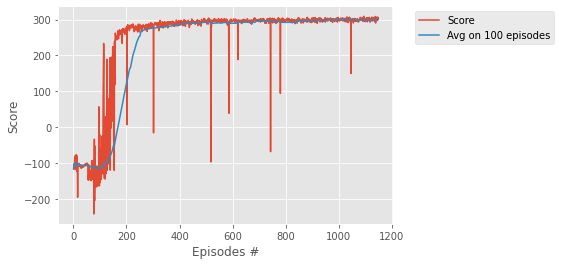

In [11]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
env.close

<bound method Wrapper.close of <TimeLimit<BipedalWalker<BipedalWalker-v3>>>>